<a href="https://colab.research.google.com/github/Konstantin-Maykov/Pet-project/blob/main/Hackathon_from_Kinopoisk/Hackathon_from_Kinopoisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ телеграм-канала Кинопоиска

У нас есть данные телеграм-канала Кинопоиска.
Главная задача проекта: необходимо продумать механику привлечения подписчиков в канал. Цель аналитиков: выявить наиболее эффективные и точные метрики для еженедельного/ежемесячного анализа работы.

В наших данных есть информация о подписках и отписках (`sub_det` и `sub_gen`), о комментариях (`comments`), репостах (`reposts`) и постах (`posts`).

**План работы:**
1. **Загрузить данные и ознакомиться с ними,**

2. **Предобработка данных:**
  - sub_det,
  - sub_gen,
  - comments,
  - posts,
  - reposts,

3. **EDA:**
  - распределения значений датасетов,
  - подробное изучение хранящихся данных,

4. **Анализ текста постов:**
  - Предобработка текста,
  - Применение кластеризации,
  - Вывод ключевых слов кластеров,
  - Изучение тематик постов,

5. **Корреляция:**
  - Подготовка данных,
  - График корреляции,
  - Анализ результатов,

6. **Метрики:**
  - Динамика подписок и отписок
  - Охват,
  - Вовлеченность,
    - Тематики лучших по вовлеченности постов
    - Облако слов,
    - Анализ тематик,
    - Биграммы и триграммы,
    - Изучение длины топовых постов,
    - Проверка гипотезы,
    - Вовлеченность разных постов в разрезе дат и времени,

7. **Вывод и рекомендации.**


## Подготовка к работе

In [ ]:
# выделим загрузки отдельно
!pip install phik
!pip install gdown
!pip install pymorphy2

In [ ]:
# неоходимые библиотеки для работы
import pandas as pd
import gdown
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statistics as stat
import itertools
import phik
from datetime import datetime

# библиотеки для семантического анализа
from wordcloud import WordCloud
import re
import string
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import bigrams, trigrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from pymorphy2 import MorphAnalyzer

nltk.download('punkt', download_dir='/usr/nltk_data')
nltk.download('stopwords', download_dir='/usr/nltk_data')

# приводим графики в один вид
sns.set_style('darkgrid')
plt.style.use('ggplot')
sns.set_palette('deep')

# cброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

# отключаем предупреждения
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /usr/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Загрузка данных

In [ ]:
file_ids = [
    "1vCc_grZNoOwpP3Rx4v8hsC-ohcoS7_JM",
    "1QQPd8ub_WtJQtN1rxwTvZ4r_B_kJurfq",
    "1A2_ifrHyFsoUiBKU6kcdzdtlljxd9VS2",
    "17ZI_AJGyvOEWZR0DQ5DijR6FdA7qOK5T",
    "1LKnI-hdtM7tTHk1pmQFjCgEu9GxIlB9h",
    "144Eafz4UiwMS1KN5dfGbyJf1yVR6GIwS"
]

for file_id in file_ids:
    download_link = f"https://drive.google.com/uc?id={file_id}"
    output_file = f"output_{file_id}.csv"  # Заменяет на нужное имя файла

    gdown.download(download_link, output=output_file, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1vCc_grZNoOwpP3Rx4v8hsC-ohcoS7_JM
To: /content/output_1vCc_grZNoOwpP3Rx4v8hsC-ohcoS7_JM.csv
100%|██████████| 21.8M/21.8M [00:00<00:00, 143MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1QQPd8ub_WtJQtN1rxwTvZ4r_B_kJurfq
From (redirected): https://drive.google.com/uc?id=1QQPd8ub_WtJQtN1rxwTvZ4r_B_kJurfq&confirm=t&uuid=dffec1f4-ad64-4d41-877c-6784036b216f
To: /content/output_1QQPd8ub_WtJQtN1rxwTvZ4r_B_kJurfq.csv
100%|██████████| 127M/127M [00:00<00:00, 175MB/s]
Downloading...
From: https://drive.google.com/uc?id=1A2_ifrHyFsoUiBKU6kcdzdtlljxd9VS2
To: /content/output_1A2_ifrHyFsoUiBKU6kcdzdtlljxd9VS2.csv
100%|██████████| 237k/237k [00:00<00:00, 33.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=17ZI_AJGyvOEWZR0DQ5DijR6FdA7qOK5T
To: /content/output_17ZI_AJGyvOEWZR0DQ5DijR6FdA7qOK5T.csv
100%|██████████| 472k/472k [00:00<00:00, 43.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LKnI-hdtM7tTHk1pmQFj

In [ ]:
# прочитаем сеты
comments = pd.read_csv('/content/output_1vCc_grZNoOwpP3Rx4v8hsC-ohcoS7_JM.csv', index_col=[0,1])
posts = pd.read_csv('/content/output_1QQPd8ub_WtJQtN1rxwTvZ4r_B_kJurfq.csv', index_col=0)
reposts = pd.read_csv('/content/output_1A2_ifrHyFsoUiBKU6kcdzdtlljxd9VS2.csv', index_col=0)
sub_det = pd.read_csv('/content/output_17ZI_AJGyvOEWZR0DQ5DijR6FdA7qOK5T.csv', index_col=0)
sub_gen = pd.read_csv('/content/output_1LKnI-hdtM7tTHk1pmQFjCgEu9GxIlB9h.csv', index_col=0)
reposts_pars = pd.read_csv('/content/output_144Eafz4UiwMS1KN5dfGbyJf1yVR6GIwS.csv', index_col=0)

In [ ]:
# функция вывода общей информации
def show_stats(df):
    start_shape = df.shape
    mins, means, medians, maxs = [], [], [], []
    stats_df = pd.DataFrame(index=df.columns.tolist())
    stats_df['dtype'] = [df[col].dtypes for col in df.columns]
    stats_df['nans_count'] = df.isna().sum().tolist()
    stats_df['nans_ratio_%'] = (df.isna().mean() * 100).round(2)
    stats_df['uniques'] = [df[col].nunique() for col in df.columns]
    for col in df.columns:
        if df[col].dtypes in ['int', 'float']:
            mins.append(round(df[col].min(), 2))
            means.append(round(df[col].mean(), 2))
            medians.append(round(df[col].median(), 2))
            maxs.append(round(df[col].max(), 2))
        else:
            mins.append(np.nan)
            means.append(np.nan)
            medians.append(np.nan)
            maxs.append(np.nan)
    stats_df['min'], stats_df['mean'], stats_df['median'], stats_df['max'] = mins, means, medians, maxs
    def format_nan_to_empty(val):
      return '' if pd.isna(val) else val
    display(stats_df.style
            .format('{:.2f}', subset=['nans_ratio_%', 'min', 'mean', 'median', 'max'])
            .format(format_nan_to_empty)
            .background_gradient(cmap='coolwarm', subset='nans_ratio_%'))
    dubl_count = df.duplicated().sum()
    dubl_ratio = round(dubl_count / start_shape[0] * 100, 2)
    print('Число явных дубликатов:', dubl_count, \
          '\nДоля явных дубликатов от всего датасета:', dubl_ratio, '%', \
          '\nКоличество строк:', start_shape[0], \
          '\nКоличество столбцов:', start_shape[1])

## Изучение общей информации

Вызываем функцию для каждого датасета, чтобы изучить их общую информацию.

In [ ]:
show_stats(comments)

Число явных дубликатов: 620 
Доля явных дубликатов от всего датасета: 0.44 % 
Количество строк: 139522 
Количество столбцов: 3


**Промежуточный вывод по датасету comments**

1. Имеется 5.25 % с прпускми. Похоже, что это посты без комментариев подписчиков.
2. Есть явные дубликаты 0,44 %, которые можно удалить.

In [ ]:
show_stats(reposts)

Число явных дубликатов: 85 
Доля явных дубликатов от всего датасета: 3.69 % 
Количество строк: 2306 
Количество столбцов: 4


**Промежуточный вывод по датасету reposts**

1. Есть явные дубликаты, которые составляют 3.69 % от всего датастета. Они получились при парсинге данных. Их можно удалить.
2. Аномальных сначений в числовых столбцах не выявили.
3. Изменить тип данных столбца date на datetime.

In [ ]:
show_stats(sub_det)

Число явных дубликатов: 0 
Доля явных дубликатов от всего датасета: 0.0 % 
Количество строк: 12282 
Количество столбцов: 4


**Промежуточный вывод по датасету sub_det**

Изменить типы данных у столбцов date и time на тип datetime.

In [ ]:
show_stats(posts)

Число явных дубликатов: 0 
Доля явных дубликатов от всего датасета: 0.0 % 
Количество строк: 23326 
Количество столбцов: 12


**Промежуточный вывод по датасету posts**

1. 59,24 % пропусков в столбце reactions, это значит, что на эти посты никак пользователи не отреагировали. Эти строки удалять нельзя.
2. 47.56 % в столбце replies означает, что эти посты не пересылали. Также удалять нельзя.
3. Столбец type_attachment и with_media содержат 3.14 % пропусков. Эти пропуски означают, что к этим постам документы не прикрепляли.
4. Столбец channel можно удалить, так как в нем всего одно уникальное название канала - Кинопоиск.
5. Есть по одному пропуску в столбцах views и forwarded. Эти пропуски можно удалить.
6. Тип столбца date надо перевести в datetime.

In [ ]:
show_stats(sub_gen)

Число явных дубликатов: 0 
Доля явных дубликатов от всего датасета: 0.0 % 
Количество строк: 520 
Количество столбцов: 3


**Промежуточный вывод по датасету sub_gen**

Тип столбца date надо изменить на datetime.

### Должно быть сделано

- Изменение типов данных в датасетах, где есть столбцы date, time.
- Удалить явные дубликаты.
- Обработать пропуски: заполнить, оставить как есть или удалить.
- Очистить данные от ошибок, аномалий (если есть).

## Предобработка данных

### Sub_det

In [ ]:
# добавление года 2024 к тем строкам, где год не указан
sub_det['date'] = sub_det['date'].apply(lambda x: x + ' 2024' if '2023' not in x else x)

# функция для извлечения даты
def extract_date(date_str):
    # разделим строку по пробелам
    date_parts = date_str.split()

    # получим части даты
    day = date_parts[1]
    month = date_parts[2]
    year = date_parts[3]

    # соберем дату в формате 'День Месяц Год'
    formatted_date = f"{day} {month} {year}"

    return formatted_date

# применим функцию к каждой строке в столбце
sub_det['formatted_date'] = sub_det['date'].apply(extract_date)

# преобразуем форматированные строки в объекты datetime
sub_det['formatted_date'] = pd.to_datetime(sub_det['formatted_date'], format='%d %b %Y', errors='coerce')

In [ ]:
# преобразование столбца 'formatted_date'
sub_det['formatted_date'] = sub_det['formatted_date'].astype(str)

# объединяем столбцы 'formatted_date' и 'time' в новый столбец 'full_datetime' с нужным типом данных
sub_det['datetime'] = pd.to_datetime(sub_det['formatted_date'] + ' ' + sub_det['time'], format='%Y-%m-%d %H:%M', errors='coerce')

In [ ]:
# создадим колонку с днем недели (0 - понедельник, 1 - вторник, и так далее)
sub_det['weekday'] = sub_det['datetime'].dt.dayofweek

In [ ]:
# удалим столбец date, time и formatted_date
sub_det = sub_det.drop(['date', 'time', 'formatted_date'], axis=1)

In [ ]:
# добавляем столбец date где будет только дата
sub_det['date'] = pd.to_datetime(sub_det['datetime']).dt.date
sub_det['date'] = pd.to_datetime(sub_det.date, format='%Y-%m-%d')

# извлекаем час из столбца 'datetime'
sub_det['hour'] = sub_det['datetime'].dt.hour

# создаем новый столбец, указывающий на период дня
sub_det['day_period'] = pd.cut(sub_det['hour'], bins=[0, 6, 12, 18, 24], labels=['Ночь', 'Утро', 'День', 'Вечер'], include_lowest=True)

In [ ]:
# посмотрим, как выглядит сет после обработки
sub_det.head()

subscribers  unsubscribed            datetime  weekday       date  hour  \
0          204          -300 2024-01-18 11:29:00        3 2024-01-18    11   
1          373          -366 2024-01-18 11:00:00        3 2024-01-18    11   
2          333          -150 2024-01-18 10:00:00        3 2024-01-18    10   
3          211          -133 2024-01-18 09:00:00        3 2024-01-18     9   
4          152           -90 2024-01-18 08:00:00        3 2024-01-18     8   

  day_period  
0       Утро  
1       Утро  
2       Утро  
3       Утро  
4       Утро

In [ ]:
# выведем первую дату
first_date = sub_det['datetime'].min()
print('Первая дата фиксации подписок и отписок:', first_date)

# выведем последнюю дату
last_date = sub_det['datetime'].max()
print('Последняя дата фиксации подписок и отписок:', last_date)

Первая дата фиксации подписок и отписок: 2022-08-17 00:00:00
Последняя дата фиксации подписок и отписок: 2024-01-18 11:29:00


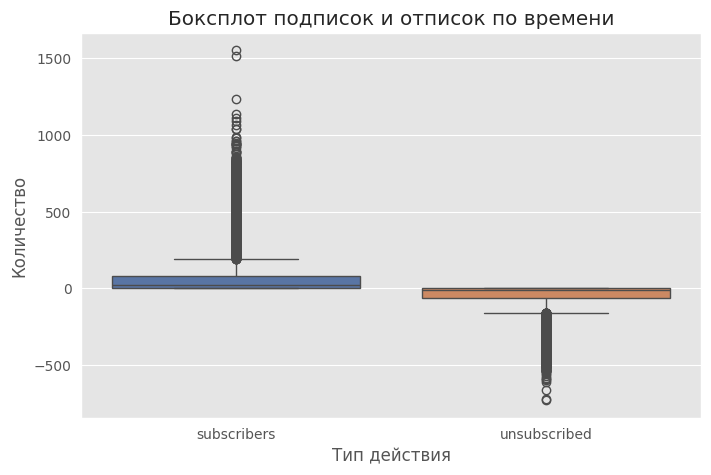

In [ ]:
# построим боксплот с разделением по цветам
plt.figure(figsize=(8, 5))
sns.boxplot(x='variable', y='value', hue='variable', data=pd.melt(sub_det[['subscribers', 'unsubscribed']]))

# добавим заголовок и метки осей
plt.title('Боксплот подписок и отписок по времени')
plt.xlabel('Тип действия')
plt.ylabel('Количество')

# отобразим график
plt.show()

In [ ]:
# посмотрим на данные с часами и датами самых больших подписок
sub_det.query('subscribers > 1000').sort_values(['subscribers'], ascending=False)

subscribers  unsubscribed            datetime  weekday       date  hour  \
7338         1553             0 2023-03-12 21:00:00        6 2023-03-12    21   
1459         1516          -377 2023-11-17 17:00:00        4 2023-11-17    17   
869          1233          -421 2023-12-12 18:00:00        1 2023-12-12    18   
1457         1134          -450 2023-11-17 19:00:00        4 2023-11-17    19   
1458         1108          -463 2023-11-17 18:00:00        4 2023-11-17    18   
1484         1090          -498 2023-11-16 15:00:00        3 2023-11-16    15   
1481         1064          -283 2023-11-16 18:00:00        3 2023-11-16    18   
870          1037          -234 2023-12-12 17:00:00        1 2023-12-12    17   
1318         1036          -451 2023-11-23 21:00:00        3 2023-11-23    21   

     day_period  
7338      Вечер  
1459       День  
869        День  
1457      Вечер  
1458       День  
1484       День  
1481       День  
870        День  
1318      Вечер

In [ ]:
# посмотрим на данные с часми и датами самых больших отписок
sub_det.query('unsubscribed < -600').sort_values(['unsubscribed'], ascending=True)

subscribers  unsubscribed            datetime  weekday       date  hour  \
410           495          -732 2024-01-01 01:00:00        0 2024-01-01     1   
1479          942          -725 2023-11-16 20:00:00        3 2023-11-16    20   
539           746          -665 2023-12-26 15:00:00        1 2023-12-26    15   
491           761          -614 2023-12-28 15:00:00        3 2023-12-28    15   
1182          718          -603 2023-11-29 14:00:00        2 2023-11-29    14   

     day_period  
410        Ночь  
1479      Вечер  
539        День  
491        День  
1182       День

In [ ]:
# создадим столбец для будущего анализа
# извлекаем час из столбца 'datetime'
sub_det['hour'] = sub_det['datetime'].dt.hour

# создаем новый столбец, указывающий на период дня
sub_det['day_period'] = pd.cut(sub_det['hour'], bins=[0, 6, 12, 18, 24], labels=['Ночь', 'Утро', 'День', 'Вечер'], include_lowest=True)

**Промежуточный вывод:**
1. Пропусков, дубликатов нет.
2. Старт датасета - 17 августа 2022 года, окончание - 18 января 2024 года.
3. Есть выбросы, они могут быть из-за кампаний и активностей... Наибольшее число подписок 1533 (12 марта 2023 года). Наименьшее 0. Наибольшее число отписок 732 (1 января 2024 года). Наименьшее 0.
4. В среднем подписки = 78, отписки = 49.

**sub_det** - Представлена информация о подписчиках канала и отписках.
- `subscribers` - количество подписавшихся
- `unsubscribed` - количество отписок
- `weekday` - день недели
- `datetime` - дата и время
- `day_period` - часть дня

### Sub_gen

In [ ]:
# изменим типы данных в sub_gen
sub_gen['date'] = pd.to_datetime(sub_gen['date'], format='%d.%m.%y', errors='coerce')

In [ ]:
# выведем первую дату
first_date = sub_gen['date'].min()
print('Первая дата фиксации подписок:', first_date)

# выведем последнюю дату
last_date = sub_gen['date'].max()
print('Последняя дата фиксации подписок:', last_date)

Первая дата фиксации подписок: 2022-08-17 00:00:00
Последняя дата фиксации подписок: 2024-01-18 00:00:00


**Промежуточный вывод:**
1. Пропусков, дубликатов нет.
2. Старт датасета - 17 августа 2022 года, окончание - 18 января 2024 года.

**sub_gen** - Представлена общая информация о подписчиках канала в разбивке по дням.
- `date`- дата
- `subscribers` - суммарное количество подписок на эту дату
- `changes` - разница в количестве подписчиков между текущей и предыдущей датами

### Comments

In [ ]:
# изменим тип данных в столбце
comments['date_comment'] = pd.to_datetime(comments['date_comment'], errors='coerce')

# удалим информацию о часовом поясе
comments['date_comment'] = comments['date_comment'].dt.tz_localize(None)

# переводим время на московское путем прибавления часов
comments['date_comment'] = comments['date_comment'] + pd.Timedelta(hours=3)

# Извлечение часов из столбца datetime
comments['hour'] = comments['date_comment'].dt.hour

In [ ]:
# проверка на пропуски
missing_values = comments.isnull().sum()
print('Пропущенные значения в каждом столбце:')
print(missing_values)

# проверка на дубликаты
duplicate_rows = comments[comments.duplicated()]
print('\nКоличество дубликатов:', duplicate_rows.shape[0])

Пропущенные значения в каждом столбце:
post_id            0
date_comment       0
text_comment    7330
hour               0
dtype: int64

Количество дубликатов: 620


На количество дубликатов влияет столбец Unnamed: 0.1 с дополнительными индексами. Нужно его удалить и еще раз просмотреть информацию по пропускам и дубликатам.

In [ ]:
comments.reset_index(drop=True, inplace=True)
comments.head()

post_id        date_comment  \
0    37068 2024-01-18 12:34:31   
1    37068 2024-01-18 12:35:00   
2    37068 2024-01-18 12:35:11   
3    37068 2024-01-18 12:36:34   
4    37068 2024-01-18 12:37:41   

                                        text_comment  hour  
0  От бесстыжих к медведю - так это скорее не пут...    12  
1                                 учился орать FUCK!    12  
2                                   Верните бестыжих    12  
3      От липа из бесстыжих до рекламы кельвин кляйн    12  
4           этот навык был освоен еще в "бесстыжих"🧡    12

In [ ]:
# общее количество строк в датафрейме
total_rows = len(comments)

# количество строк с пропусками во всех столбцах
total_missing_rows = comments.isnull().any(axis=1).sum()

# процент строк с пропусками
percentage_missing_rows = (total_missing_rows / total_rows) * 100

print(f'Процент строк с пропусками в датафрейме: {percentage_missing_rows:.2f}%')

Процент строк с пропусками в датафрейме: 5.25%


In [ ]:
# удалим пропуски
comments = comments.dropna()

# проверка на пропуски после удаления строк с пропусками
missing_values = comments.isna().sum()
print('Пропущенные значения в каждом столбце после удаления пропусков:')
print(missing_values)

# проверка на дубликаты после удаления пропусков
duplicate_rows = comments[comments.duplicated()]
print('\nКоличество дубликатов после удаления пропусков:', duplicate_rows.shape[0])

Пропущенные значения в каждом столбце после удаления пропусков:
post_id         0
date_comment    0
text_comment    0
hour            0
dtype: int64

Количество дубликатов после удаления пропусков: 17


In [ ]:
# посчитаем процент дубликатов ко всему датасету
# количество строк с дубликатами
total_duplicate_rows = len(comments[comments.duplicated()])

# общее количество строк в датафрейме
total_rows = len(comments)

# процент дубликатов
percentage_duplicate_rows = (total_duplicate_rows / total_rows) * 100

print(f'Процент дубликатов в датафрейме: {percentage_duplicate_rows:.2f}%')

Процент дубликатов в датафрейме: 0.01%


In [ ]:
# удалим дублирующиеся строки
comments = comments.drop_duplicates(subset=['post_id', 'date_comment', 'text_comment'])

In [ ]:
# выведем первую дату
first_date = comments['date_comment'].min()
print('Первая дата фиксации комментариев:', first_date)

# выведем последнюю дату
last_date = comments['date_comment'].max()
print('Последняя дата фиксации комментариев:', last_date)

Первая дата фиксации комментариев: 2022-09-22 16:31:20
Последняя дата фиксации комментариев: 2024-01-19 10:12:55


**Промежуточный вывод:**
1. Пропуски (5%) были удалены, дубликаты (0.01%) также были удалены
2. Старт датасета - 22 сентября 2022 года, окончание - 19 января 2024 года.

**comments** - Представлены текстовые комментарии к постам.
- `post_id`- идентификатор поста, к которому был написан комментарий. Соответствует ID в sub_gen
- `date_comment` - дата публикации комментария
- `text_comment` - текстовое содержание комментария

### Posts

1. Считаем, что столбец with_media можно удалить, так как его основная информация (тип поста) повторяется в столбце type_attachement.
2. В ячейке указана одна уникальная ссылка на телеграм канал Кинопоиска. Столбец неинформативен, удаляем.

In [ ]:
# удаляем столбцы, не нужные для данного анализа
posts = posts.drop(columns=['channel', 'replies', 'with_media', 'reactions'], axis=1).reset_index(drop=True)

In [ ]:
# переводим в тип datetime
posts.date = pd.to_datetime(posts['date'], errors='coerce')

# удалим информацию о часовом поясе
posts.date = posts.date.dt.tz_localize(None)

# переводим время на московское путем прибавления часов
posts.date = posts.date + pd.Timedelta(hours=3)

In [ ]:
print('Минимальная дата:', min(posts.date))
print('Максимальная дата:', max(posts.date))

Минимальная дата: 2016-12-19 19:24:41
Максимальная дата: 2024-01-21 11:02:21


Первая дата наблюдений в датасете 2016-07-01. Последняя - 2024-01-21. Отбросим данные датасета до момента первой даты фиксации подписок и отписок в датасете sub_det 2022-08-17 00:00:00 и последней 2024-01-18 00:00:00.

In [ ]:
# изучим, какие файлы прикреплены к постам
posts.type_attachment.unique()

array(['MessageMediaWebPage', 'MessageMediaPhoto', 'MessageMediaDocument',
       nan], dtype=object)

Посчитаем число пропусков в датасете после его обрезки.

In [ ]:
round(posts.isna().sum()/len(posts)*100, 2)

id                 0.00
date               0.00
text               0.00
views              0.00
forwarded          0.00
reactions_count    0.00
comments           0.00
type_attachment    3.14
dtype: float64

type_attachment имеет 0,56 % пропусков. Это не много, если смотреть на весь датасет, но если все они попадут в вбранный для исследования промежуток, это может повляить на исследование. Пока пропуски оставим, как есть.

Обработаем столбец type_attachment. Переименовываем названия видов документов в посте.

In [ ]:
posts.type_attachment = posts.type_attachment.replace({'MessageMediaWebPage': 'webpage',
                                                       'MessageMediaPhoto': 'photo',
                                                       'MessageMediaDocument': 'video'})
posts.type_attachment.unique()

array(['webpage', 'photo', 'video', nan], dtype=object)

In [ ]:
# проверяем есть ли повторения в id
posts.id.duplicated().sum()

0

**Выводы по датаесту posts**

1. После обрезки датасета первая дата поста: 2022-08-17 10:15:24. Последняя дата: 2024-01-17 20:46:05.
2. Есть 0,57 % пропусков в столбце type_attachment от всех значений.
3. Удалили столбцы 'channel', 'replies', 'with_media', 'reactions'.

### Reposts

**Переведу столбец в тип datetime**

In [ ]:
# удаляем запятые в датах, где указан год 2023
rep_23 = reposts.loc[reposts.date.str.contains(r'2023', na=True)].replace(r',', '', regex=True)

In [ ]:
# создаем сет с записями от 24 года
rep_24 = reposts.query('index not in @rep_23.index')

# вместо запятых ставим ' 2024'
rep_24['date'] = reposts.date.replace(r',', ' 2024', regex=True)

# объединяем сеты в новый reposts
reposts = pd.concat([rep_24, rep_23])

# переводим тип данных в тип datetime
reposts.date = pd.to_datetime(reposts.date, format='%d %b %Y %H:%M', errors='coerce')

Посмотрим даты первого и последнего упоминания записей или самого канала.

In [ ]:
print('Первое упоминание', reposts.date.min())
print('Последнее упоминание:', reposts.date.max())

Первое упоминание 2023-10-22 13:08:00
Последнее упоминание: 2024-01-19 10:02:00


**Промежуточные выводы по Reposts**

1. Первое упоминание 2023-10-22 13:08:00
2. Последнее упоминание: 2024-01-19 10:02:00
3. Данных для анализа мало. Надо искать дополнительную информацию.

Сгруппируем данные по каналам и выведем топ-30 каналов по репостам/упоминаниям постов Кинопоиска.

In [ ]:
reposts.groupby('channel').date.count().nlargest(30)

channel
Обсуждаем фильмы. Поиском кино не занимаемся    694
Новости кино                                    507
НаКал КаНал                                     228
Смотрим кино с психологом                        37
Што это было                                     35
🎬КИНОПОИСК🎬                                      34
kiraderen - это мандарин                         27
Стримми                                          23
ШиЗоХатА в норе у Енота🦝🦝🦝                       17
Zoyarekomendyet                                  16
Просто Чума                                      15
🎬 КиноДед                                        15
New Media                                        11
Sakhkino 😎                                       11
YktRePublic                                      11
Movie House                                      10
Дима SuperVHS: мемы и кино                        9
Помощь аркозависимым                              8
𐌑у‌ρз‌и‌л‌к‌а‌                                    8
Alpe

Из датесета reposts выделили уникальные каналы и провели парсинг каналов, в которых было упоминание канала 'https://t.me/kinopoisk'.
На основании данных этого сета спарсили данные по части каналов. В эти каналы вошли все топ-30 каналов (кроме Кинокотята) по упоминаниям в датасете reposts. [Тетрадка с парсингом](https://colab.research.google.com/drive/1Vzj-bCq_tIocp3QkdQbS0M2qfrF8tHIU)

Датасет состоит из столбцов:
- channel - телеграм канал,
- id - айди поста в этом канале,
- date - дата публикации,
- text - текстовое содержание поста,
- with_media - тип прикрепленного к посту документа.

**Дубликаты**

In [ ]:
# проверка на дубликаты
reposts_pars.duplicated().sum()

0

In [ ]:
# выведем максимальную и минимальную даты датасета
print('Дата первой записи:', reposts_pars.date.min())
print('Дата второй записи:', reposts_pars.date.max())

Дата первой записи: 2018-04-05 15:13:53
Дата второй записи: 2024-02-23 16:38:09


Дублей нет.

In [ ]:
# удаляем столбцы, которые не нужны для данного анализа
reposts_pars = reposts_pars.drop(columns='with_media')

# переименовываем значения в столбце type_attachment
reposts_pars.type_attachment = reposts_pars.type_attachment.replace({'MessageMediaWebPage': 'webpage',
                                                                     'MessageMediaPhoto': 'photo',
                                                                     'MessageMediaDocument': 'video'})
# посчитаем количество пропусков в столбцах
reposts_pars.isna().sum()

channel              0
id                   0
date                 0
text                 0
type_attachment    227
dtype: int64

Пропуски у столбцов views и forwarded заполним нулям, так как либо не смотрели либо не пересылали пост. Cтолбец type_attachment оставим с пропусками, так как в этих строках посты без прикрепленного документа.

**Выводы по reposts_pars**

1. Данные в датасете от 2018-04-05 15:13:53 и до 2024-02-23 16:38:09.
2. Пропуски остались только в столбце type_attachment (227 шт.)

### Приводим все сеты к одному промежутку

In [ ]:
# приводим все датасеты к одному промежутку для анализа
sub_gen = sub_gen.query('date >= "2023-01-01" and date <= "2024-01-15"').reset_index(drop=True)

# преобразование столбца 'datetime' в тип datetime
sub_det['datetime'] = pd.to_datetime(sub_det['datetime'])

# фильтрация по времени
sub_det = sub_det[(sub_det['datetime'] >= '2023-01-01') & (sub_det['datetime'] <= '2024-01-14')].reset_index(drop=True)

posts = posts.query('date >= "2023-01-01" and date <= "2024-01-14"').reset_index(drop=True)
reposts_pars = reposts_pars.query('date >= "2023-01-01" and date <= "2024-01-14"').reset_index(drop=True)

### Выводы

1. Привели датасеты к одному временному промежутку от 2023-01-01 до 2024-01-14, кроме датасета sub_gen его промежуток от 2023-01-01 до 2024-01-15, так как в нем хранится разность числа подписчиков между следующим и предыдущим днем.
2. Изменили тип в столбцах с датами.
3. Дополнили данные спарсенным датасетом reposts_pars, в котором хранится информация о каналах, которые упоминали или репостили записи канала Кинопоиска.
4. Удалили дубликаты и столбцы, которые не несут пользы.
5. Переименовали названия видов документов в посте.

## Исследовательский анализ данных

### Датасет sub_gen

**Столец subscribers.**

Посчитаем минимальное и максимальное значение подписчиков.
Выясним число подписчиков на начало и конец выбранного диапазона наблюдений. И
разницу между ними.

In [ ]:
first_day = sub_gen.query('date == "2023-01-01"')['subscribers'].squeeze()
last_day = sub_gen.query('date == "2023-12-31"')['subscribers'].squeeze()
print('Число пользователей на 2022-10-01:', first_day)
print('Число пользователей на 2023-10-31:', last_day)
print('Изменение числа подписчиков за рассматриваемый период:', last_day - first_day)
print('Минимальное число подписчиков:', sub_gen.subscribers.min())
print('Максимальное число подписчиков:', sub_gen.subscribers.max())

Число пользователей на 2022-10-01: 226447
Число пользователей на 2023-10-31: 513900
Изменение числа подписчиков за рассматриваемый период: 287453
Минимальное число подписчиков: 226447
Максимальное число подписчиков: 546859


**Столбец changes.**

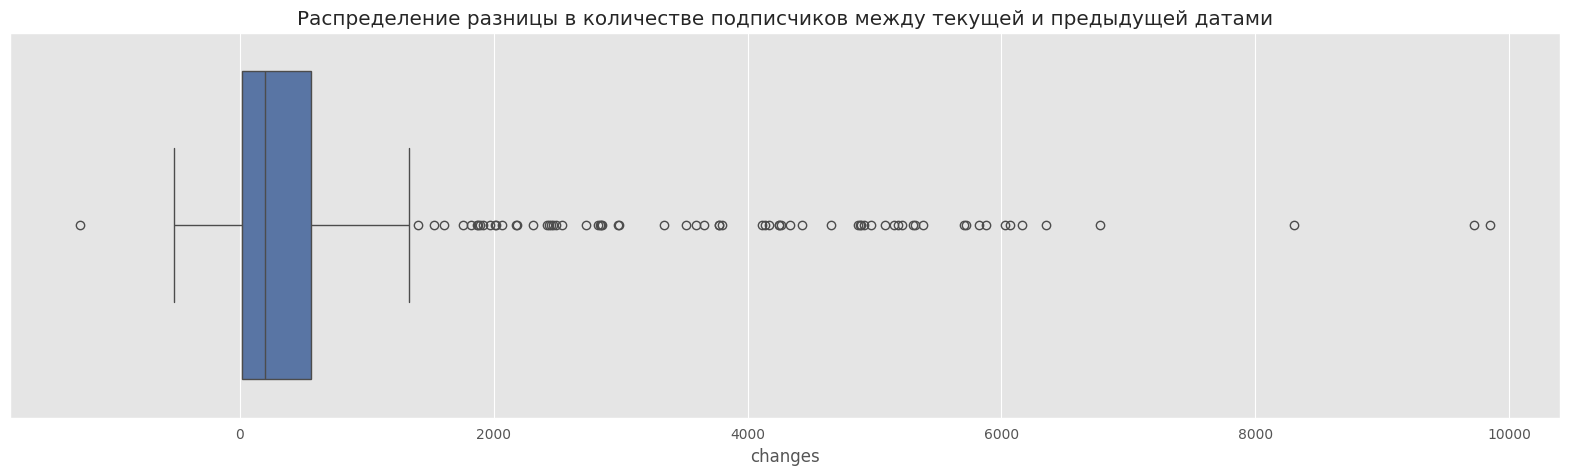

In [ ]:
# строим диаграмму размаха
plt.figure(figsize=(20, 5))
plt.title('Распределение разницы в количестве подписчиков между текущей и предыдущей датами')
sns.boxplot(sub_gen.changes, orient='h')
plt.show()

In [ ]:
print(f'''Минимум: {sub_gen.changes.min()}
Среднее: {sub_gen.changes.mean():.2f}
Медиана: {sub_gen.changes.median():.2f}
Максимум: {sub_gen.changes.max()}''')

Минимум: -1254
Среднее: 846.71
Медиана: 200.00
Максимум: 9844


In [ ]:
# посчитаем значения квантилей
q1 = np.quantile(sub_gen.changes, .25)
q3 = np.quantile(sub_gen.changes, .75)
iqr = q3 - q1

# рассчитываем базовую нижнюю и верхнюю границу диапазона для исключения выбросов
upper_change = q3 + 1.5 * iqr
lower_change = q1 - 1.5 * iqr

# создаем переменную, в которой будут отброшенные выбросы
sub_change_outliers = sub_gen.query('(changes > @lower_change) and (changes < @upper_change)')

print('Потери при удалении выбросов:', round((1- len(sub_change_outliers)/sub_gen.shape[0])*100, 2), '%')

Потери при удалении выбросов: 18.42 %


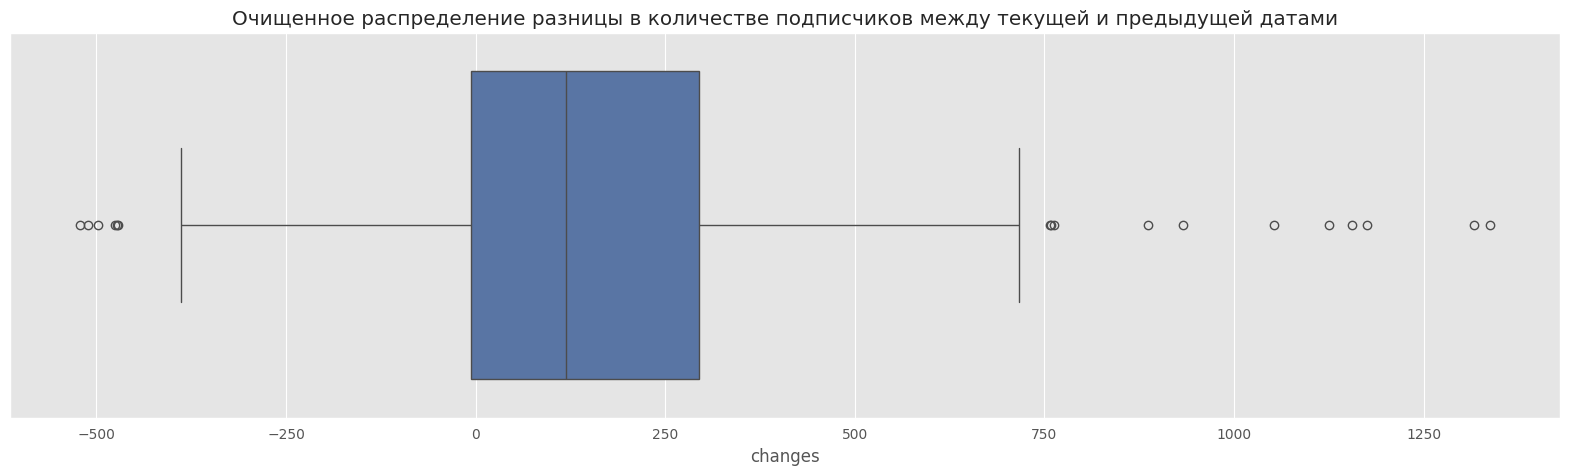

In [ ]:
# строим диаграмму размаха с отсечением выбросов
plt.figure(figsize=(20, 5))
plt.title('Очищенное распределение разницы в количестве подписчиков между текущей и предыдущей датами')
sns.boxplot(sub_change_outliers.changes, orient='h')
plt.show()

После того, как отбросили выбросы разница между количеством подписчиков между текущей и предыдущей датами вырьируется от - 380 до 700. Основная масса значений между -10 и 270. Если отбросить выбросы, то пропадет примерно 18 % данных. Их потеря приведет к неточным результатам исследования.

Определяем даты с отрицательным приростом пользователей. Также посчитаем их количество.

In [ ]:
list_date_out = (sub_gen.query('changes < 0').date - pd.Timedelta(days=1)).tolist()
print('Количество дней с отрицательным приростом подписчиков:', len(list_date_out))

Количество дней с отрицательным приростом подписчиков: 83


**Выводы по сету sub_gen:**
1. Принято решение выбросы не удалять, так как будет потеряно 18 % данных.
2. Определили 83 дня, где наблюдается отрицательный прирост пользователей.

### Датасет sub_det

**Столбец subscribers.**

Посмотрим распределение количества пришедших пользователей.

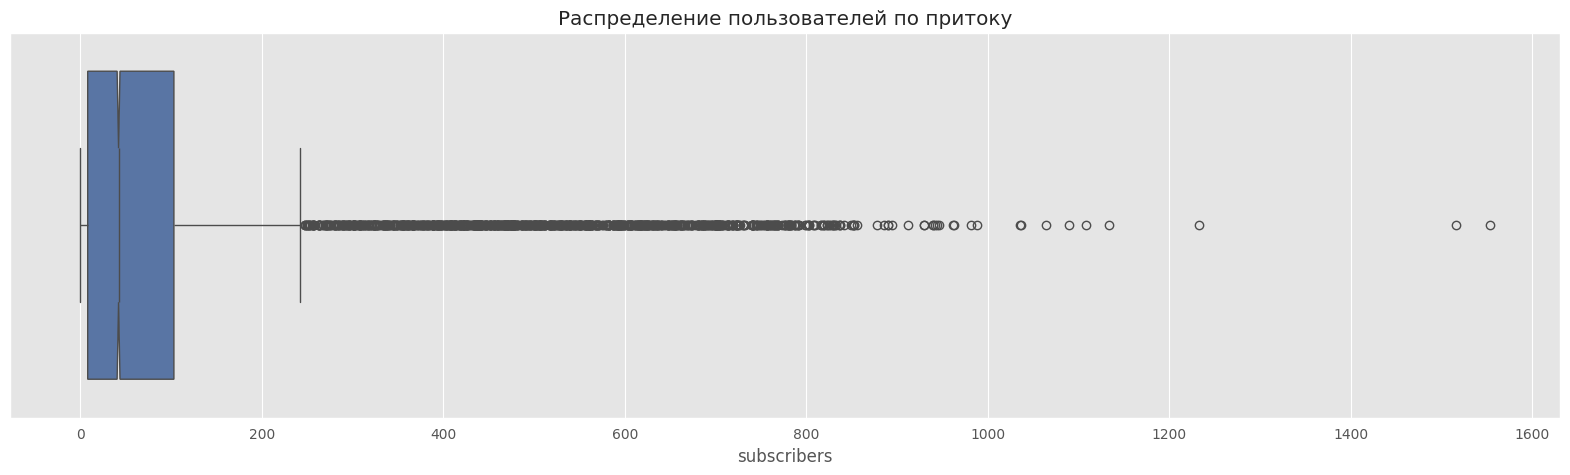

In [ ]:
plt.figure(figsize=(20, 5))
plt.title('Распределение пользователей по притоку')
sns.boxplot(sub_det.subscribers, orient='h', notch=True)
plt.show()

In [ ]:
print(f'''Минимум: {sub_det.subscribers.min()}
Среднее: {sub_det.subscribers.mean():.2f}
Медиана: {sub_det.subscribers.median():.2f}
Максимум: {sub_det.subscribers.max()}''')

Минимум: 0
Среднее: 102.27
Медиана: 42.00
Максимум: 1553


Почистим сет от выбросов (через интерквартальный размах).

In [ ]:
# посчитаю значения квантилей
q1 = np.quantile(sub_det.subscribers, .25)
q3 = np.quantile(sub_det.subscribers, .75)
iqr = q3 - q1

# рассчитываю базовую нижнюю и верхнюю границу диапазона для исключения выбросов
upper_sub = q3 + 1.5 * iqr
lower_sub = q1 - 1.5 * iqr

# создам переменную, в которой будут отброшенные выбросы
subscribers_without_outliers = sub_det.query('(subscribers > @lower_sub) and (subscribers < @upper_sub)')

print('Потери при удалении выбросов:', round((1- len(subscribers_without_outliers)/sub_det.shape[0])*100, 2), '%')

Потери при удалении выбросов: 11.28 %


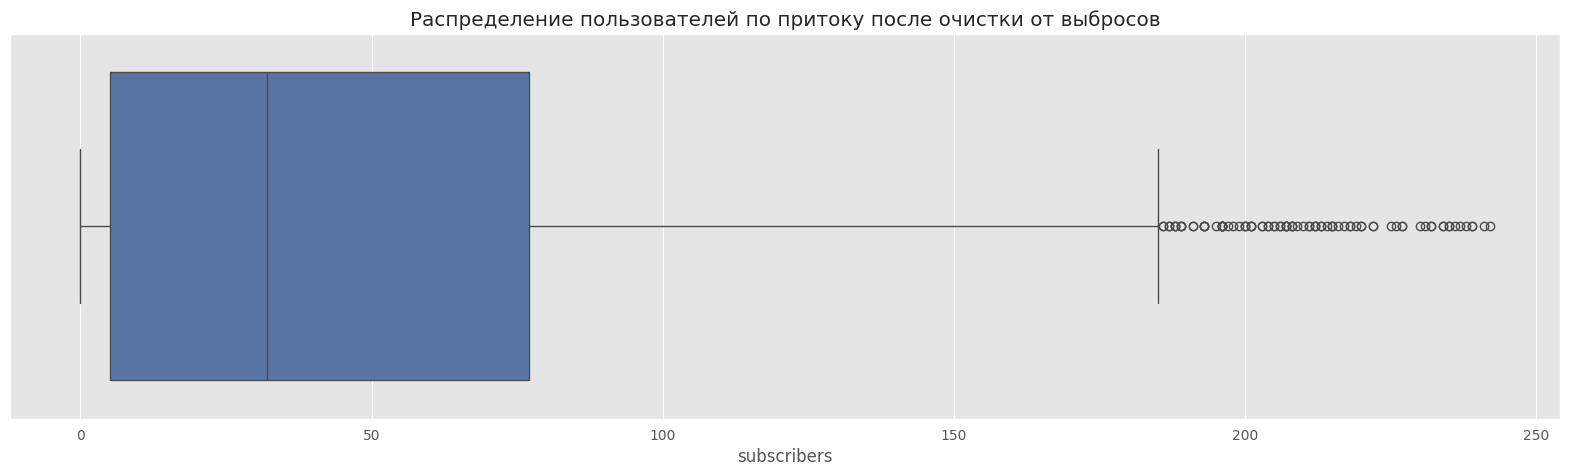

In [ ]:
# строю диаграмму размаха с отсечением выбросов
plt.figure(figsize=(20, 5))
sns.boxplot(subscribers_without_outliers.subscribers, orient='h')
plt.title('Распределение пользователей по притоку после очистки от выбросов')
plt.show()

После того, как отбросили выбросы число новых подписчиков за день колеблется от 0 до 180. Чаще всего в канал приходит до 75 человек в день.

Оставим данные в начальном виде, иначе мы потеряем 11 % от датасета. Эти выбросы также могут показать, какие посты очень сильно повлияли на рост подписчиков.

**Столбец unsubscribed.** В этом столбце распределение значений посмотрим тем же способом, что и в столбце subscribers.

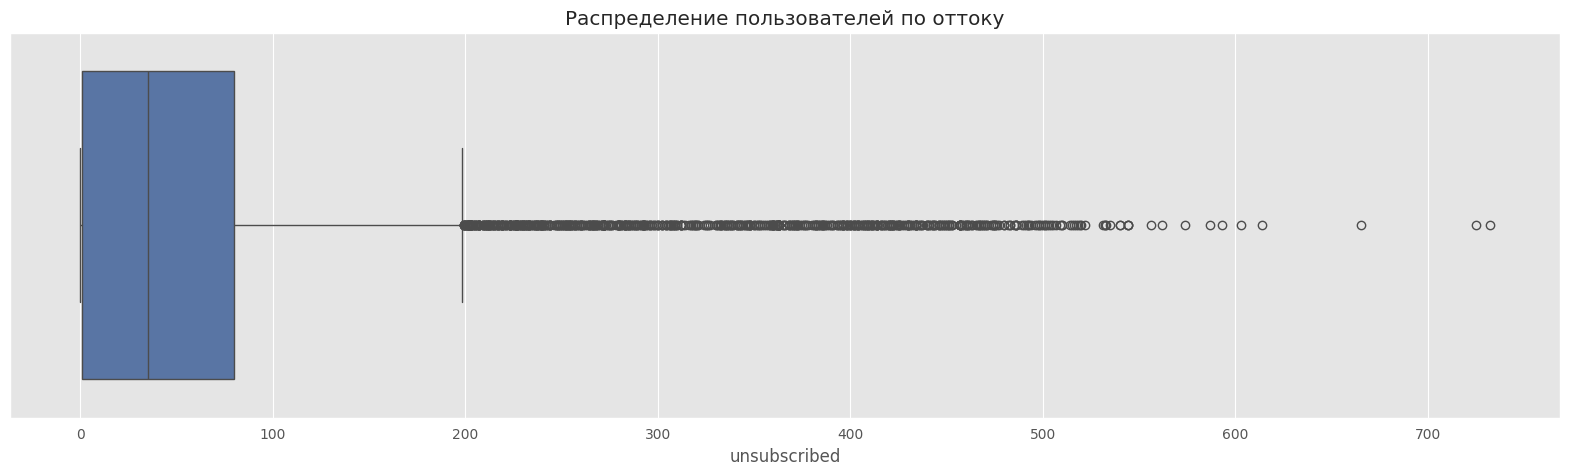

In [ ]:
sub_det.unsubscribed = abs(sub_det.unsubscribed)

plt.figure(figsize=(20, 5))
plt.title('Распределение пользователей по оттоку')
sns.boxplot(sub_det.unsubscribed, orient='h')
plt.show()

In [ ]:
print(f'''Минимум: {sub_det.unsubscribed.min()}
Среднее: {sub_det.unsubscribed.mean():.2f}
Медиана: {sub_det.unsubscribed.median():.2f}
Максимум: {sub_det.unsubscribed.max()}''')

Минимум: 0
Среднее: 65.36
Медиана: 35.00
Максимум: 732


In [ ]:
# посчитаю значения квантилей
q1 = np.quantile(sub_det.unsubscribed, .25)
q3 = np.quantile(sub_det.unsubscribed, .75)
iqr = q3 - q1

# рассчитываю базовую нижнюю и верхнюю границу диапазона для исключения выбросов
upper_gen = q3 + 1.5 * iqr
lower_gen = q1 - 1.5 * iqr

# создам переменную, в которой будут отброшенные выбросы
unsubscribers_without_outliers = sub_det.query('(unsubscribed > @lower_gen) and (unsubscribed < @upper_gen)')

print('Потери при удалении выбросов:', round((1- len(unsubscribers_without_outliers)/sub_det.shape[0])*100, 2), '%')

Потери при удалении выбросов: 8.47 %


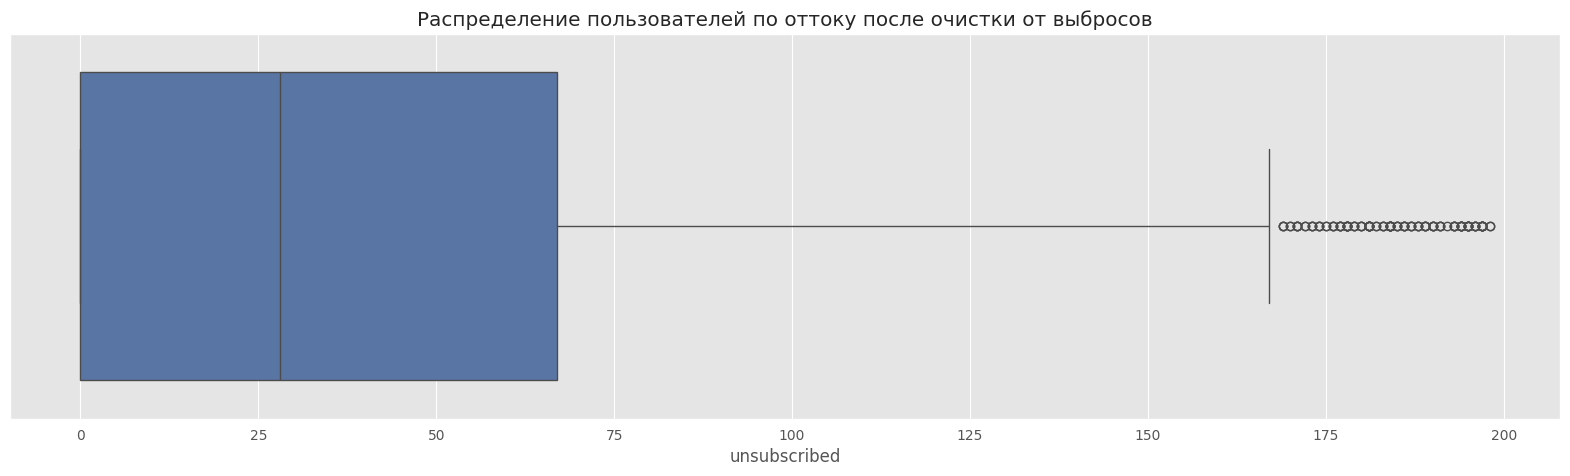

In [ ]:
# строю диаграмму размаха с отсечением выбросов
plt.figure(figsize=(20, 5))
sns.boxplot(unsubscribers_without_outliers.unsubscribed, orient='h')
plt.title('Распределение пользователей по оттоку после очистки от выбросов')
plt.show()

В очищенном датасете отток людей колеблется от 0 до 170. Чаще всего за день уходят до 70 человек. При очистке от выбросов мы потеряем 8.47 % данных. Считаем, что выбросы надо оставить, так как они помогут определить темы постов, которые не понравились пользователям.

<font color='red'>КОМЕНТАРИЙ РЕВЬЮЕРА</font> хорошо. есть одно но: есть же информация о запуске бота, которая повлияла пиково на подписки-отписки в нояре 2024 года. по мне, логично смотреть боксплоты до массового бота (ноябрь) и после. тогда будем понимать диапазон подписок |отписок органически и во время продвижения...

**Распределение притока и оттока пользователей по часам.**

In [ ]:
# группирую сет по времени, агрегирую по медиане столбцы 'subscribers' и 'unsubscribers'
group_hour = sub_det.groupby('hour').agg({'subscribers': 'median', 'unsubscribed': 'median'}).reset_index()

In [ ]:
# функция для построения графиков распределения подписок/отписок
def sub_unsub(df, column_1, column_2, x, dat):
    df.plot(x=x, y=[column_1, column_2], kind='bar', figsize=(15, 5), rot='horizontal')
    plt.title('Распределение подписок/отписок по {}'.format(dat))
    plt.xlabel(x)
    plt.ylabel('Количество')
    plt.show()

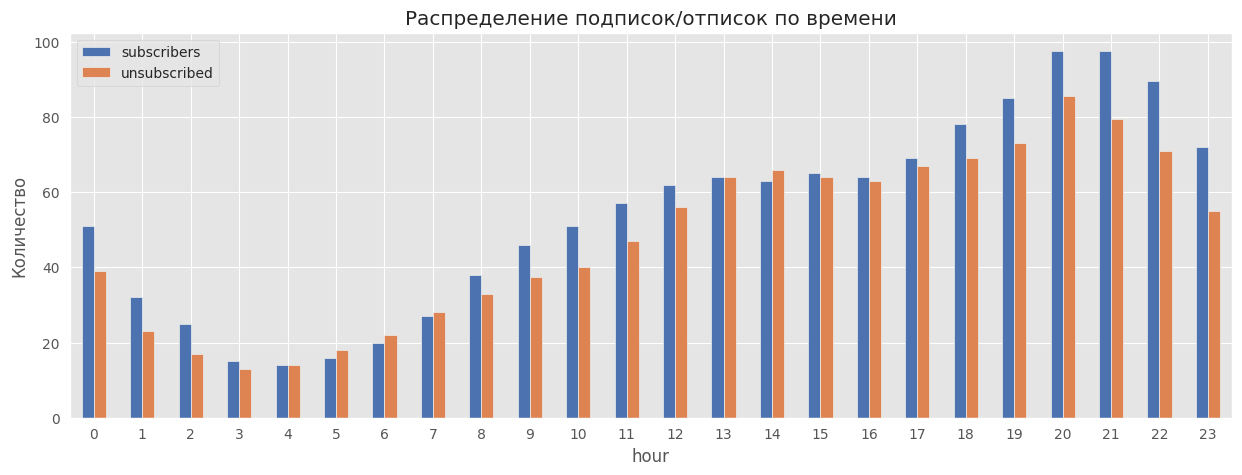

In [ ]:
# строю график распределения
sub_unsub(group_hour, 'subscribers', 'unsubscribed', 'hour', 'времени')

Заметно логичное распределение во времени в соответствие с дневной активностью людей. Ночью подписок и отписок меньше всего, постепенно число увеличивается к вечеру.

Интересно, что в 5, 6 и 7 утра, а также в 14 часов количество отписок выше количества подписок.

**Распределение притока и оттока пользователей по части суток**

In [ ]:
# группирую сет по части суток, агрегирую по медиане столбцы 'subscribers' и 'unsubscribers'
group_period = sub_det.groupby('day_period').agg({'subscribers': 'median', 'unsubscribed': 'median'}).reset_index()

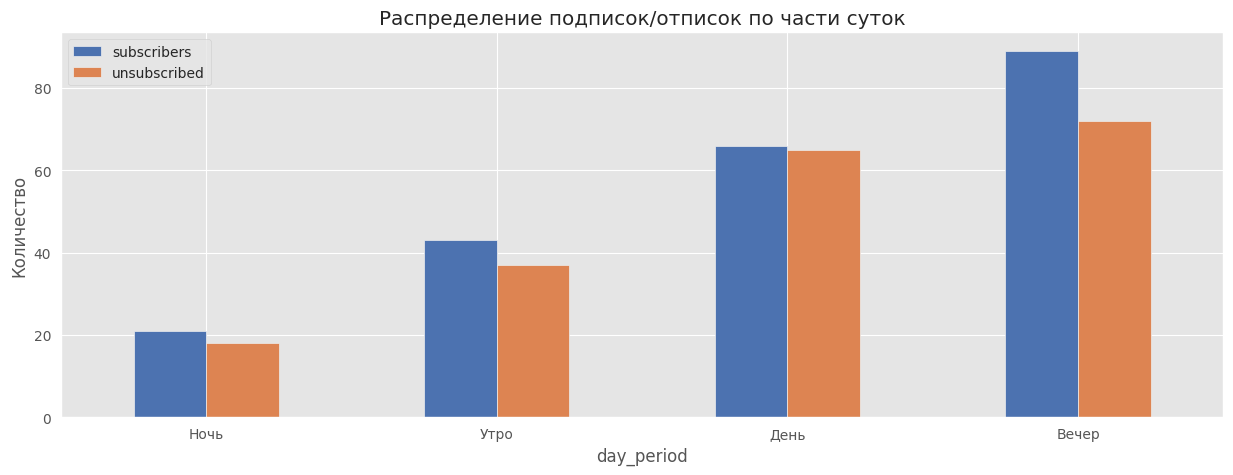

In [ ]:
# строю график распределения
sub_unsub(group_period, 'subscribers', 'unsubscribed', 'day_period', 'части суток')

Наибольшая разница в подписках/отписках вечером, а днем и ночью уровень становится близким к равному.

**Распределение притока и оттока пользователей по дню недели**

In [ ]:
# группирую сет по дню недели, агрегирую по медиане столбцы 'subscribers' и 'unsubscribers'
group_week = sub_det.groupby('weekday').agg({'subscribers': 'median', 'unsubscribed': 'median'}).reset_index()

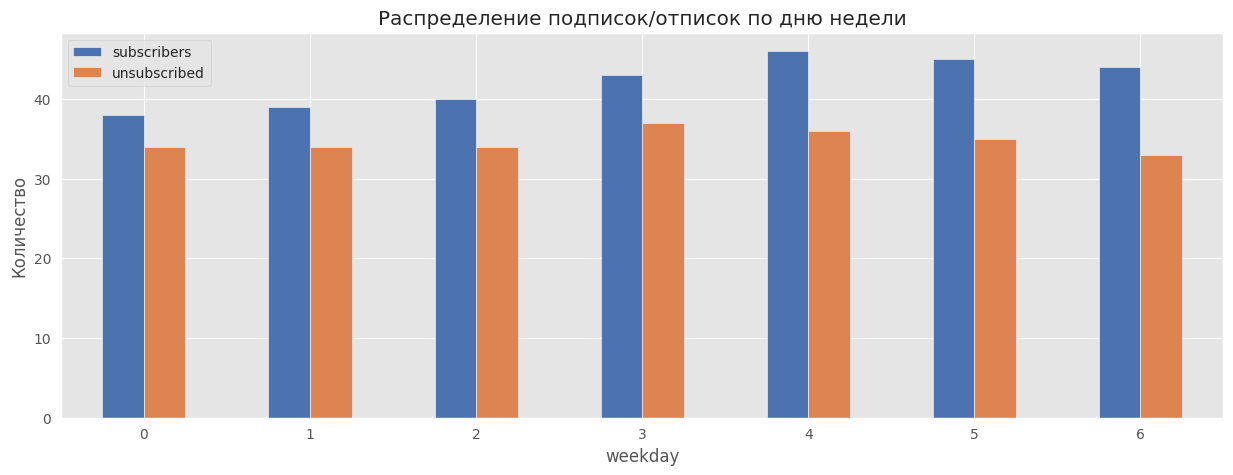

In [ ]:
# строю график распределения
sub_unsub(group_week, 'subscribers', 'unsubscribed', 'weekday', 'дню недели')

Медианное значение притока пользователей по дню недели всегда превышает медианное значение оттока.

**Вывод по сету sub_det**

1. В ходе исследовательсокого анализа датасета sub_det принято решение не удалять выбросы, так как эти данные могут пригодиться в дальнейшем исследовании.
2. Наибольший приток людей в канал наблюдается в пятницу и субботу.
3. Самый низкий отток также в воскресение.

### Датасет posts

**Распределение по просмотрам**

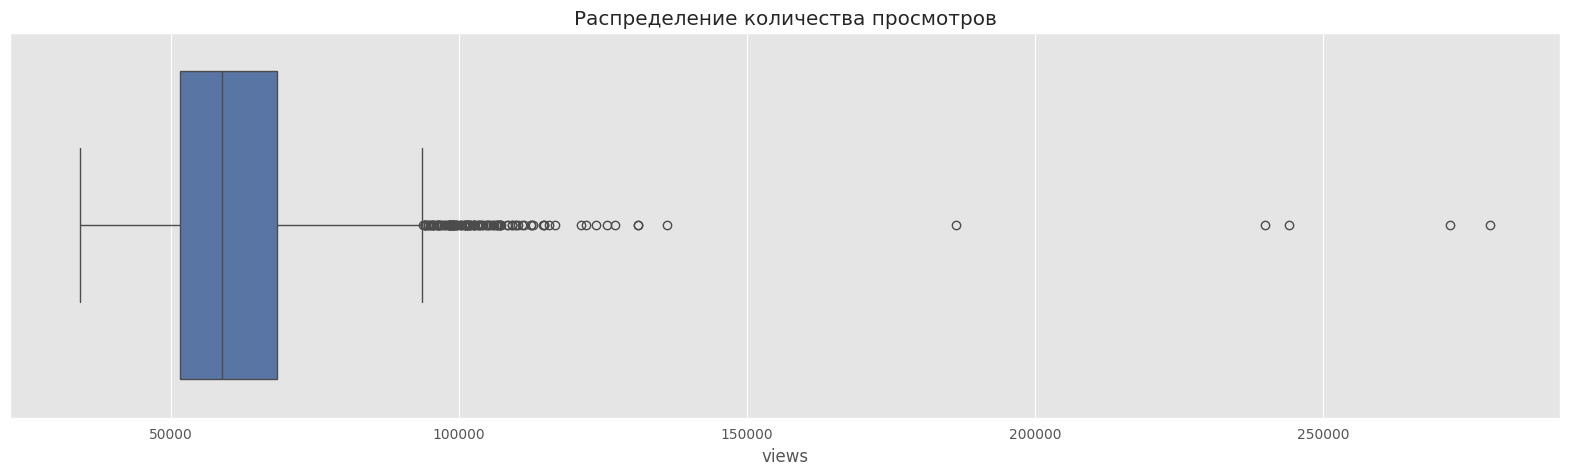

In [ ]:
# строю диаграмму размаха
plt.figure(figsize=(20, 5))
plt.title('Распределение количества просмотров')
sns.boxplot(posts['views'], orient='h')
plt.show()

In [ ]:
# посчитаем значения квантилей
q1 = np.quantile(posts['views'], .25)
q3 = np.quantile(posts['views'], .75)
iqr = q3 - q1

# рассчитываем базовую нижнюю и верхнюю границу диапазона для исключения выбросов
upper_change_view = q3 + 1.5 * iqr
lower_change_view = q1 - 1.5 * iqr

# создаем переменную, в которой не будет выбросов
post_views_outliers = posts.query('(views > @lower_change_view) and (views < @upper_change_view)')

print('Потери при удалении выбросов:', round((1- len(post_views_outliers)/posts.shape[0])*100, 2), '%')

Потери при удалении выбросов: 4.61 %


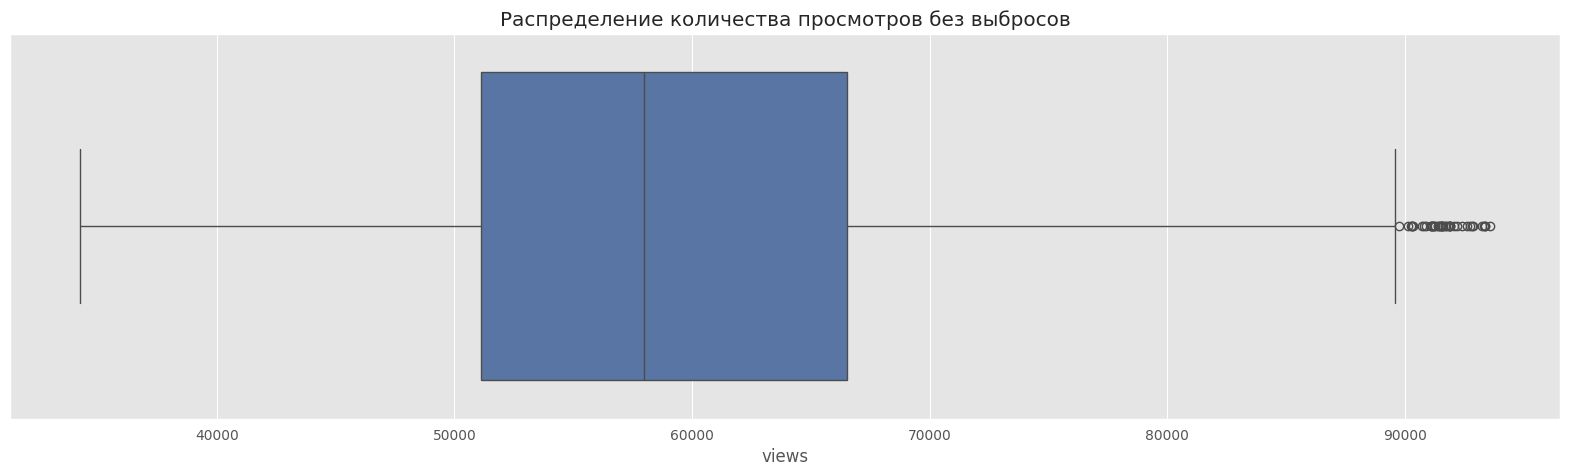

In [ ]:
# строим диаграмму размаха с отсечением выбросов
plt.figure(figsize=(20, 5))
sns.boxplot(post_views_outliers['views'], orient='h')
plt.title('Распределение количества просмотров без выбросов')
plt.show()

В очищенном датасете просмотры колеблются до 90к. Чаще всего за день просмотры достигают 50к-65к. При очистке от выбросов мы потеряем 4.61 % данных.

**Распределение по репостам**

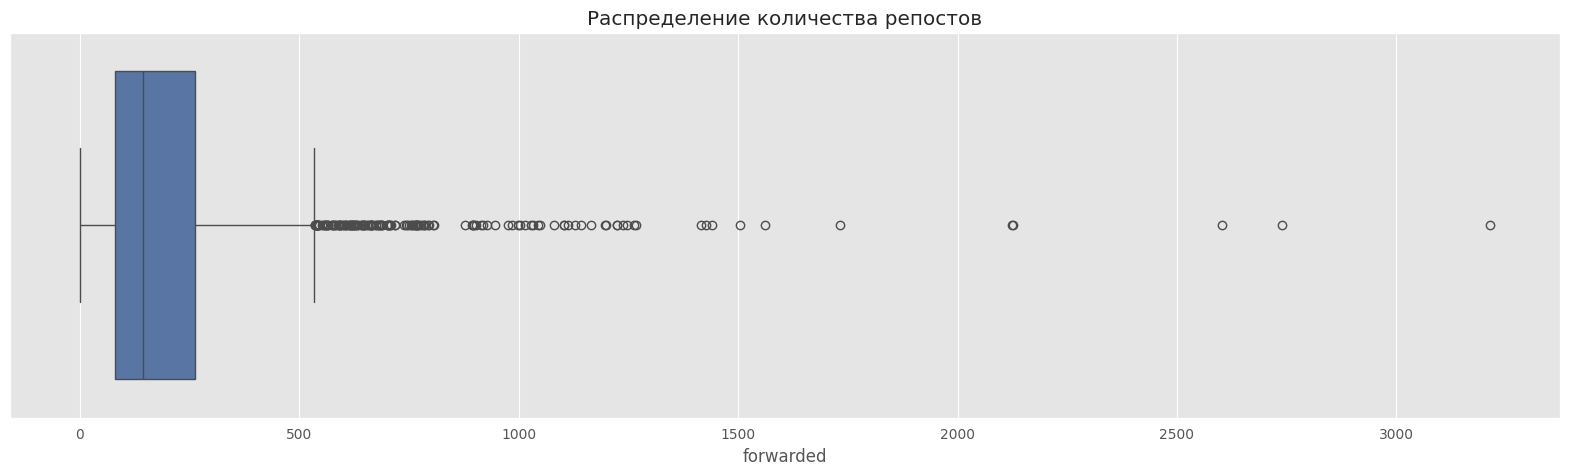

In [ ]:
# строим диаграмму размаха
plt.figure(figsize=(20, 5))
plt.title('Распределение количества репостов')
sns.boxplot(posts['forwarded'], orient='h')
plt.show()

In [ ]:
# посчитаем значения квантилей
q1 = np.quantile(posts['forwarded'], .25)
q3 = np.quantile(posts['forwarded'], .75)
iqr = q3 - q1

# рассчитываем базовую нижнюю и верхнюю границу диапазона для исключения выбросов
upper_change_rep = q3 + 1.5 * iqr
lower_change_rep = q1 - 1.5 * iqr

# создаем переменную, в которой не будет выбросов
post_forwarded_outliers = posts.query('(forwarded > @lower_change_rep) and (forwarded < @upper_change_rep)')

print('Потери при удалении выбросов:', round((1- len(post_forwarded_outliers)/posts.shape[0])*100, 2), '%')

Потери при удалении выбросов: 5.97 %


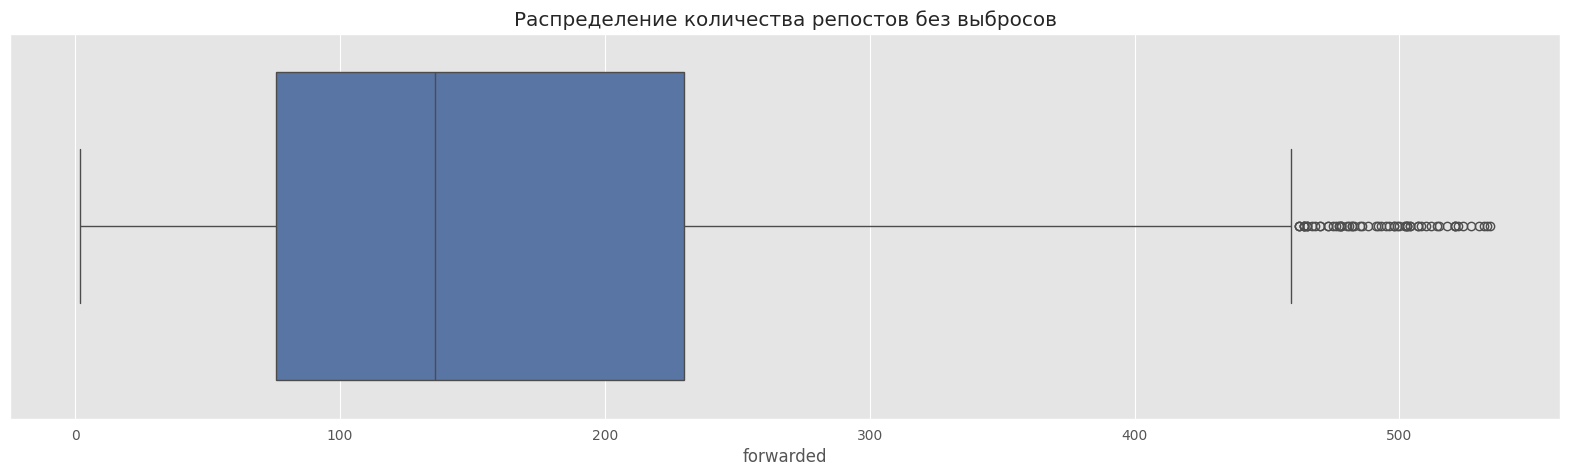

In [ ]:
# строем диаграмму размаха с отсечением выбросов
plt.figure(figsize=(20, 5))
sns.boxplot(post_forwarded_outliers['forwarded'], orient='h')
plt.title('Распределение количества репостов без выбросов')
plt.show()

В очищенном датасете репосты колеблются от 0 до 450. Чаще всего за день репостят 80-220 раз. При очистке от выбросов мы потеряем 6 % данных.

**Распределение по реакциям**

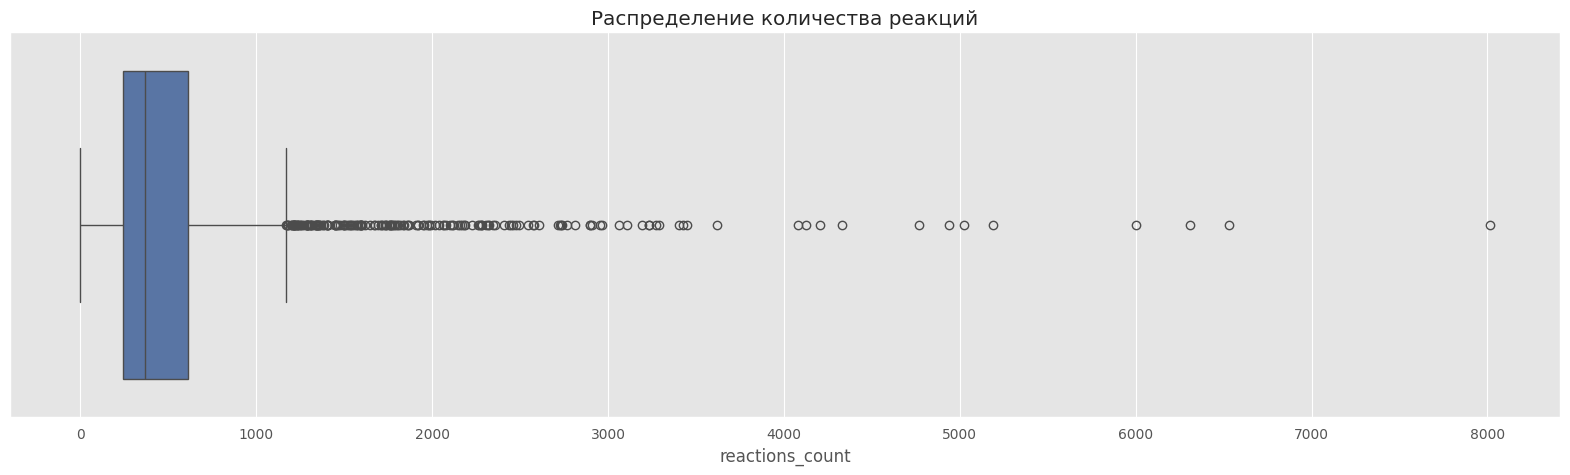

In [ ]:
# строим диаграмму размаха
plt.figure(figsize=(20, 5))
plt.title('Распределение количества реакций')
sns.boxplot(posts['reactions_count'], orient='h')
plt.show()

In [ ]:
# посчитаем значения квантилей
q1 = np.quantile(posts['reactions_count'], .25)
q3 = np.quantile(posts['reactions_count'], .75)
iqr = q3 - q1

# рассчитываем базовую нижнюю и верхнюю границу диапазона для исключения выбросов
upper_change_react = q3 + 1.5 * iqr
lower_change_react= q1 - 1.5 * iqr

# создаем переменную, в которой не будет выбросов
post_reactions_count_outliers = posts.query('(reactions_count > @lower_change_react) and (reactions_count < @upper_change_react)')

print('Потери при удалении выбросов:', round((1- len(post_reactions_count_outliers)/posts.shape[0])*100, 2), '%')

Потери при удалении выбросов: 6.96 %


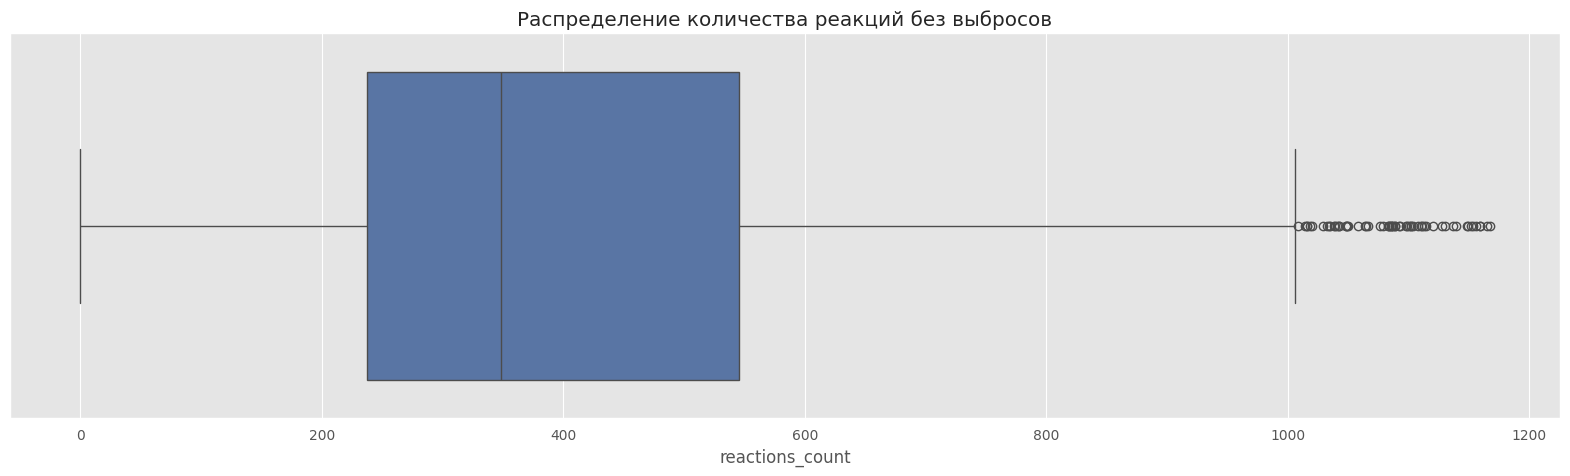

In [ ]:
# строим диаграмму размаха с отсечением выбросов
plt.figure(figsize=(20, 5))
sns.boxplot(post_reactions_count_outliers['reactions_count'], orient='h')
plt.title('Распределение количества реакций без выбросов')
plt.show()

В очищенном датасете реакции колеблются до 1000. Чаще всего за день оставляют реакций 250-550. При очистке от выбросов мы потеряем 7 % данных.

**Распределение по комментариям**

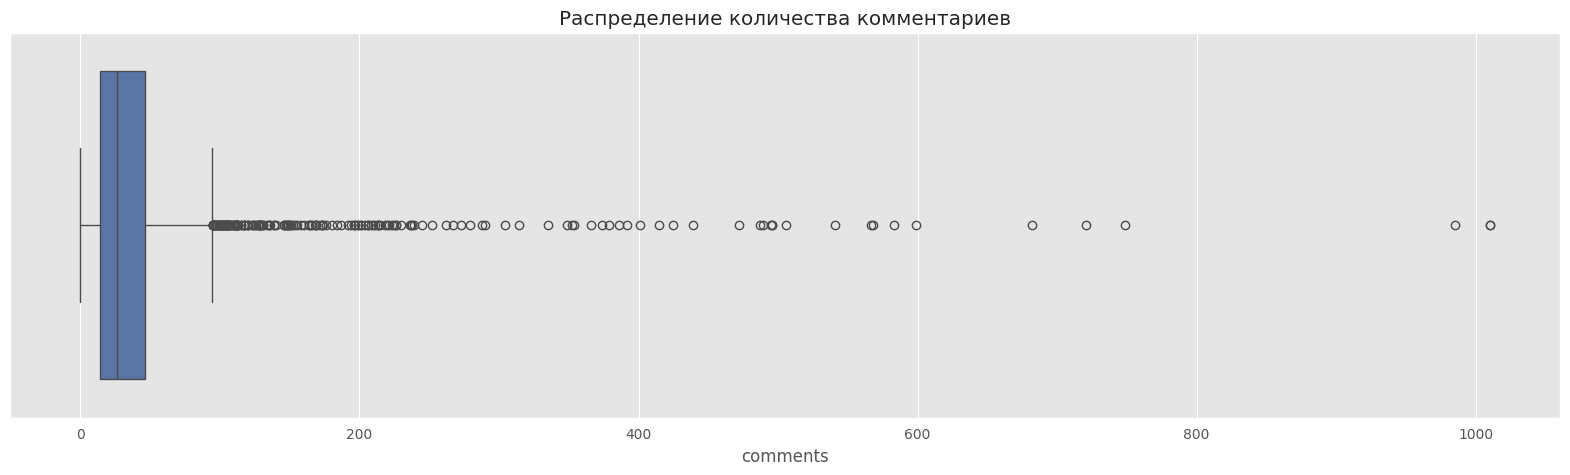

In [ ]:
# строим диаграмму размаха
plt.figure(figsize=(20, 5))
plt.title('Распределение количества комментариев')
sns.boxplot(posts['comments'], orient='h')
plt.show()

In [ ]:
# посчитаем значения квантилей
q1 = np.quantile(posts['comments'], .25)
q3 = np.quantile(posts['comments'], .75)
iqr = q3 - q1

# рассчитываем базовую нижнюю и верхнюю границу диапазона для исключения выбросов
upper_change_com = q3 + 1.5 * iqr
lower_change_com= q1 - 1.5 * iqr

# создаем переменную, в которой не будет выбросов
post_comments_outliers = posts.query('(comments > @lower_change_com) and (comments < @upper_change_com)')

print('Потери при удалении выбросов:', round((1- len(post_comments_outliers)/posts.shape[0])*100, 2), '%')

Потери при удалении выбросов: 7.67 %


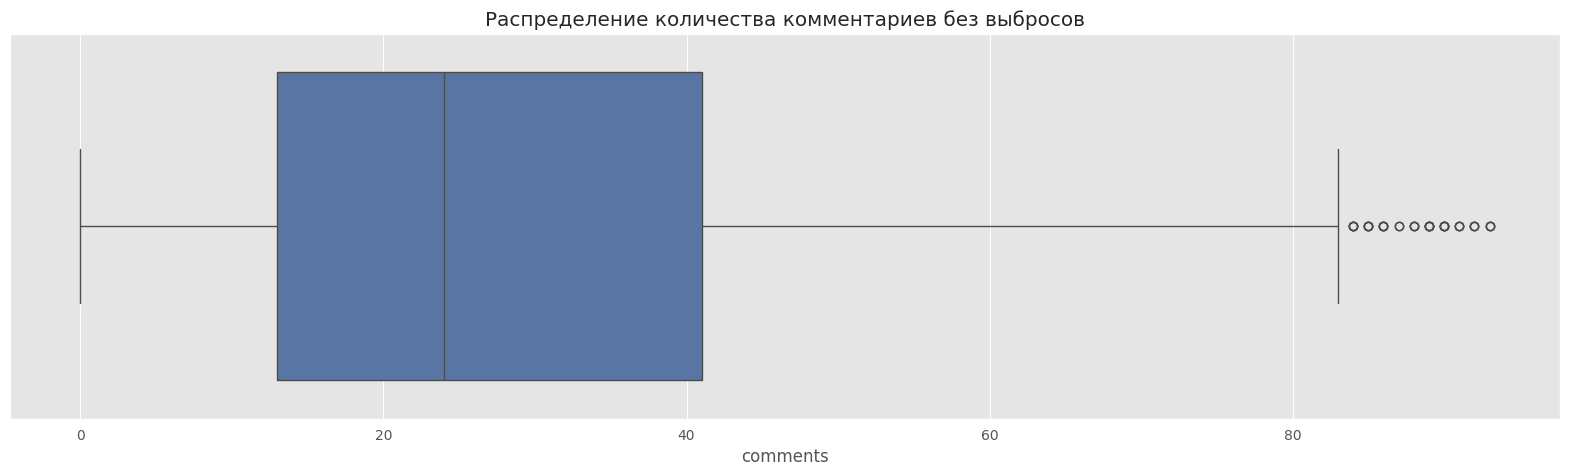

In [ ]:
# строим диаграмму размаха с отсечением выбросов
plt.figure(figsize=(20, 5))
sns.boxplot(post_comments_outliers['comments'], orient='h')
plt.title('Распределение количества комментариев без выбросов')
plt.show()

В очищенном датасете комментарии колеблются до 85 штук на пост. Чаще всего за день комменты достигают 15-40. При очистке от выбросов мы потеряем 7.67 % данных.

**Распределение по времени публикации постов**

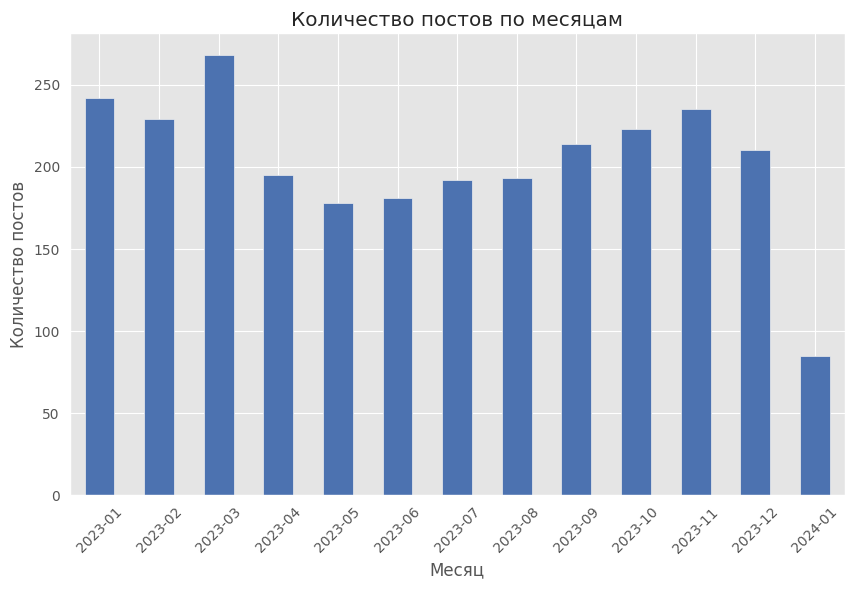

In [ ]:
# извлечение месяца из даты
posts['month'] = posts['date'].dt.to_period('M').astype(str)

# группировка по месяцам и подсчет количества постов
posts_by_month = posts.groupby('month')['id'].count()

# построение графика
plt.figure(figsize=(10, 6))
posts_by_month.plot(kind='bar')
plt.title('Количество постов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество постов')
plt.xticks(rotation=45)
plt.show()

Маленькое количество постов в январе 2024 года обосновывается тем, что в наших данных январь представлен не полностью, а только первые 2 недели.

**Вывод по датасету posts**
1. Во всех действиях пользователей (просмотры, комментарии, реакции и репосты) присутствуют выбросы и аномальные значения. Это нормально, так как активность людей может зависеть от контента канала и от общих инфоповодов (например, глобальных трендов на новинки типа Барби).
2. Количество постов по месяцам в целом не имеет всплесков (разве что в месяца поздней весны и лета количество постов уменьшилось).

### Датасет reposts_pars

**Столбец channel**

Посчитаем, сколько в датасете каналов.

In [ ]:
reposts_pars.channel.nunique()

49

Выведем каналы по упоминаниям телеграм-канала Кинопоиска.

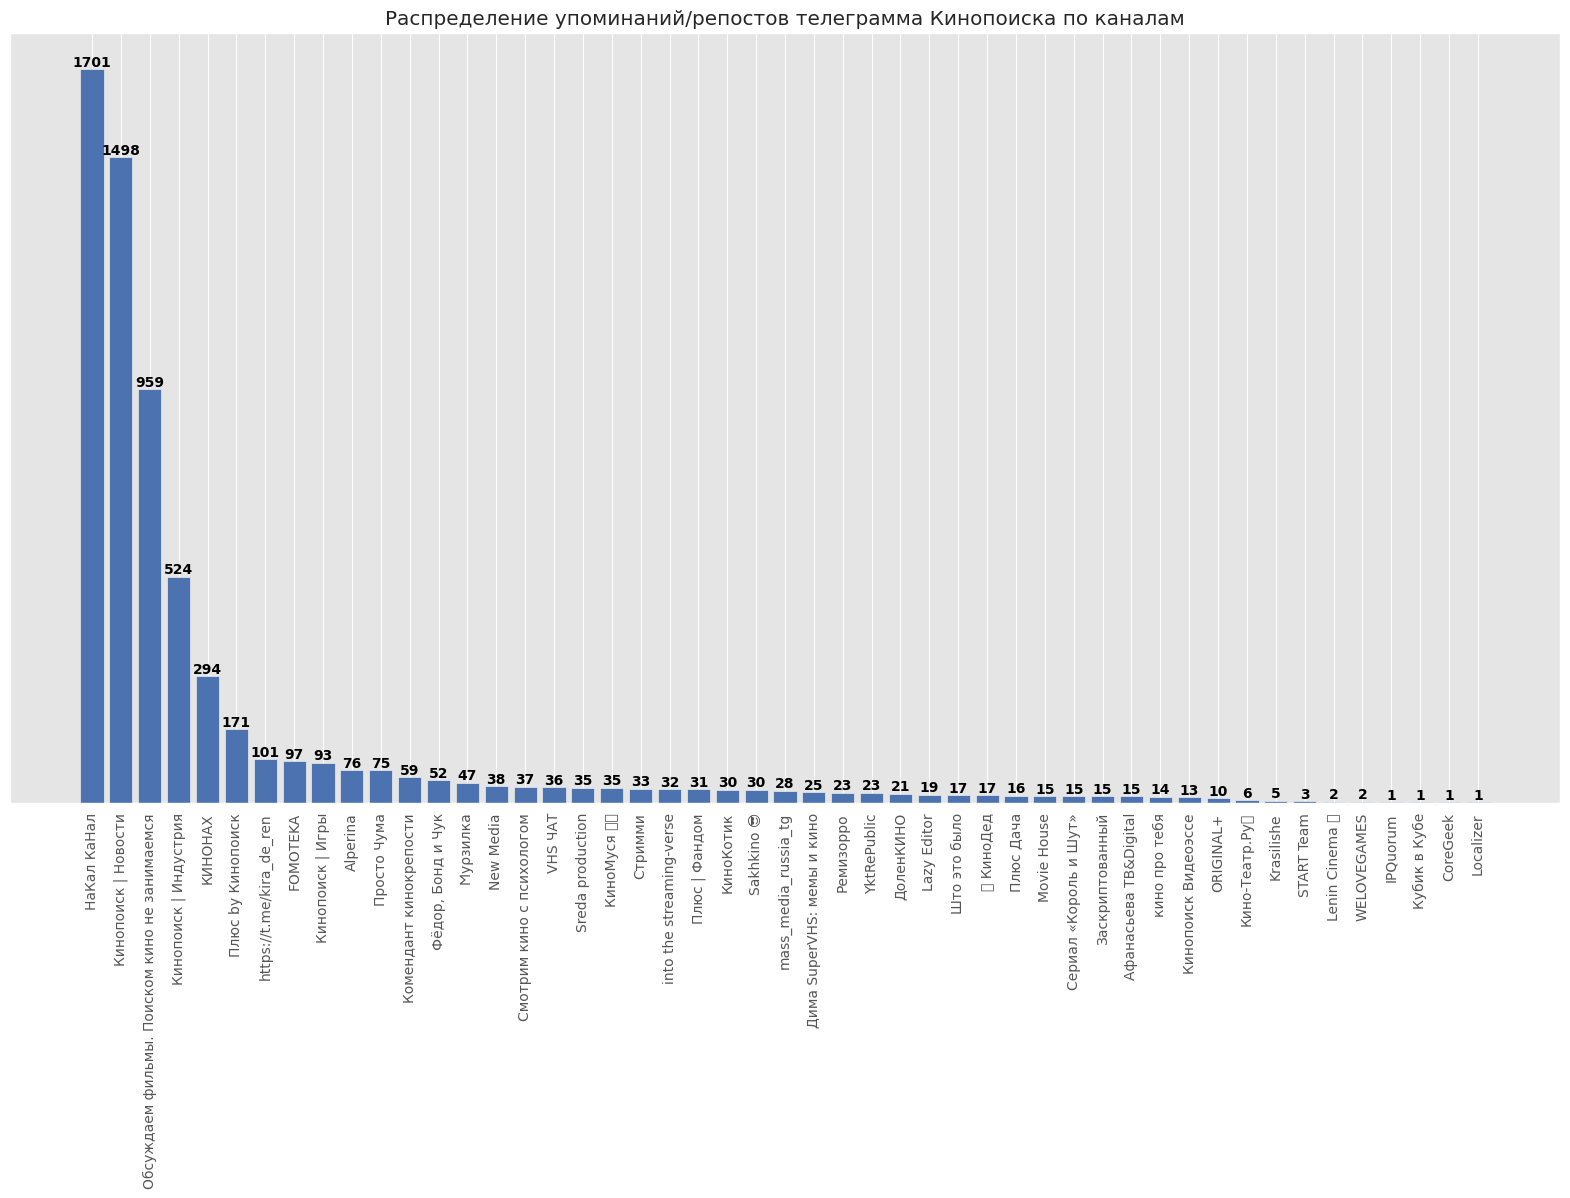

In [ ]:
reposts_by_channel = reposts_pars.groupby('channel').date.count().reset_index().sort_values(by='date', ascending=False)
plt.figure(figsize=(20, 10))
plt.bar(reposts_by_channel.channel, reposts_by_channel.date)

for x, y, tex in zip(reposts_by_channel.channel, reposts_by_channel.date, reposts_by_channel.date):
    t = plt.text(x, y, int(tex),
                 horizontalalignment='center',
                 rotation='horizontal',
                 verticalalignment='bottom',
                 fontdict={'color':'black', 'weight':'bold'})

plt.title('Распределение упоминаний/репостов телеграмма Кинопоиска по каналам')
plt.xticks(rotation=90)

ax = plt.gca()
ax.get_yaxis().set_visible(False)

plt.show()

Неожиданно по упоминаниям лидирует НаКал КаНал - канал о событиях в мире. Далее три места занимают каналы сервиса Кинопоиск.

**Столбец type_attachment**




Посчитаю, какой тип прикрепленного документа преобладает в пересылаемых постах.

In [ ]:
reposts_pars.head()

channel     id                 date  \
0  Alperina  15639  2024-01-10 20:14:54   
1  Alperina  15609  2024-01-08 10:23:02   
2  Alperina  15561  2023-12-30 22:08:53   
3  Alperina  15493  2023-12-26 19:21:05   
4  Alperina  15466  2023-12-25 16:01:28   

                                                text type_attachment  
0  Сейчас про новую роль Лео ДиКаприо напишут все...         webpage  
1  Далее  - иностранная пресса. В ночи прошла цер...         webpage  
2  Год непростой. Утрат много. И под занавес года...         webpage  
3  Подводим итоги года вместе с  [Кинопоиском!](h...         webpage  
4  Сразу три сериала, впервые показанные на второ...           photo

In [ ]:
rep_type = reposts_pars.groupby('type_attachment').text.count().nlargest(3).reset_index()
rep_type.rename(columns={'text': 'count_type'}, inplace=True)
rep_type['ratio_type'] = rep_type['count_type'] / rep_type['count_type'].sum()

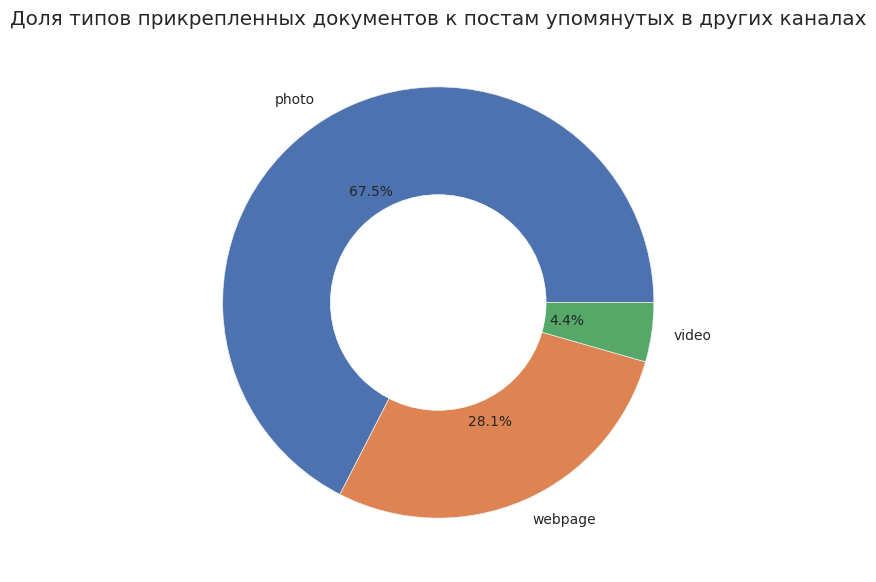

In [ ]:
plt.figure(figsize=(14, 7))
plt.title('Доля типов прикрепленных документов к постам упомянутых в других каналах')

# рисуем круговую диаграмму
plt.pie(rep_type.ratio_type, labels=rep_type.type_attachment.tolist(), autopct='%1.1f%%')

# добавляем белый круг в центр
circle=plt.Circle((0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

**Вывод по датасету reposts_pars**

1. В нашем датасете есть 49 каналов, которые репостят записи ТГ Кинопоиска (лидирует НаКал КаНал и каналы Кинопоиска).
2. Чаще всего репостят посты с фотографиями, реже - с видео.

### Датасет comments

**Распределение комментариев во времени**

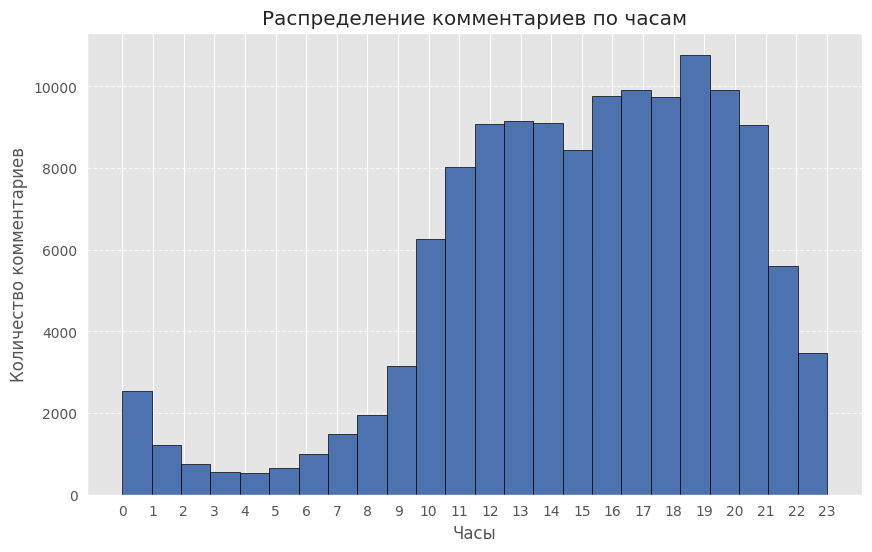

In [ ]:
# Построение гистограммы распределения комментариев по часам
plt.figure(figsize=(10, 6))
plt.hist(comments['hour'], bins=24, edgecolor='black')
plt.title('Распределение комментариев по часам')
plt.xlabel('Часы')
plt.ylabel('Количество комментариев')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показать график
plt.show()

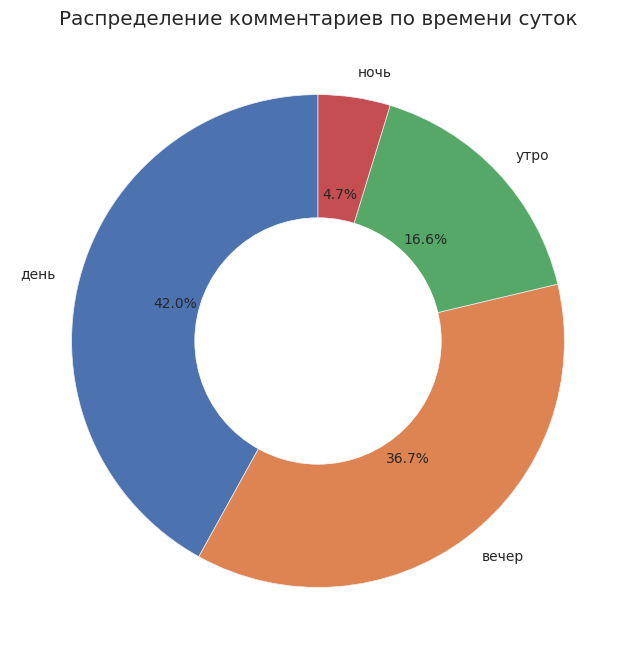

In [ ]:
# Создание столбца time_of_day
comments['time_of_day'] = pd.cut(comments['hour'], bins=[0, 6, 12, 18, 24], labels=['ночь', 'утро', 'день', 'вечер'], right=False)

# Подсчет количества комментариев для каждого времени суток
time_of_day_counts = comments['time_of_day'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(8, 8))
plt.pie(time_of_day_counts, labels=time_of_day_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Распределение комментариев по времени суток')

# добавляем белый круг в центр
circle=plt.Circle((0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

Наиболее часто пользователи оставляют комментарии днем (в целом постоянная активность начинается еще с 11 утра). На втором месте стоит вечер (больше всего комментов за день публикуется между 18 и 19 часами). Наименьшая активность ночью.

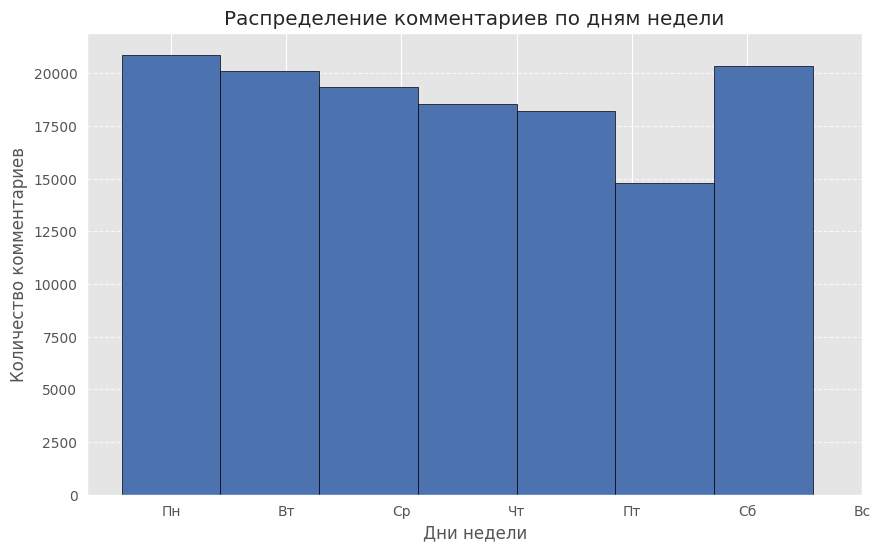

In [ ]:
# извлечение дней недели из столбца datetime
comments['weekday'] = comments['date_comment'].dt.weekday

# построение гистограммы распределения комментариев по дням недели
plt.figure(figsize=(10, 6))
plt.hist(comments['weekday'], bins=7, edgecolor='black', align='left')
plt.title('Распределение комментариев по дням недели')
plt.xlabel('Дни недели')
plt.ylabel('Количество комментариев')
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# показать график
plt.show()

**Вывод по датасету comments**

1. Количество комментариев по часам совпадает с часами активностью человека (больше всего комментят днем и вечером).
2. По дням недели является интересным то, что по субботам количество комментариев наименьшее.

## Анализ текста постов

**Предобработаем тексты**

In [ ]:
# предобработка текста
def preprocess_text(text):

    # удаление знаков препинания
    text = text.translate(str.maketrans('', '', string.punctuation))

    # удаление кавычек
    text = text.replace('«', '').replace('»', '')

    # удаление тире
    text = text.replace('—', '')

    # удаление ссылок
    text = re.sub(r'http\S+', '', text)

    # удаление слов getty images
    text = text.replace('getty', '')
    text = text.replace('images', '')
    text = text.replace('Подписывайтесь', '')
    text = text.replace('Кинопоиск', '')

    # приведение к нижнему регистру
    text = text.lower()

    # токенизация текста
    tokens = word_tokenize(text)

    # удаление стоп-слов и определенных слов (getty и images)
    stop_words = set(stopwords.words('russian'))
    exclude_words = set(['getty', 'images', 'Подписывайтесь', 'Кинопоиск'])
    tokens = [word for word in tokens if word not in stop_words and word not in exclude_words]

    return tokens

In [ ]:
# применение предобработки к столбцу 'text'
posts['processed_text'] = posts['text'].apply(preprocess_text)

morph = MorphAnalyzer()

# лемматизация текста
posts['processed_text'] = posts['processed_text'].apply(lambda x: [morph.parse(word)[0].normal_form for word in x])

# преобразование списка лемм в текст
posts['processed_text_str'] = posts['processed_text'].apply(lambda x: ' '.join(x))

**Применим кластеризацию**

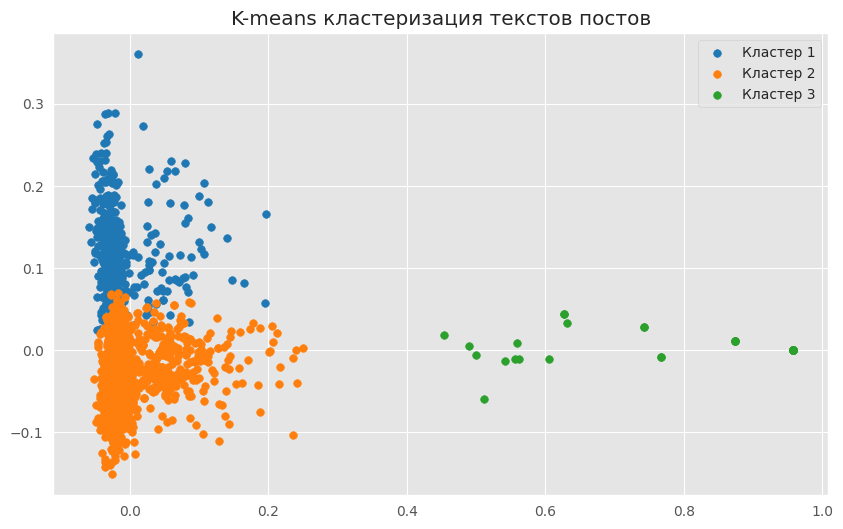

In [ ]:
# преобразование текстов в TF-IDF векторы
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(posts['processed_text_str'])

# применение K-means кластеризации
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# добавление меток кластеров в датасет
posts['cluster_label'] = kmeans.labels_

# визуализация результатов
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(X.toarray())
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster = scatter_plot_points[kmeans.labels_ == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], s=30, label=f'Кластер {i + 1}', color=colors[i])

plt.title('K-means кластеризация текстов постов')
plt.legend()

# Показать график
plt.show()

На данном этапе уже видно, что самый малочисленный кластер является и самым обособленным. Изучим подробнее.

In [ ]:
# конвертируем стоп слова в список
stop_words_list = list(set(stopwords.words('russian'))) + ['getty', 'images', 'Подписывайтесь', 'Кинопоиск']

cluster_labels = posts['cluster_label']

# Создадим словарь, где ключи - это метки кластеров, а значения - это списки текстов для каждого кластера
cluster_posts = {i: [] for i in set(cluster_labels)}

# Заполним словарь текстами
for i, text in enumerate(posts['processed_text_str']):
    cluster_posts[cluster_labels[i]].append(text)

# Теперь у нас есть cluster_posts, и мы можем использовать его в коде для анализа ключевых слов
for i, cluster_texts in cluster_posts.items():
    # Инициализация CountVectorizer с учетом стоп-слов
    vectorizer = CountVectorizer(stop_words=stop_words_list)

    # Преобразование текстов в матрицу слов
    word_matrix = vectorizer.fit_transform(cluster_texts)

    # Получение списка слов
    feature_names = vectorizer.get_feature_names_out()

    # Подсчет частоты встречаемости каждого слова в кластере
    word_frequencies = word_matrix.sum(axis=0)

    # Создание словаря частот
    frequency_dict = dict(zip(feature_names, word_frequencies.tolist()[0]))

    # Вывод ключевых слов для кластера
    print(f"Ключевые слова для кластера {i}:")
    for word, frequency in sorted(frequency_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"{word}: {frequency}")
    print()

Ключевые слова для кластера 0:
сериал: 461
новый: 241
сезон: 219
который: 189
наш: 175
серия: 168
рассказывать: 152
главный: 142
выйти: 137
смотреть: 125

Ключевые слова для кластера 1:
фильм: 1280
который: 673
наш: 553
год: 511
новый: 510
это: 415
хороший: 308
рассказывать: 297
кино: 295
главный: 279

Ключевые слова для кластера 2:
ждать: 31
ответ: 27
коммент: 26
ваш: 23
комментарий: 5
идея: 2
летний: 2
самый: 2
смотреть: 2
фильм: 2



Определим названия для кластеров, по ключевым словам видно выделение постов о сериалах (слова сериал, сезон), фильмах (фильм, кино) и действиях пользователей (ответ, коммент, комментарий).

In [ ]:
# создаем словарь, где ключ - это метка кластера, а значение - это его популярное слово
cluster_keywords = {
    0: "сериал",
    1: "фильм",
    2: "коммент"
}

# добавляем столбец cluster_name в датасет
posts['cluster_name'] = posts['cluster_label'].map(cluster_keywords)

# выводим обновленный датасет
posts.head()

id                date  \
0  37007 2024-01-13 21:01:48   
1  37006 2024-01-13 17:01:29   
2  37005 2024-01-13 14:04:55   
3  37004 2024-01-13 12:28:47   
4  37003 2024-01-13 11:01:07   

                                                text     views  forwarded  \
0  Фильм дня — [**«В паутине»**](https://www.kino...  103704.0      566.0   
1  Роберт Дауни-младший [считает](https://variety...  103564.0      114.0   
2  **Первый дайджест наших подкастов в этом году!...   97973.0       16.0   
3  В видеоиграх камера нужна не только для повест...   96919.0      179.0   
4  В этом году ждем много всего интересного! \n\n...   96558.0      324.0   

   reactions_count  comments type_attachment    month  \
0              504        20           photo  2024-01   
1             6001       106           photo  2024-01   
2              166         6           photo  2024-01   
3              284         8         webpage  2024-01   
4              803        37           photo  2024-01   

                                      processed_text  \
0  [фильм, день, паутина, 🕸, кинорежиссёр, ким, к...   
1  [роберт, даунимладший, считать, роль, тони, ст...   
2  [первый, дайджест, наш, подкаст, год, 👀, крупн...   
3  [видеоигра, камера, нужный, повествование, доп...   
4  [год, ждать, интересный, дюна, 2, мистер, мисс...   

                                  processed_text_str  cluster_label  \
0  фильм день паутина 🕸 кинорежиссёр ким который ...              1   
1  роберт даунимладший считать роль тони старка ф...              1   
2  первый дайджест наш подкаст год 👀 крупный план...              1   
3  видеоигра камера нужный повествование дополнят...              1   
4  год ждать интересный дюна 2 мистер миссис смит...              1   

  cluster_name  
0        фильм  
1        фильм  
2        фильм  
3        фильм  
4        фильм

In [ ]:
posts['cluster_name'].value_counts()

фильм      2036
сериал      578
коммент      31
Name: cluster_name, dtype: int64

Какие посты ярче влияют на подписки и отписки?

In [ ]:
# определим даты скачков подписок (более 200)
sub_jump_dates = sub_det[sub_det['subscribers'] > 180]['datetime'].reset_index(drop=True)

# определим даты скачков отписок (более 150)
unsub_jump_dates = sub_det[sub_det['unsubscribed'] > 160]['datetime'].reset_index(drop=True)

In [ ]:
# создаем копию датасета
posts_sub_unsub = posts.copy()

# приведем формат дат в DataFrame posts к формату YYYY-MM-DD
posts_sub_unsub['date'] = pd.to_datetime(posts_sub_unsub['date']).dt.strftime('%Y-%m-%d')

# приведем формат дат в датах скачков подписок и отписок к формату YYYY-MM-DD
sub_det['date'] = pd.to_datetime(sub_det['datetime']).dt.date.astype(str)

# определяем даты скачков подписок (более 180)
sub_jump_dates = sub_det[sub_det['subscribers'] > 180]['date']

# определяем даты скачков отписок (более 160)
unsub_jump_dates = sub_det[sub_det['unsubscribed'] > 160]['date']

# теперь объединим DataFrame по дате
# объединение с дропом дубликатов
posts_in_sub_jump_dates = pd.merge(posts_sub_unsub, sub_jump_dates.drop_duplicates(), how='inner', left_on='date', right_on='date')
posts_in_unsub_jump_dates = pd.merge(posts_sub_unsub, unsub_jump_dates.drop_duplicates(), how='inner', left_on='date', right_on='date')

In [ ]:
# подсчет процентного распределения
percentage_distribution = posts_in_sub_jump_dates['cluster_name'].value_counts(normalize=True) * 100

# вывод процентного распределения
print('Процентное распределение категорий постов в дни скачков подписок:')
print(percentage_distribution)

Процентное распределение категорий постов в дни скачков подписок:
фильм      82.417582
сериал     17.111460
коммент     0.470958
Name: cluster_name, dtype: float64


In [ ]:
# подсчет процентного распределения
percentage_unsub_distribution = posts_in_unsub_jump_dates['cluster_name'].value_counts(normalize=True) * 100

# вывод процентного распределения
print('Процентное распределение категорий постов в дни скачков отписок:')
print(percentage_unsub_distribution)

Процентное распределение категорий постов в дни скачков отписок:
фильм      82.304527
сериал     17.078189
коммент     0.617284
Name: cluster_name, dtype: float64


Были определены кластеры, среди которых самым малочисленным, но обособленным является кластер по призыву к действиям.
Также было определено то, что в даты резких подписок и отписок распределение кластеров не является различным.

### Тематики постов понедельно
**Изучим понедельно посты, каких тематик, публикует Кинопоиск**

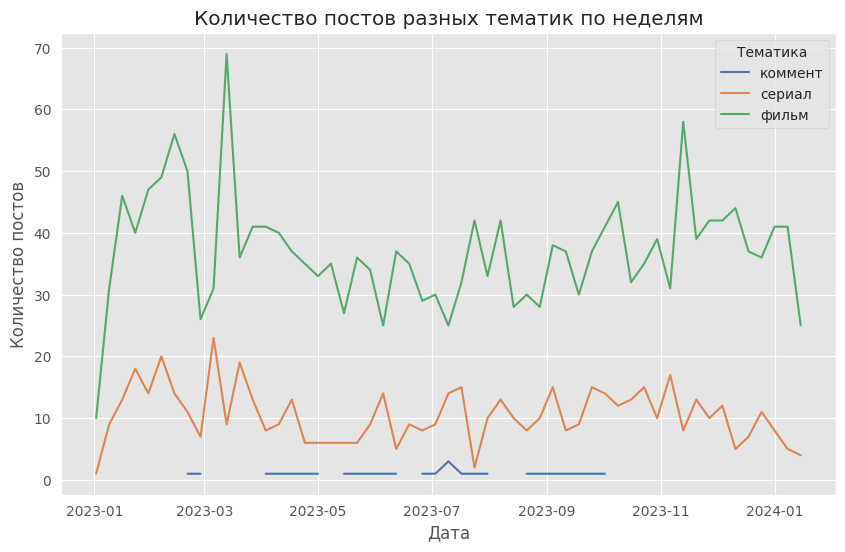

In [ ]:
# сгруппируем данные по тематикам и неделям
grouped_data = posts.groupby(['cluster_name', pd.Grouper(key='date', freq='W-Mon')]).size().unstack()

# построим график
plt.figure(figsize=(10, 6))

for cluster in grouped_data.index:
    plt.plot(grouped_data.columns, grouped_data.loc[cluster], label=cluster)

plt.title('Количество постов разных тематик по неделям')
plt.xlabel('Дата')
plt.ylabel('Количество постов')
plt.legend(title='Тематика')
plt.show()

В целом Кинопоиск чаще публикует посты о фильмах, чем о сериалах. Замечено малое количество постов по призыву к действию (синий показатель, название кластера "коммент").

### Файлы к постам

Изучим, какие файлы прикрепляют к тексту постов. И определим доли типов файлов прикрепленных к посту.

In [ ]:
posts_type_att = posts.groupby('type_attachment').id.count().reset_index()
posts_type_att.rename(columns={'id': 'count_posts'}, inplace=True)
posts_type_att['ratio_type'] = posts_type_att['count_posts'] / posts_type_att['count_posts'].sum()

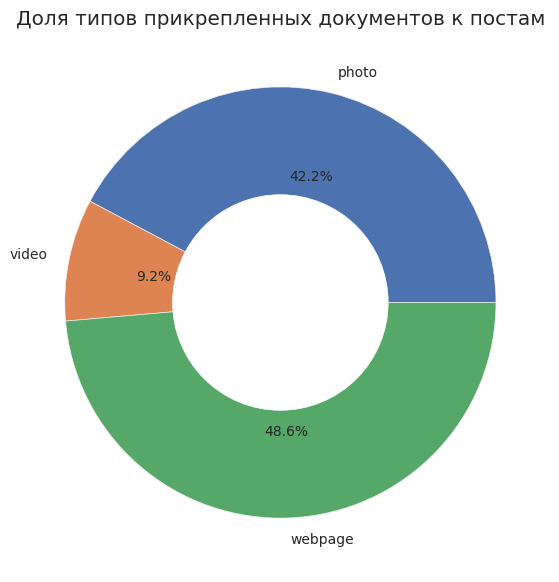

In [ ]:
plt.figure(figsize=(14, 7))
plt.title('Доля типов прикрепленных документов к постам')

# рисуем круговую диаграмму
plt.pie(posts_type_att.ratio_type, labels=posts_type_att.type_attachment.tolist(), autopct='%1.1f%%')

# добавляем белый круг в центр
circle=plt.Circle((0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

**Вывод по анализу текстов постов**

1. Стоить отметить, что кластеризация - не самый точный вариант для определения тематик, однако она сработала корректно и показала 3 тематики: фильмы ("фильм" - информация о фильмах, новинках, актерах, режиссерах), сериалы ("сериал" - о выходе сезонов, новых сериалах, продлениях сериалов) и призыв к действию ("коммент" - посты, в которых кинопоиск призывает пользователей проголосовать, оставить комментарий, поставить лайки, поделиться мнением по какой-то теме в комментариях).
2. Кластер "коммент" (посты с действиями) является самым малочисленным, однако наиболее ярко выделяется среди массива других постов.

## Категоризация столбцов

### Катeгоризация датасета posts

Какие мы выбрали параметры:
- тематика - `['category']`
- длина - `['text_length']`
- файл - `['type_attachment']`
- часть суток - `['day_part']`
- подписки - `['subscribers_cat']`
- отписки - `['unsubscribers_cat']`
- просмотры - `['view_cat']`
- реакции - `['reaction_cat']`
- комменты - `['comments_cat']`
- репосты - `['forwarded_cat']`

Создадим копию датасета с нужными столбцами `posts_categorize`.

In [ ]:
# создаем копию датасета
posts_categorize = posts.copy()

# добавляем столбец с датой без времени
posts_categorize['dat'] = pd.to_datetime(posts_categorize['date']).dt.date
posts_categorize['dat'] = pd.to_datetime(posts_categorize['dat'])

# добавляем столбец с номером недели
posts_categorize['week'] = posts_categorize['dat'].dt.dayofweek
posts_categorize.head()

id                date  \
0  37007 2024-01-13 21:01:48   
1  37006 2024-01-13 17:01:29   
2  37005 2024-01-13 14:04:55   
3  37004 2024-01-13 12:28:47   
4  37003 2024-01-13 11:01:07   

                                                text     views  forwarded  \
0  Фильм дня — [**«В паутине»**](https://www.kino...  103704.0      566.0   
1  Роберт Дауни-младший [считает](https://variety...  103564.0      114.0   
2  **Первый дайджест наших подкастов в этом году!...   97973.0       16.0   
3  В видеоиграх камера нужна не только для повест...   96919.0      179.0   
4  В этом году ждем много всего интересного! \n\n...   96558.0      324.0   

   reactions_count  comments type_attachment    month  \
0              504        20           photo  2024-01   
1             6001       106           photo  2024-01   
2              166         6           photo  2024-01   
3              284         8         webpage  2024-01   
4              803        37           photo  2024-01   

                                      processed_text  \
0  [фильм, день, паутина, 🕸, кинорежиссёр, ким, к...   
1  [роберт, даунимладший, считать, роль, тони, ст...   
2  [первый, дайджест, наш, подкаст, год, 👀, крупн...   
3  [видеоигра, камера, нужный, повествование, доп...   
4  [год, ждать, интересный, дюна, 2, мистер, мисс...   

                                  processed_text_str  cluster_label  \
0  фильм день паутина 🕸 кинорежиссёр ким который ...              1   
1  роберт даунимладший считать роль тони старка ф...              1   
2  первый дайджест наш подкаст год 👀 крупный план...              1   
3  видеоигра камера нужный повествование дополнят...              1   
4  год ждать интересный дюна 2 мистер миссис смит...              1   

  cluster_name        dat  week  
0        фильм 2024-01-13     5  
1        фильм 2024-01-13     5  
2        фильм 2024-01-13     5  
3        фильм 2024-01-13     5  
4        фильм 2024-01-13     5

**Длина постов**

In [ ]:
# добавление столбца с длиной текста
posts_categorize['text_length'] = posts_categorize['processed_text'].apply(len)

# определение квантилей для категоризации
quantiles = posts_categorize['text_length'].quantile([0, 0.33, 0.66, 1.0])

# создание нового столбца с категориями
posts_categorize['text_length_category'] = pd.cut(posts_categorize['text_length'], bins=quantiles, labels=['Короткий', 'Средний', 'Длинный'], include_lowest=True)

# вывод информации о длине текста и категориях
print(posts_categorize[['text_length', 'text_length_category']].head(10))

   text_length text_length_category
0           52              Длинный
1           69              Длинный
2           57              Длинный
3           28              Средний
4           29              Средний
5           66              Длинный
6           22              Средний
7           17             Короткий
8           62              Длинный
9           29              Средний


**Часть суток, в которую посты были выложены**

In [ ]:
# добавляем столбец с частью суток
posts_categorize['day_part'] = pd.to_datetime(posts_categorize['date']).dt.hour.apply(
    lambda x: 'Ночь' if 0 <= x < 6 else ('Утро' if 6 <= x < 12 else ('День' if 12 <= x < 18 else 'Вечер'))
)

# выводим примеры
print(posts_categorize[['date', 'day_part']].head(10))

                 date day_part
0 2024-01-13 21:01:48    Вечер
1 2024-01-13 17:01:29     День
2 2024-01-13 14:04:55     День
3 2024-01-13 12:28:47     День
4 2024-01-13 11:01:07     Утро
5 2024-01-12 21:00:00    Вечер
6 2024-01-12 18:35:51    Вечер
7 2024-01-12 16:34:22     День
8 2024-01-12 15:08:58     День
9 2024-01-12 13:02:53     День


Для категоризации значений возьмем интервалы из очищенных от выбросов датасетов.

**Просмотры**


In [ ]:
# задаю значения, по которым буду категоризировать просмотры
bins_view = [[-1], stat.quantiles(post_views_outliers.views, n=4, method='exclusive'), [max(posts.views)]]

# список списков перевожу в обычный список
bins_view  = list(itertools.chain(*bins_view))

# назаначаю значения для категорий
volume_view = ['Низкие', 'Средние', 'Выше среднего', 'Высокие']

# создаю столбец с категроиями подписок
posts_categorize['view_cat'] = pd.cut(posts.views, bins=bins_view, labels=volume_view)

**Репосты**

In [ ]:
# задаю значения, по которым буду категоризировать просмотры
bins_forw = [[-1], stat.quantiles(post_forwarded_outliers.forwarded, n=4, method='exclusive'), [max(posts.forwarded)]]

# список списков перевожу в обычный список
bins_forw  = list(itertools.chain(*bins_forw))

# назаначаю значения для категорий
volume_forw = ['Низкие', 'Средние', 'Выше среднего', 'Высокие']

# создаю столбец с категроиями подписок
posts_categorize['forwarded_cat'] = pd.cut(posts.forwarded, bins=bins_forw, labels=volume_forw)

**Реакции**

In [ ]:
# задаю значения, по которым буду категоризировать просмотры
bins_react = [[-1], stat.quantiles(post_reactions_count_outliers.reactions_count, n=4, method='exclusive'), [max(posts.reactions_count)]]

# список списков перевожу в обычный список
bins_react  = list(itertools.chain(*bins_react))

# назаначаю значения для категорий
volume_react = ['Низкие', 'Средние', 'Выше среднего', 'Высокие']

# создаю столбец с категроиями подписок
posts_categorize['reaction_cat'] = pd.cut(posts.reactions_count, bins=bins_react, labels=volume_react)

**Комментарии**

In [ ]:
# задаю значения, по которым буду категоризировать просмотры
bins_com = [[-1], stat.quantiles(post_comments_outliers.comments, n=4, method='exclusive'), [max(posts.comments)]]

# список списков перевожу в обычный список
bins_com  = list(itertools.chain(*bins_com))

# назаначаю значения для категорий
volume_com = ['Низкие', 'Средние', 'Выше среднего', 'Высокие']

# создаю столбец с категроиями подписок
posts_categorize['comments_cat'] = pd.cut(posts.comments, bins=bins_com, labels=volume_com)

### Категоризация столбцов подписки/отписки сета sub_det

Категоризацию столбцов проведем на основании очищенных от выбросов датасетов. Значения столбца разделим на четыре равные части по квартилям.

In [ ]:
# сгруппирую данные в сете по дате и части дня
sub_det_period = sub_det.groupby(['date', 'day_period'])['subscribers', 'unsubscribed'].sum().reset_index()
print(sub_det_period.shape)
sub_det_period.head()

(1516, 4)


date day_period  subscribers  unsubscribed
0  2023-01-01       Ночь          907            18
1  2023-01-01       Утро            6            14
2  2023-01-01       День          190             0
3  2023-01-01      Вечер          111             0
4  2023-01-02       Ночь           77             0

Убираем выбросы в столбце subscribers.

In [ ]:
# посчитаем значения квантилей
q1 = np.quantile(sub_det_period.subscribers, .25)
q3 = np.quantile(sub_det_period.subscribers, .75)
iqr = q3 - q1

# рассчитываю базовую нижнюю и верхнюю границу диапазона для исключения выбросов
upper_sub_period = q3 + 1.5 * iqr
lower_sub_period= q1 - 1.5 * iqr

# создам переменную, в которой будут данные без выбросов
sub_not_outliers_period = sub_det_period.query('(subscribers > @lower_sub_period) and (subscribers < @upper_sub_period)')

In [ ]:
bins_subscr_per = [[-1], stat.quantiles(sub_not_outliers_period.subscribers, n=4, method='exclusive'), [max(sub_det_period.subscribers)]]

# список списков перевожу в обычный список
bins_subscr_per = list(itertools.chain(*bins_subscr_per))

# назаначаю значения для категорий
volume_sub_per = ['Низкие', 'Средние', 'Выше среднего', 'Высокие']

# создаю столбец с категроиями подписок
sub_det_period['subscribers_cat'] = pd.cut(sub_det_period.subscribers, bins=bins_subscr_per, labels=volume_sub_per)

Проделываю тоже самое с отписками.

In [ ]:
# посчитаю значения квантилей
q1 = np.quantile(sub_det_period.unsubscribed, .25)
q3 = np.quantile(sub_det_period.unsubscribed, .75)
iqr = q3 - q1

# рассчитываю базовую нижнюю и верхнюю границу диапазона для исключения выбросов
upper_unsub_period = q3 + 1.5 * iqr
lower_unsub_period= q1 - 1.5 * iqr

# создам переменную, в которой будут данные без выбросов
sub_not_outliers_period = sub_det_period.query('(unsubscribed > @lower_unsub_period) and (unsubscribed < @upper_unsub_period)')

In [ ]:
bins_unsubscr = [[-1], stat.quantiles(sub_not_outliers_period.unsubscribed, n=4, method='exclusive'), [max(sub_det_period.unsubscribed)]]

# список списков перевожу в обычный список
bins_unsubscr = list(itertools.chain(*bins_unsubscr))

# назаначаю значения для категорий
volume_unsub_per = ['Низкие', 'Средние', 'Выше среднего', 'Высокие']

# создаю столбец с категроиями подписок
sub_det_period['unsubscribers_cat'] = pd.cut(sub_det_period.unsubscribed, bins=bins_unsubscr, labels=volume_unsub_per)

In [ ]:
# столбец date переведу в тип datetime
sub_det_period['date'] = pd.to_datetime(sub_det_period['date'])

In [ ]:
# объединяю датасеты posts_categorize и sub_det_corr
posts_categorize = posts_categorize.merge(sub_det_period, how='left', left_on=['dat', 'day_part'], right_on=['date', 'day_period'], suffixes=('', '_x'))
# удаляем ненужные столбцы
posts_categorize = posts_categorize.drop(columns=['date_x', 'day_period'])
posts_categorize.head()

id                date  \
0  37007 2024-01-13 21:01:48   
1  37006 2024-01-13 17:01:29   
2  37005 2024-01-13 14:04:55   
3  37004 2024-01-13 12:28:47   
4  37003 2024-01-13 11:01:07   

                                                text     views  forwarded  \
0  Фильм дня — [**«В паутине»**](https://www.kino...  103704.0      566.0   
1  Роберт Дауни-младший [считает](https://variety...  103564.0      114.0   
2  **Первый дайджест наших подкастов в этом году!...   97973.0       16.0   
3  В видеоиграх камера нужна не только для повест...   96919.0      179.0   
4  В этом году ждем много всего интересного! \n\n...   96558.0      324.0   

   reactions_count  comments type_attachment    month  \
0              504        20           photo  2024-01   
1             6001       106           photo  2024-01   
2              166         6           photo  2024-01   
3              284         8         webpage  2024-01   
4              803        37           photo  2024-01   

                                      processed_text  \
0  [фильм, день, паутина, 🕸, кинорежиссёр, ким, к...   
1  [роберт, даунимладший, считать, роль, тони, ст...   
2  [первый, дайджест, наш, подкаст, год, 👀, крупн...   
3  [видеоигра, камера, нужный, повествование, доп...   
4  [год, ждать, интересный, дюна, 2, мистер, мисс...   

                                  processed_text_str  cluster_label  \
0  фильм день паутина 🕸 кинорежиссёр ким который ...              1   
1  роберт даунимладший считать роль тони старка ф...              1   
2  первый дайджест наш подкаст год 👀 крупный план...              1   
3  видеоигра камера нужный повествование дополнят...              1   
4  год ждать интересный дюна 2 мистер миссис смит...              1   

  cluster_name        dat  week  text_length text_length_category day_part  \
0        фильм 2024-01-13     5           52              Длинный    Вечер   
1        фильм 2024-01-13     5           69              Длинный     День   
2        фильм 2024-01-13     5           57              Длинный     День   
3        фильм 2024-01-13     5           28              Средний     День   
4        фильм 2024-01-13     5           29              Средний     Утро   

  view_cat  forwarded_cat   reaction_cat   comments_cat  subscribers  \
0  Высокие        Высокие  Выше среднего        Средние         2491   
1  Высокие        Средние        Высокие        Высокие         2833   
2  Высокие         Низкие         Низкие         Низкие         2833   
3  Высокие  Выше среднего        Средние         Низкие         2833   
4  Высокие        Высокие        Высокие  Выше среднего         1324   

   unsubscribed subscribers_cat unsubscribers_cat  
0          1372         Высокие           Высокие  
1          1860         Высокие           Высокие  
2          1860         Высокие           Высокие  
3          1860         Высокие           Высокие  
4           926         Высокие           Высокие

## Корреляция

Для корреляции в датасете corr_posts оставлю следующие столбцы: 'cluster_label', 'text_length_category', 'type_attachment', 'day_part', 'subscribers_cat', 'unsubscribers_cat', 'forwarded_cat', 'view_cat', 'reaction_cat', 'comments_cat', 'week'. Удалю имеющиеся строки с пропусками.

In [ ]:
corr_posts = posts_categorize.dropna()
corr_posts = corr_posts[['cluster_label', 'text_length_category', 'type_attachment', 'day_part', 'subscribers_cat', \
                         'unsubscribers_cat', 'forwarded_cat', 'view_cat', 'reaction_cat', 'comments_cat', 'week']]

Поскольку в данных присутствуют категориальные переменные для поиска зависимости буду использовать коэффициент корреляции Phi_K.

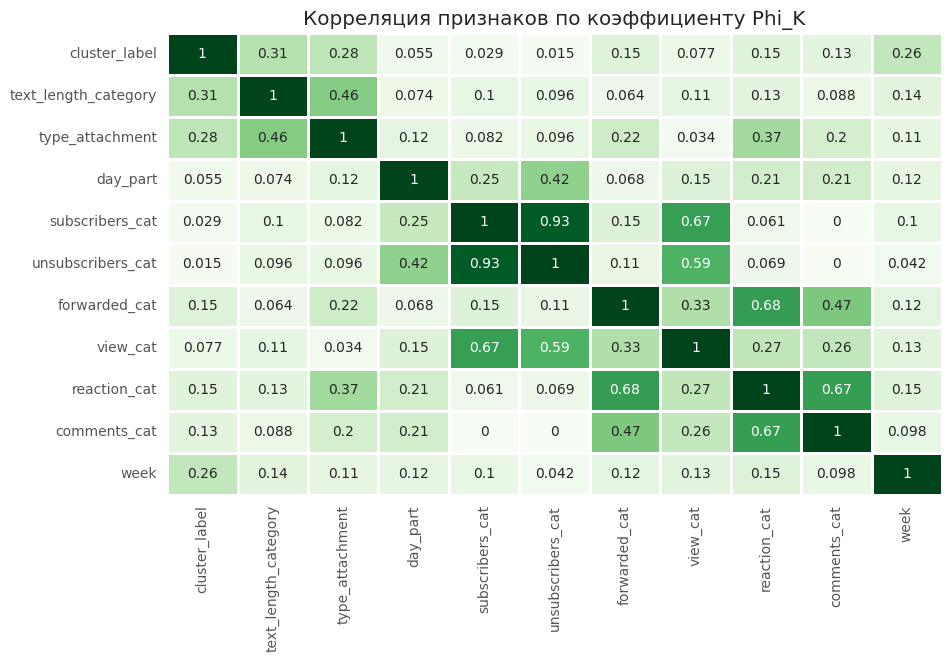

In [ ]:
# строю матрицу корреляции Phi_K
plt.figure(figsize=(10, 6))
plt.title('Корреляция признаков по коэффициенту Phi_K')
sns.heatmap(corr_posts.phik_matrix(verbose=False), linewidths=2, cbar=False, cmap='Greens', annot=True);

Наблюдается **весьма высокая (0.9-1.0)** взаимосвязь между числом подписок и отписок. Это логично, так как, чем больше людей в канале, там больше становится отписок.

**Заметная (0.5-0.7)** взаимосвязь наблюдается между:
1. просмотрами и подписками/отписками (контент стимулирует привлечение новых подписчиков, а с этим и отток)
3. репостами и реакциями (действительно, люди чаще реагируют и пересылают посты, которые вызвали у них сильные эмоции)
4. реакциями и комментариями (если контент интересен, то люди производят действия нескольких типов, например реакцию и коммент)

**Умеренная корреляция (0.3-0.5)** есть среди:
1. тематикой и длиной текста
2. длина текста и вид прикрепленного файла
3. реакции и вид прикрепленного файла
4. часть дня и отписки
5. репосты и просмотры
6. репосты и комментарии

На эти моменты стоит обратить внимание.

## Метрики

Необходимо определить метрики, которые будут определять анализ работы канала в разрезе недель и месяцев.

### Динамика подписок и отписок

**Помесячная динамика подписок и отписок**

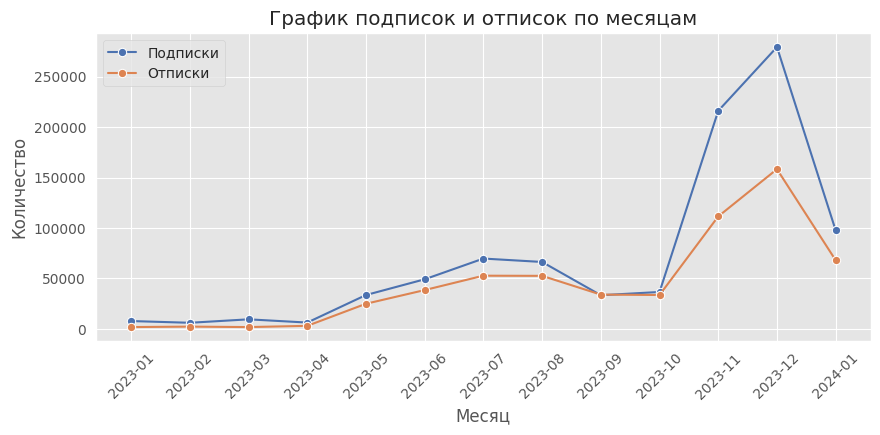

In [ ]:
# извлечение месяца из даты и преобразование в строку
sub_det['month'] = sub_det['datetime'].dt.to_period('M').astype(str)

# группировка данных по месяцам и подсчет суммарного количества подписок и отписок
grouped_data = sub_det.groupby('month').agg({'subscribers': 'sum', 'unsubscribed': 'sum'}).reset_index()

# построение линейного графика
plt.figure(figsize=(10, 4))
sns.lineplot(x='month', y='subscribers', data=grouped_data, marker='o', label='Подписки')
sns.lineplot(x='month', y='unsubscribed', data=grouped_data, marker='o', label='Отписки')

plt.title('График подписок и отписок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**График подписок и отписок по неделям**

In [ ]:
sub_det['date'] = pd.to_datetime(sub_det['date'])

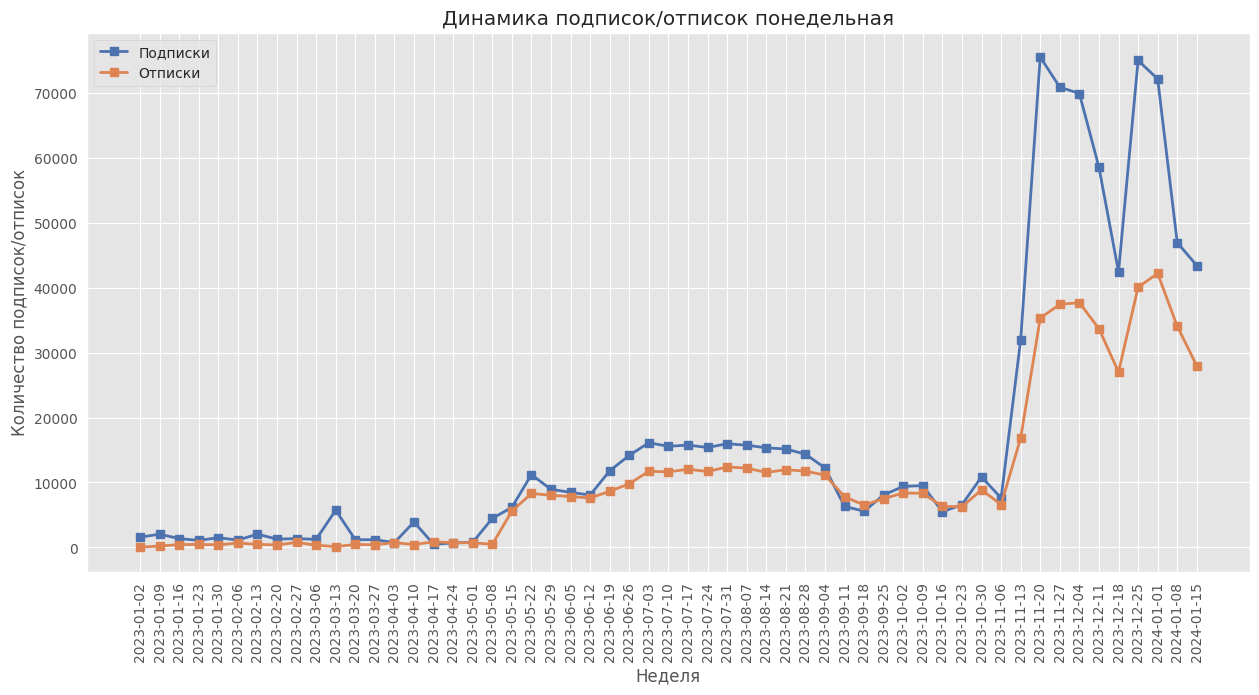

In [ ]:
sub_det_group = sub_det.groupby(pd.Grouper(key='date', freq='W-Mon')).agg({'subscribers': 'sum', 'unsubscribed': 'sum'}).reset_index()
plt.figure(figsize=(15, 7))
plt.plot(sub_det_group.date,
          sub_det_group.subscribers,
          linewidth=2,
          marker='s',
          label='Подписки'
          )

plt.plot(sub_det_group.date,
         sub_det_group.unsubscribed,
         linewidth=2,
         marker='s',
         label='Отписки'
         )

plt.title('Динамика подписок/отписок понедельная')
plt.xlabel('Неделя')
plt.ylabel('Количество подписок/отписок')
plt.legend()
plt.xticks (ticks=sub_det_group.date, rotation=90)

plt.show()

На графике видны недели, когда отписки превышали подписки.

In [ ]:
sub_gen_group = sub_gen.groupby(pd.Grouper(key='date', freq='W-Mon')).agg({'changes': 'median'}).reset_index()

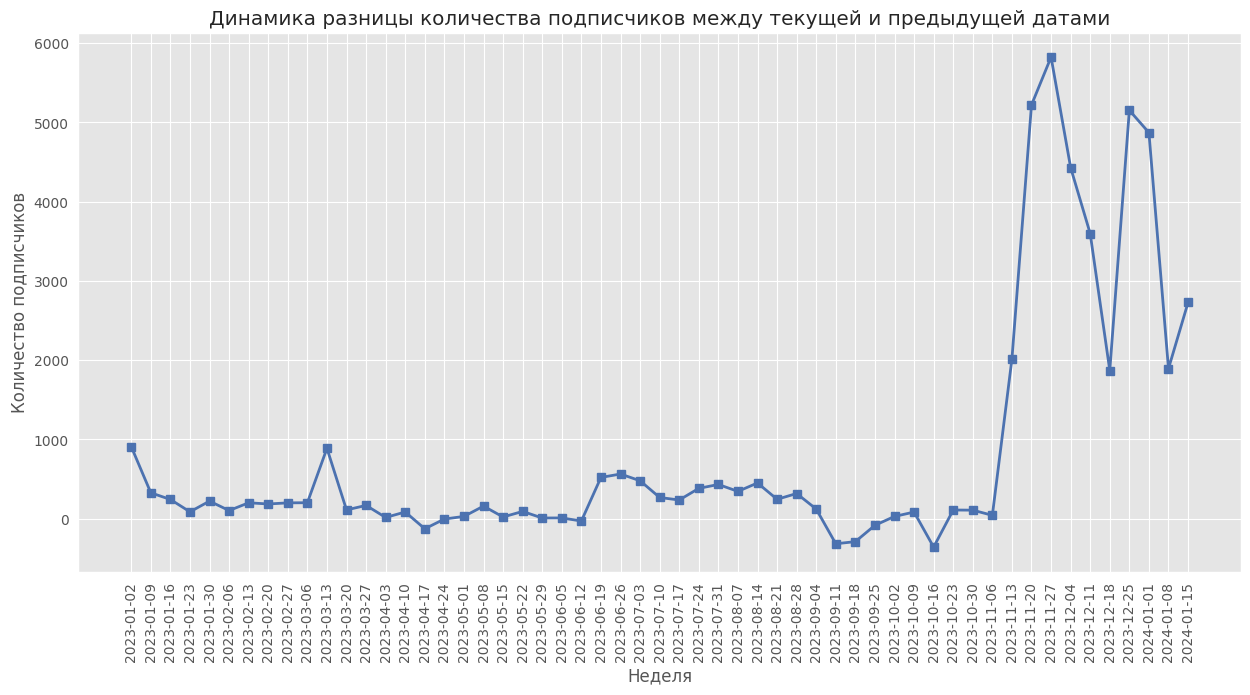

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(sub_gen_group.date,
          sub_gen_group.changes,
          linewidth=2,
          marker='s')

plt.title('Динамика разницы количества подписчиков между текущей и предыдущей датами')
plt.xlabel('Неделя')
plt.ylabel('Количество подписчиков')
plt.xticks (ticks=sub_gen_group.date, rotation=90)
plt.show()

С 2023-11-06 резкий рост разницы количества подписчиков между предыдущей и следующей неделями. Причина - выпуск бота. с 2023-11-27 резкий спад - отток тех, кто поигрался с ботом и им надоело, а посты в канале не заинтересовали. Далее снова рост, предполагаем, что в канале появились какие-то предновогодние активности, которые смогли завлечь аудиторию.

**Понедельный график отписок по части дня**

In [ ]:
# составляем таблицу для построения графиков
sub_det_group = (sub_det
                 .groupby([pd.Grouper(key='date', freq='W'), 'day_period'])
                 .agg({'unsubscribed': 'sum', 'subscribers': 'sum'}).reset_index())
day_period = sub_det_group.day_period.unique().tolist()
color = ['crimson', 'y', 'black', 'green']

In [ ]:
# графики динамики отписок по неделям в разрезе частей дня
def sub_unsub(column, color, txt):
  plt.figure(figsize=(15, 7))
  for dp, col in zip(day_period, color):
      plt.plot(sub_det_group.query("day_period == @dp").date.tolist(),
              [x for x in sub_det_group.query("day_period == @dp")[column].tolist()],
              linewidth=2, marker='s', color=col, label=dp)


  plt.title('Динамика {} по части суток'.format(txt))
  plt.xlabel('Неделя')
  plt.ylabel('Количество {}'.format(txt))
  plt.legend(fontsize=14)
  plt.xticks (ticks=sub_det_group.date, rotation=90)
  plt.show()

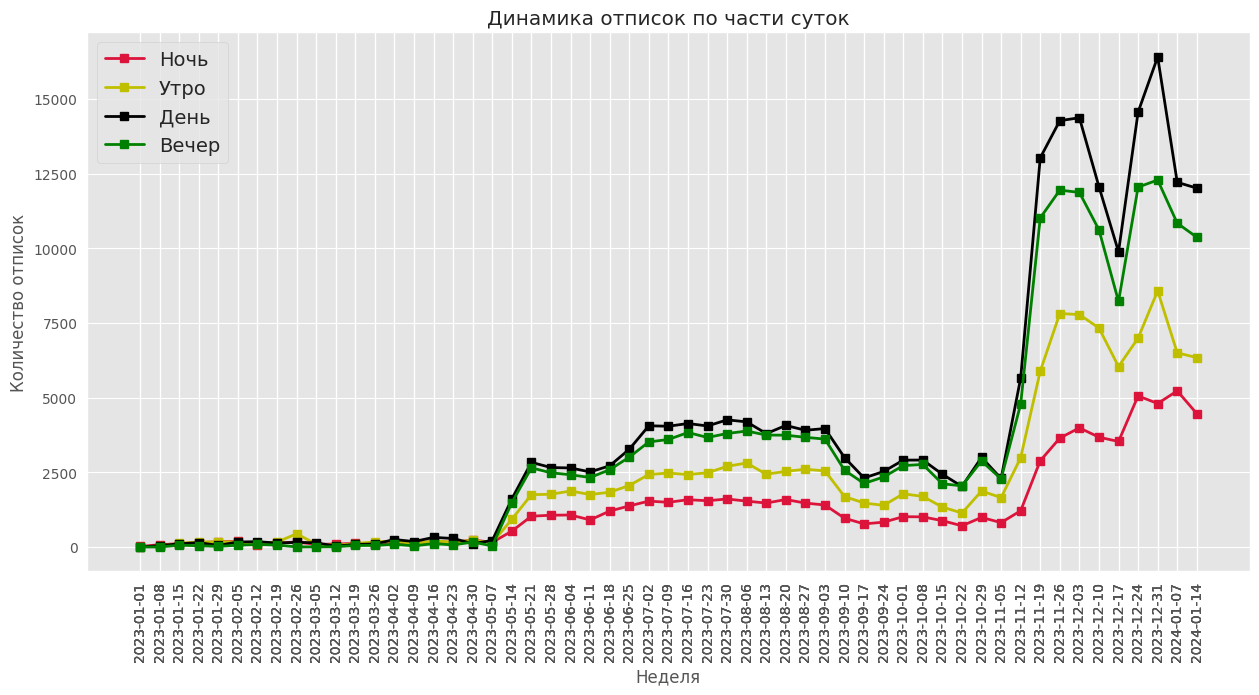

In [ ]:
sub_unsub('unsubscribed', color, 'отписок')

Днем отписываются больше, что вполне логично. Интересно, что произошло на неделе с 03-17 декабря, что произошел резкий спад отписок. Может в это время был интересный контент, а может в это же время снизолось и число подписчиков.

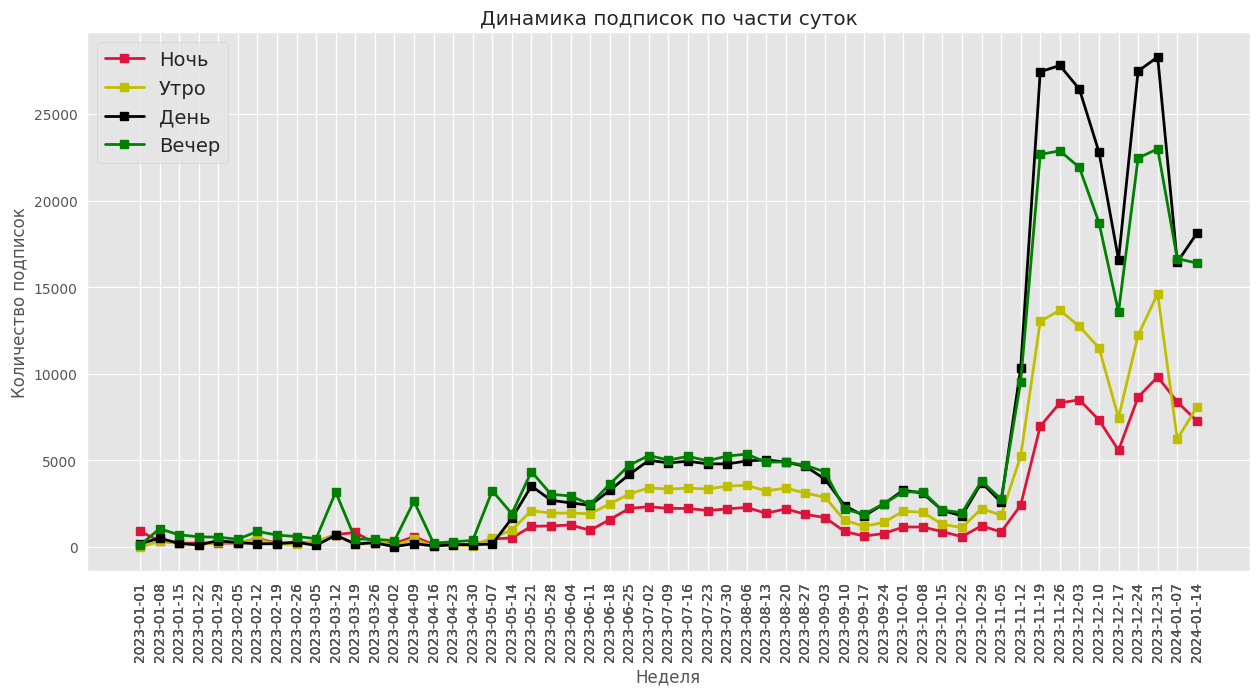

In [ ]:
sub_unsub('subscribers', color, 'подписок')

В эти же 2 недели был резкий спад подписок. Возможно, что в эти даты не было интересного контента для новых подписчиков или инфоповодов. Посмотрю, какого типа посты были в этот период.

In [ ]:
posts_categorize.query('dat >= "2023-12-03" and dat <= "2023-12-17"').groupby('cluster_name').id.count()

cluster_name
коммент     1
сериал     17
фильм      83
Name: id, dtype: int64

За это время больше всего было постов про фильмы. И всего 1 пост с привлечением.

**Вывод:**

Виден рост подписок в середине ноября в связи с появление бота, однако позже (в середине ноября) происходит резкое уменьшение подписок в связи с нерелевантным для пользователей контентом. Позже начинаются посты, посвященные новогодней тематике, также обновляется стикер-пак бота с мемами, и снова подписки повышаются.

### Охват

Создаем новый датасет, в котором будут следующие столбцы:
1. Год и месяц
2. Сумма просмотров за месяц
3. Количество постов
4. Среднее количество просмотров поста по каждому месяцу.

In [ ]:
view_month = posts_categorize.groupby('month').agg({'views': 'sum', 'id': 'count'}).reset_index()
view_month.rename(columns={'id': 'posts_count'}, inplace=True)
view_month['avg_views'] = round(view_month['views'] / view_month['posts_count']).astype(int)

Создаем функцию для построения графиков и строим графики общего охвата и среднего охвата по месяцам.

In [ ]:
def dynamic(df, column_1, column_2, title):
  plt.figure(figsize=(20, 8))
  plt.bar(df[column_1],
          df[column_2])

  # добавляем значения на график
  for x, y, tex in zip(df[column_1], df[column_2], df[column_2]):
      t = plt.text(x, y, int(tex),
                   horizontalalignment='center',
                   verticalalignment='bottom',
                   fontdict={'color':'black', 'weight':'bold'})

  plt.title(title)
  plt.xlabel('Месяц публикации постов')
  plt.ylabel('Количество просмотров')

  plt.show()

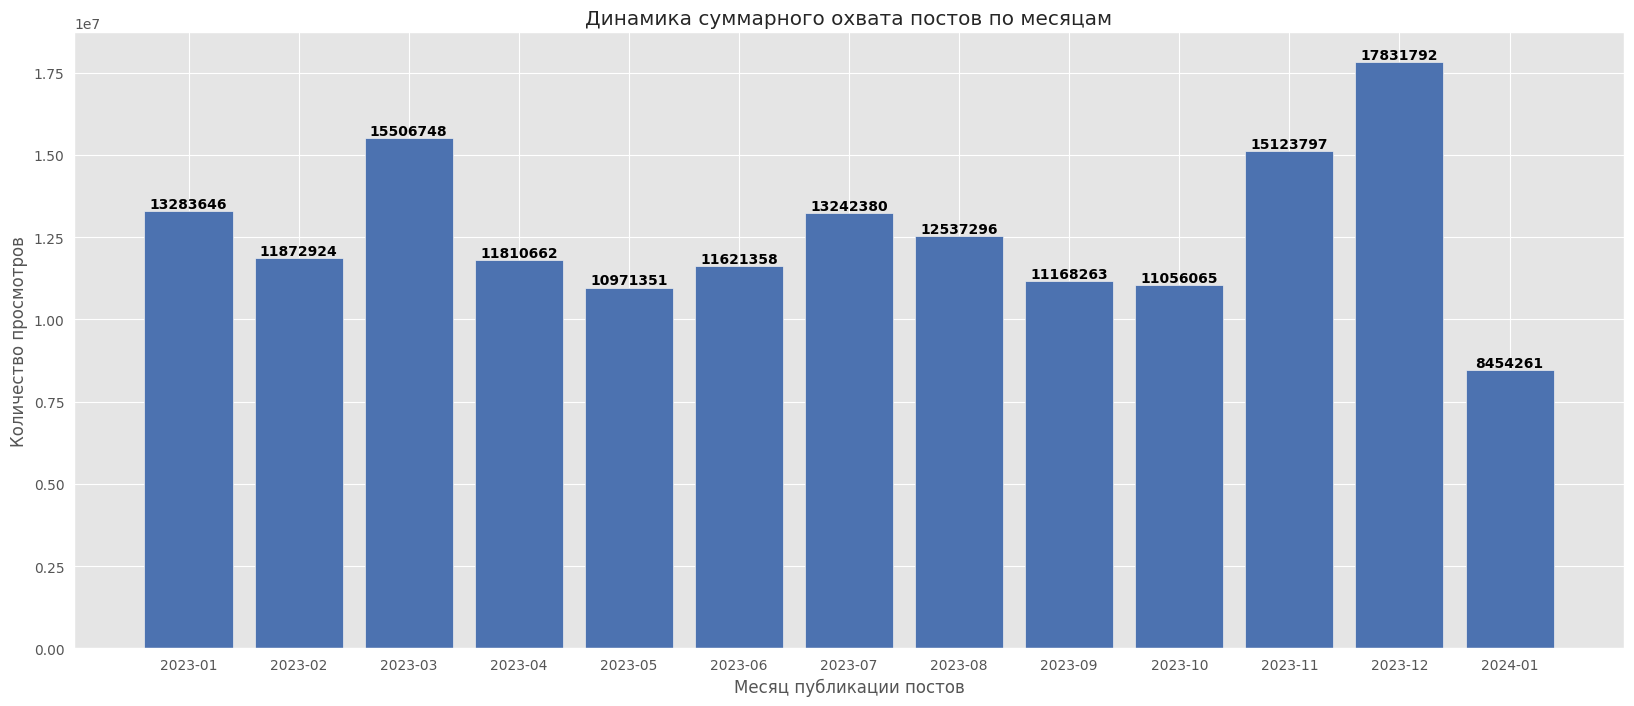

In [ ]:
# суммарный охват постов по месяцам
dynamic(view_month, 'month', 'views', 'Динамика суммарного охвата постов по месяцам')

Суммарно майские, сентябрьские и октябрьские посты имеют наименьшие число просмотров. Видно, что пользователей интересовали мартовские посты, возможно, из-за каких-то ожидаемых новинок. Например, сериал "Король и Шут".

Также с ноября начинается резкий рост просмотров, скорее всего, это была реакция подписчиков на выход бота.

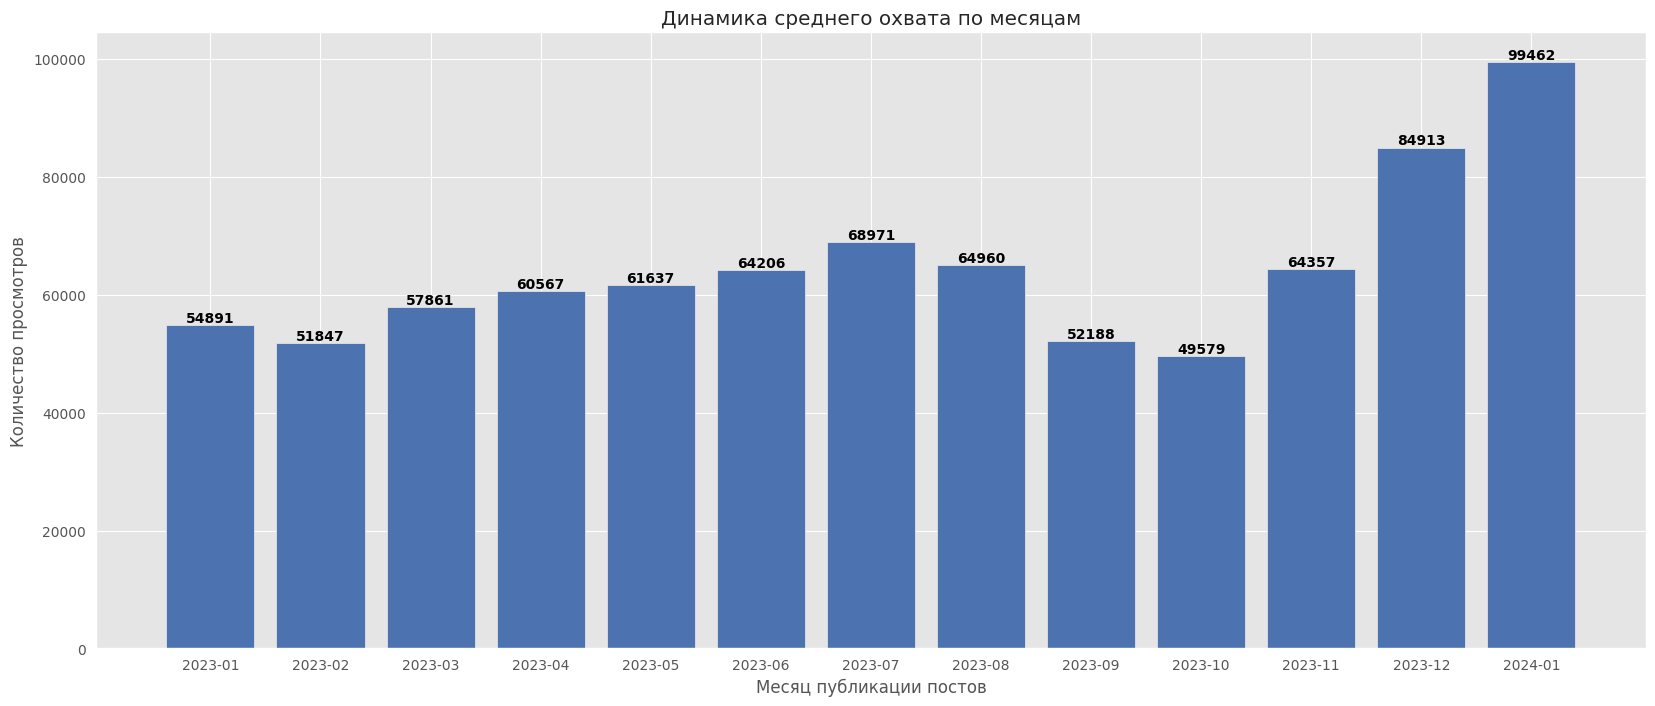

In [ ]:
# строим график среднего охвата по месяцам
dynamic(view_month, 'month', 'avg_views', 'Динамика среднего охвата по месяцам')

С августа средний охват начал падать и достиг минимума в октябре. Предполагаем, что контент не сильно привлекал пользователей. Может потому что не было интересных новинок и других инфоповодов.

С ноября начался резкий рост среднего количества просмотров по посту. Скорее всего, причина кроется в релизе бота.

Посмотрим, как обстоят дела понедельно.

In [ ]:
# таблица для среднего охвата по неделям
view_week_avg = posts_categorize.groupby([pd.Grouper(key='dat', freq='W')]).agg({'views': 'sum', 'id': 'count'}).reset_index()
view_week_avg.rename(columns={'id': 'posts_count'}, inplace=True)
view_week_avg['avg_views'] = round(view_week_avg['views'] / view_week_avg['posts_count']).astype(int)

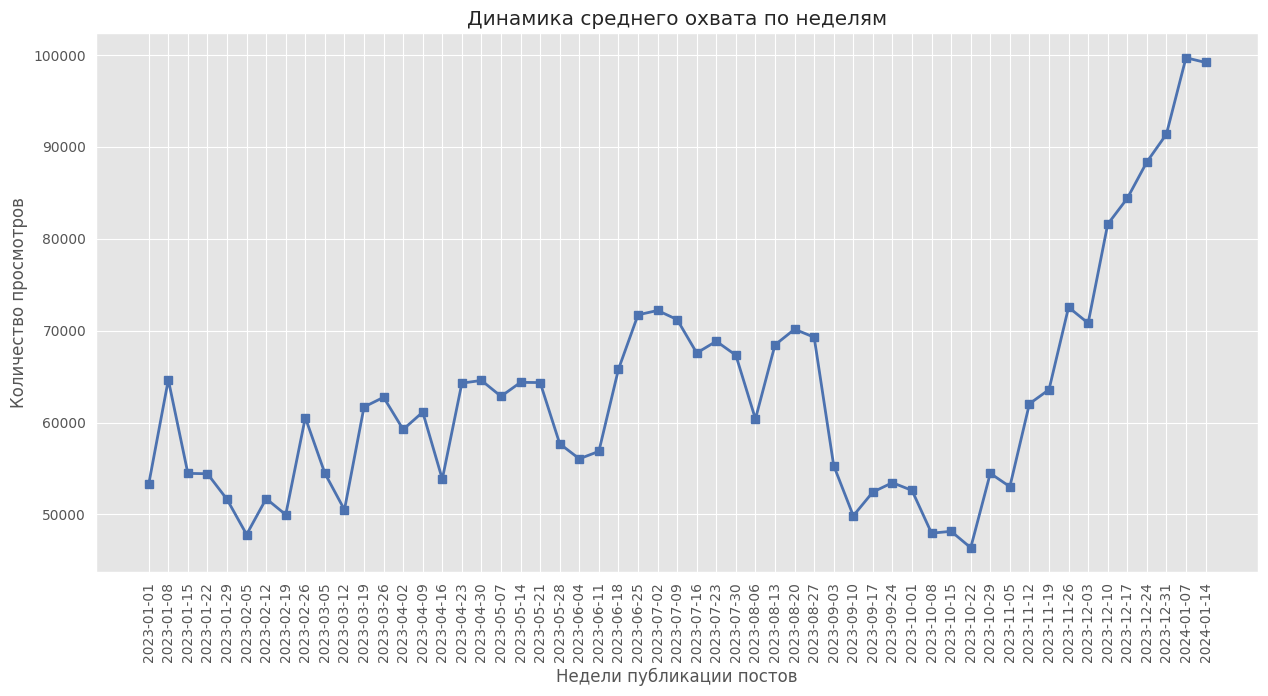

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(view_week_avg.dat,
          view_week_avg.avg_views,
          linewidth=2,
          marker='s')

plt.title('Динамика среднего охвата по неделям')
plt.xlabel('Недели публикации постов')
plt.ylabel('Количество просмотров')
plt.xticks (ticks=view_week_avg.dat, rotation=90)
plt.show()

Этот график показывает более точную картину охватов пользователей. Для анализа охвата лучше использовать его, чтобы оперативно реагировать на снижение просмотров.

Теперь построим графики динамики среднего охвата по неделям в разрезе типов постов.

In [ ]:
# таблица с группировкой по неделям и типом поста/документа
def group_type(typ):
  df = posts_categorize.groupby([pd.Grouper(key='dat', freq='W'), typ]).agg({'views': 'sum', 'id': 'count'}).reset_index()
  df.rename(columns={'id': 'posts_count'}, inplace=True)
  df['avg_views'] = round(df['views'] / df['posts_count']).astype(int)
  return df


color = ['crimson', 'y', 'black', 'green']
view_type_posts = group_type('cluster_name')
type_posts = view_type_posts.cluster_name.unique().tolist()
view_type_posts

dat cluster_name      views  posts_count  avg_views
0   2023-01-01       сериал    49091.0            1      49091
1   2023-01-01        фильм   324100.0            6      54017
2   2023-01-08       сериал   492365.0            8      61546
3   2023-01-08        фильм  1964714.0           30      65490
4   2023-01-15       сериал   465215.0            9      51691
..         ...          ...        ...          ...        ...
132 2024-01-07      коммент    98366.0            1      98366
133 2024-01-07       сериал   693835.0            7      99119
134 2024-01-07        фильм  3893334.0           39      99829
135 2024-01-14       сериал   411351.0            4     102838
136 2024-01-14        фильм  3357375.0           34      98746

[137 rows x 5 columns]

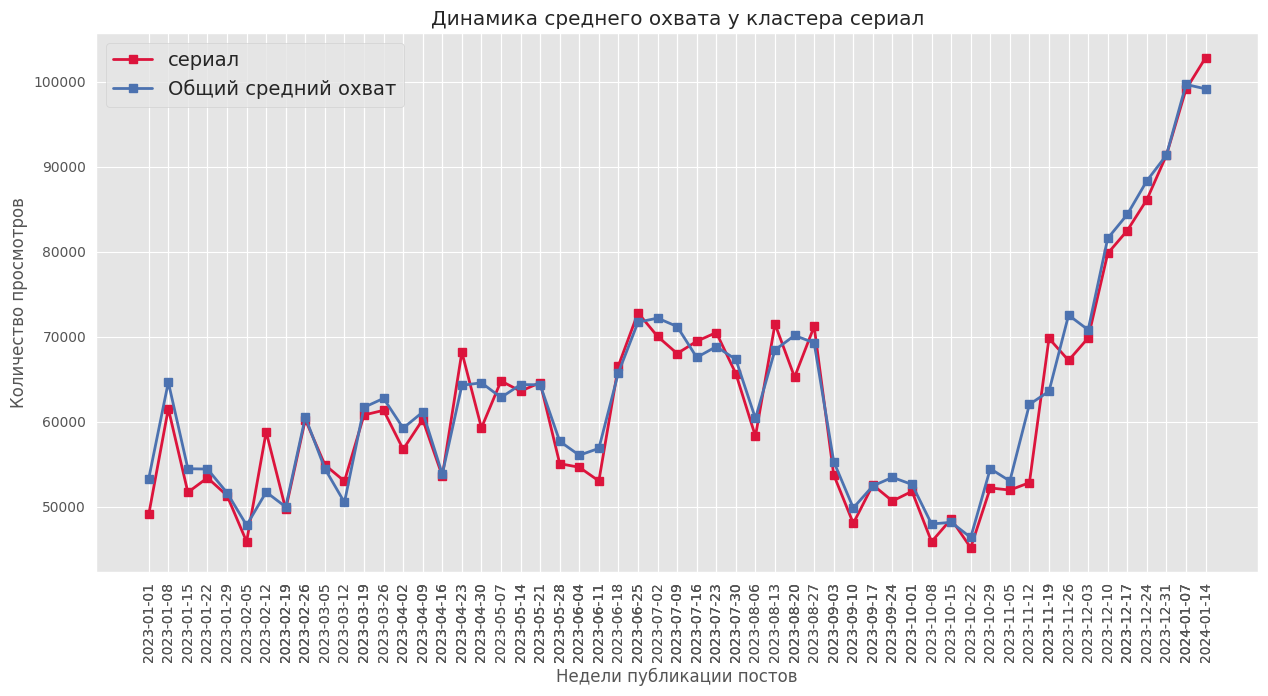

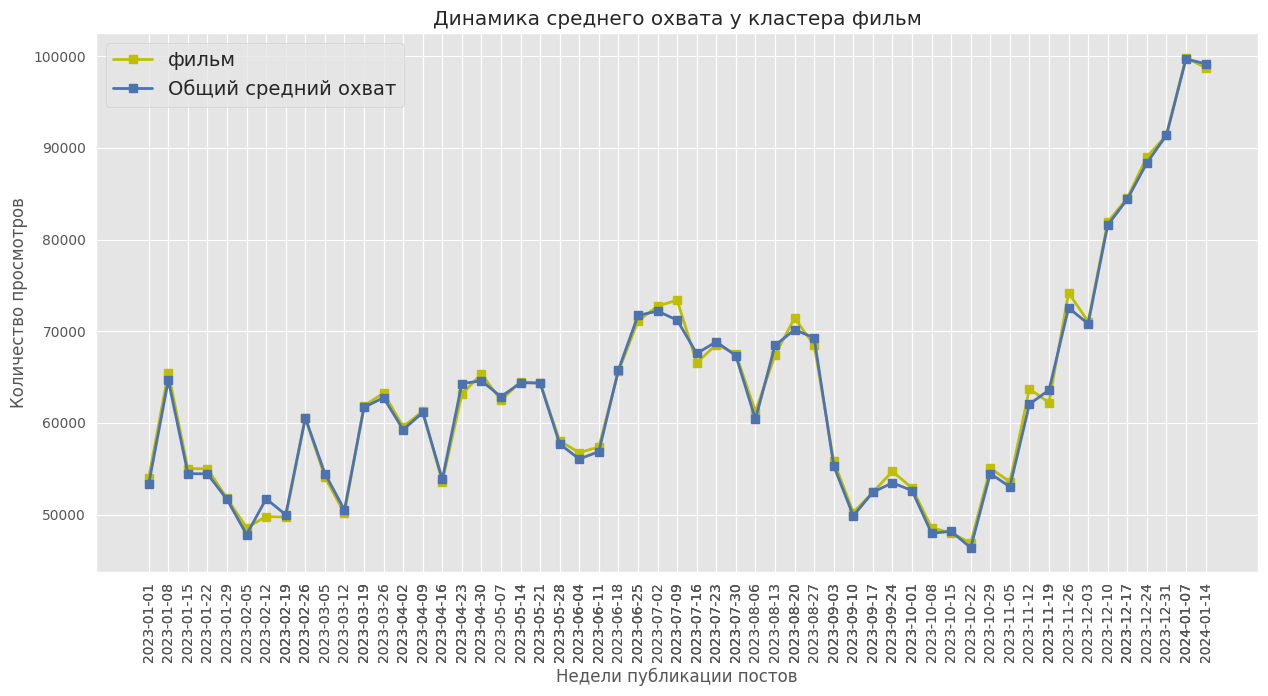

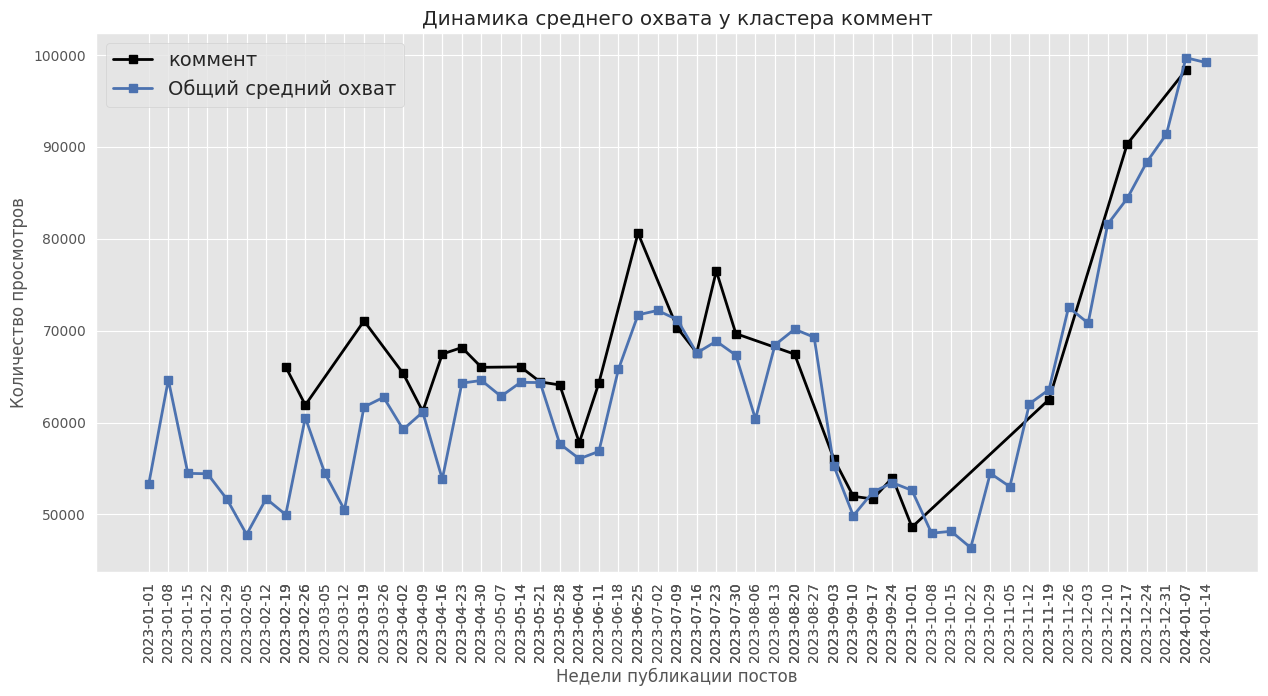

In [ ]:
# графики динамики среднего охвата по неделям в разрезе по типам постов
for tp, col, z in zip(type_posts, color, range(len(type_posts))):
    plt.figure(figsize=(15, 7))
    plt.plot(view_type_posts.query("cluster_name == @tp").dat.tolist(),
             [x for x in view_type_posts.query("cluster_name == @tp").avg_views.tolist()],
             linewidth=2, marker='s', color=col, label=tp)

    plt.plot(view_week_avg.dat,
          view_week_avg.avg_views,
          linewidth=2,
          marker='s', label='Общий средний охват')

    plt.title('Динамика среднего охвата у кластера {}'.format(tp))
    plt.xlabel('Недели публикации постов')
    plt.ylabel('Количество просмотров')
    plt.legend(fontsize=14)
    plt.xticks (ticks=view_type_posts.dat, rotation=90)

    plt.show()

Заметно, что кластер постов, призывающих людей к действиям, выше общего среднего охвата, поэтому можно сказать, что механика вовлечения людей действует.

**Охват по типу прикрепленного файла к посту**

In [ ]:
# таблица с группировкой по неделям и типом приложенного документа
view_type_attach = group_type('type_attachment')
type_attach = view_type_attach.type_attachment.unique().tolist()

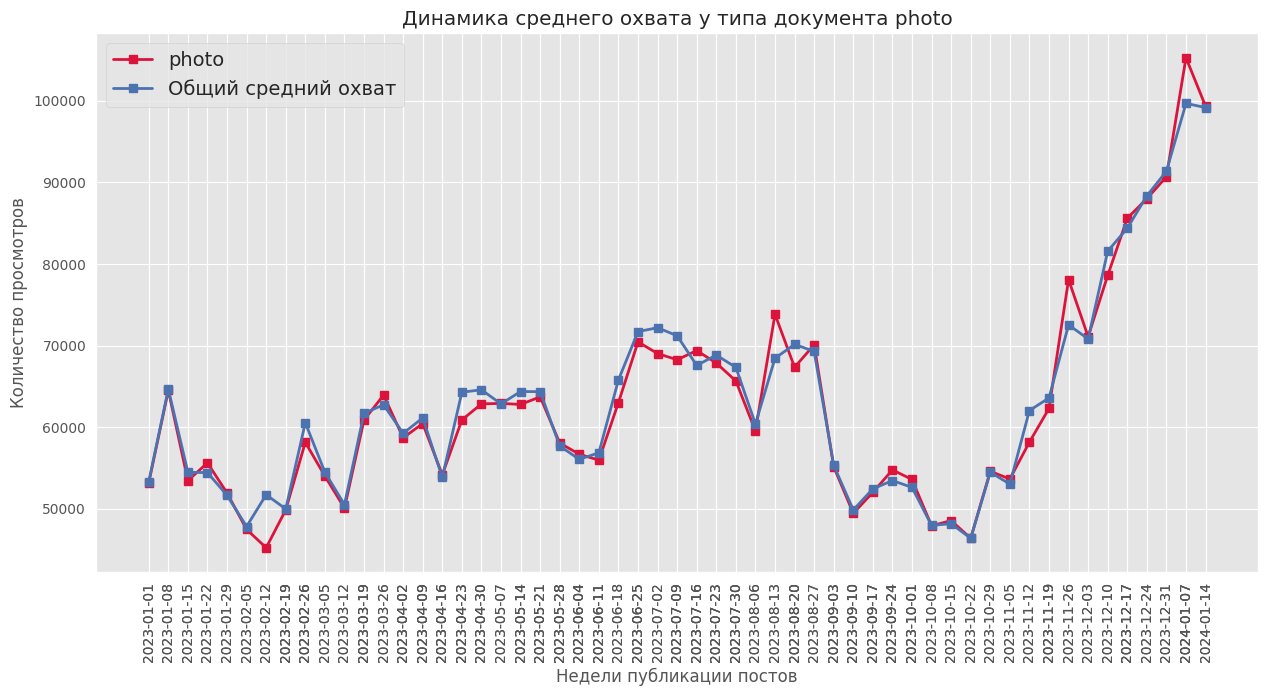

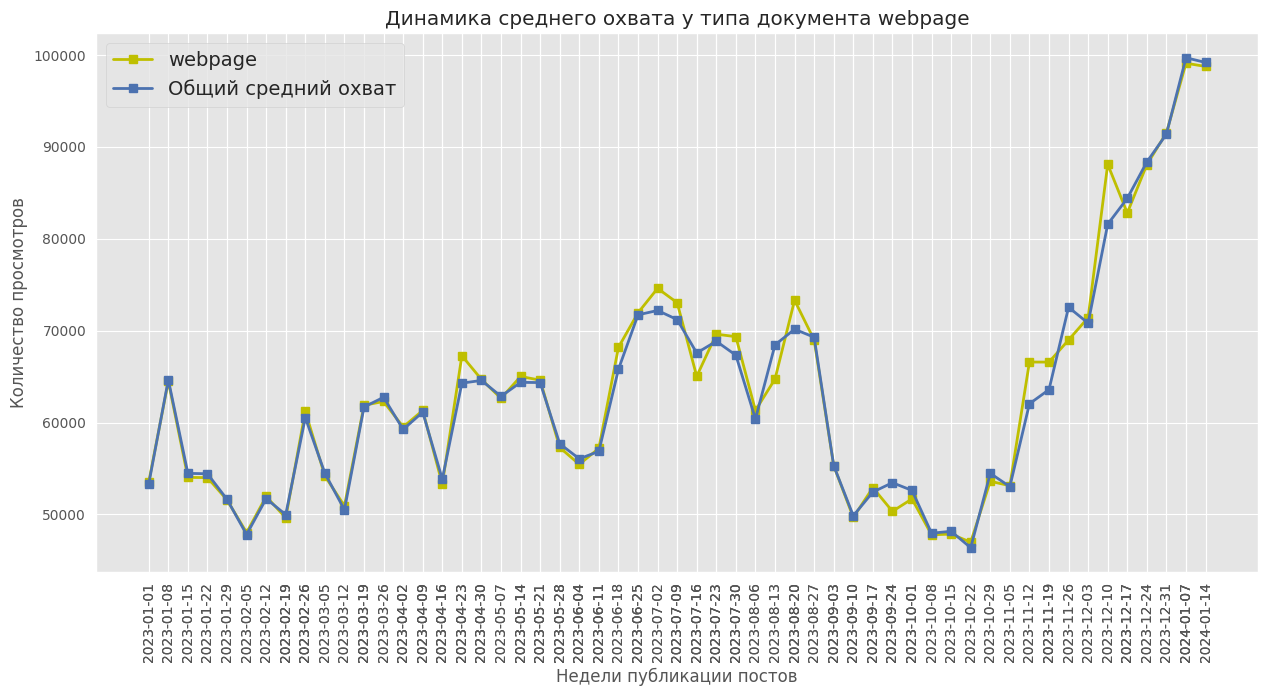

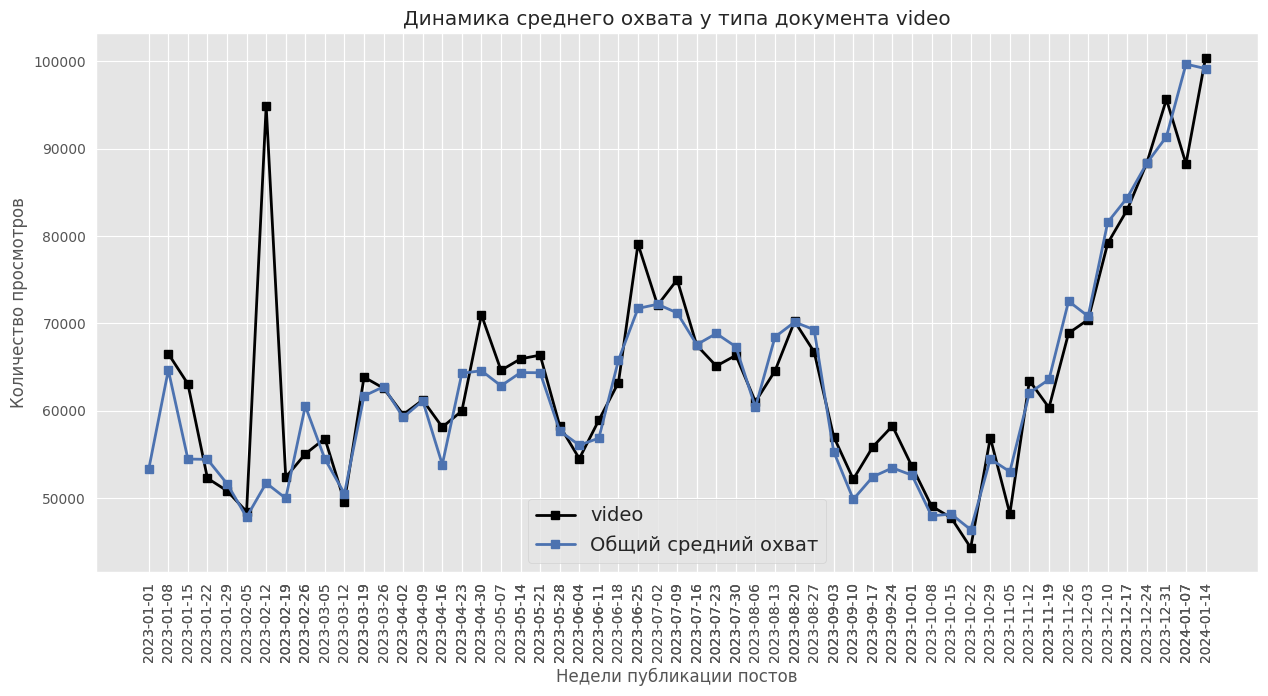

In [ ]:
# графики динамики среднего охвата по неделям в разрезе типа документов
for tp, col, z in zip(type_attach, color, range(len(type_attach))):
    plt.figure(figsize=(15, 7))
    plt.plot(view_type_attach.query("type_attachment == @tp").dat.tolist(),
             [x for x in view_type_attach.query("type_attachment == @tp").avg_views.tolist()],
             linewidth=2, marker='s', color=col, label=tp)

    plt.plot(view_week_avg.dat,
          view_week_avg.avg_views,
          linewidth=2,
          marker='s', label='Общий средний охват')

    plt.title('Динамика среднего охвата у типа документа {}'.format(tp))
    plt.xlabel('Недели публикации постов')
    plt.ylabel('Количество просмотров')
    plt.legend(fontsize=14)
    plt.xticks (ticks=view_type_posts.dat, rotation=90)

    plt.show()

В целом графики повторяют среднее значение охвата аудитории. Но выбросы заметнее наблюдаются у постов с видео. Особенно на неделе с 2023-02-05 до 2023-02-12.

Посмоторим, какой пост повлиял на подписчиков.

In [ ]:
posts_categorize.query('dat >= "2023-02-5" and dat <= "2023-02-12" and type_attachment == "video"')

id                date  \
2295  31731 2023-02-11 14:30:30   
2315  31692 2023-02-09 20:01:56   
2325  31678 2023-02-08 19:31:14   
2350  31635 2023-02-06 18:35:49   

                                                   text     views  forwarded  \
2295  «Вавилон» — кино о кино, поэтому в нем много о...  239884.0      419.0   
2315  Чебурашка, да не тот! \n\nСмотрите рекап нашег...   48191.0       32.0   
2325  «Гриффины» — это не только смешно, но и красив...   47985.0      144.0   
2350  Мы как всегда — только соберемся рассказать о ...   43589.0       23.0   

      reactions_count  comments type_attachment    month  \
2295              409        37           video  2023-02   
2315              172        13           video  2023-02   
2325              261        14           video  2023-02   
2350              278        29           video  2023-02   

                                         processed_text  \
2295  [вавилон, кино, кино, поэтому, немой, отсылка,...   
2315  [чебурашка, смотреть, рекап, наш, предыдущий, ...   
2325  [гриффина, это, смешно, красиво, наш, видео, р...   
2350  [собраться, рассказать, временной, трудность, ...   

                                     processed_text_str  cluster_label  \
2295  вавилон кино кино поэтому немой отсылка другой...              1   
2315  чебурашка смотреть рекап наш предыдущий эфир и...              1   
2325  гриффина это смешно красиво наш видео разбират...              1   
2350  собраться рассказать временной трудность наш к...              1   

     cluster_name        dat  week  text_length text_length_category day_part  \
2295        фильм 2023-02-11     5           15             Короткий     День   
2315        фильм 2023-02-09     3           29              Средний    Вечер   
2325        фильм 2023-02-08     2           28              Средний    Вечер   
2350        фильм 2023-02-06     0           13             Короткий    Вечер   

     view_cat  forwarded_cat   reaction_cat   comments_cat  subscribers  \
2295  Высокие        Высокие  Выше среднего  Выше среднего           46   
2315   Низкие         Низкие         Низкие         Низкие           75   
2325   Низкие  Выше среднего        Средние        Средние          103   
2350   Низкие         Низкие        Средние  Выше среднего            0   

      unsubscribed subscribers_cat unsubscribers_cat  
2295            15         Средние            Низкие  
2315             0         Средние            Низкие  
2325             0         Средние            Низкие  
2350            57          Низкие           Средние

Всего 4 поста с видео за неделю. Но пост с референсами к классике, которую упоминали в фильме Вавилон, собрал 239884 просмотров. Отсюда можно сделать вывод, что аудитория может быть заинтересована в тренде изучения оммажей и отсылок, что является углубленным изучением киноматографии и в совокупности видео-визуального искусства, именно в такой аудитории заинтересован ТГ-канал Кинопоиска.

### Вовлеченность

In [ ]:
# вычисление вовлеченности для каждого поста
posts_categorize['er'] = (((posts_categorize['reactions_count']+posts_categorize['forwarded']+posts_categorize['comments']))\
                          / posts['views']) * 100

In [ ]:
# группировка данных по неделям и вычисление среднего охвата, суммы реакций и количества постов
weekly_stats = (posts_categorize
                .groupby(pd.Grouper(key='dat', freq='W'))['views', 'reactions_count', 'comments', 'forwarded', 'id']
                .agg({'views': 'mean', 'reactions_count': 'sum', 'forwarded': 'sum', 'comments': 'sum', 'id': 'nunique'})
                .reset_index())

# вычисление вовлеченности для каждой недели
weekly_stats['er_week'] = (((weekly_stats['reactions_count']+weekly_stats['forwarded']+weekly_stats['comments']) / weekly_stats['id']) / weekly_stats['views']) * 100

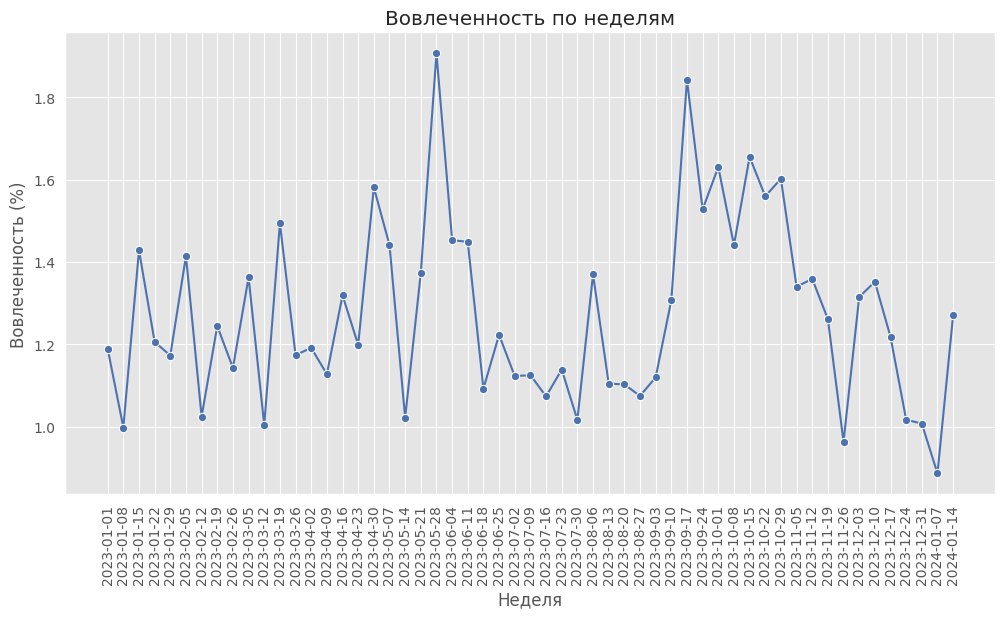

In [ ]:
# построение графика вовлеченности по неделям
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_stats, x=weekly_stats.dat, y='er_week', marker='o')

# настройка графика
plt.title('Вовлеченность по неделям')
plt.xlabel('Неделя')
plt.ylabel('Вовлеченность (%)')
plt.xticks (ticks=weekly_stats.dat, rotation=90)

# показать график
plt.show()

Уровень вовлеченности людей меняется со временем, это нормально. Заметно сильное падение вовлеченности в неделю новогодних праздников, людям вероятно было не до тг-каналов. Высокие показатели со второй половины сентября показатели обосновываются выходом Барби и Опенгеймера в российский прокат.
Важно, также отметить, что мем-бот не сильно повлиял на вовлеченность, так как не все пользователи, им воспользовавшиеся, остались в подписчиках канала, да и в целом не вся аудитория, которой понравился бот, может быть целевой аудиторией канала.

#### График постов

Посмотрим, в какое время выкладывали посты по месяцам с характеристикой по вовлеченности.

In [ ]:
posts_categorize['hour'] = posts['date'].dt.hour

In [ ]:
# сводная таблица для графика
chart_publish = posts_categorize.pivot_table(index='dat',
                                  columns='hour',
                                  values='er')

In [ ]:
# функция для построения графиков публикаций постов по времени
def chart(df):
  title_post = ['январе', 'феврале', 'марте', 'апреле', 'мае', 'июне', 'июле', 'августе', 'сентябре', 'октябре', 'ноябре', 'декабре']
  number_month = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
  plt.figure(figsize=(15, 8))
  for nm, t in zip(number_month, title_post):
    if nm == '01' or nm == '03' or nm == '05' or nm == '07' or nm == '08' or nm == '10' or nm == '12':
      df_dt = df.query('dat >= "2023-{}-01".format(@nm) and dat <= "2023-{}-31".format(@nm)')
      plt.figure(figsize=(15, 8))
      time_labels_dt = df_dt.index
      sns.heatmap(df_dt, cmap='Greens', linewidths=2, annot=True, cbar=False, yticklabels=time_labels_dt.date)
      plt.title('График публикаций в {} с указанием вовлеченности в процентах'.format(t))
      plt.ylabel('Дата')
      plt.xlabel('Время')
      plt.show()
    elif nm == '04' or nm == '06' or nm == '09' or nm == '11':
      df_dt = df.query('dat >= "2023-{}-01".format(@nm) and dat <= "2023-{}-30".format(@nm)')
      plt.figure(figsize=(15, 8))
      time_labels_dt = df_dt.index
      sns.heatmap(df_dt, cmap='Greens', linewidths=2, annot=True, cbar=False, yticklabels=time_labels_dt.date)
      plt.title('График публикаций в {} с указанием вовлеченности в процентах'.format(t))
      plt.ylabel('Дата')
      plt.xlabel('Время')
      plt.show()
    else:
      try:
        df_dt = df.query('dat >= "2023-{}-01".format(@nm) and dat <= "2023-{}-28".format(@nm)')
        plt.figure(figsize=(15, 8))
        time_labels_dt = df_dt.index
        sns.heatmap(df_dt, cmap='Greens', linewidths=2, annot=True, cbar=False, yticklabels=time_labels_dt.date)
        plt.title('График публикаций в {} с указанием вовлеченности в процентах'.format(t))
        plt.ylabel('Дата')
        plt.xlabel('Время')
        plt.show()
      except: # если год високосный, то в феврале 29 дней
        df_dt = df.query('dat >= "2023-{}-01".format(@nm) and dat <= "2023-{}-29".format(@nm)')
        time_labels_dt = df_dt.index
        sns.heatmap(df_dt, cmap='Greens', linewidths=2, annot=True, cbar=False, yticklabels=time_labels_dt.date)
        plt.title('График публикаций в {} с указанием вовлеченности в процентах'.format(t))
        plt.ylabel('Дата')
        plt.xlabel('Время')
        plt.show()

<Figure size 1500x800 with 0 Axes>

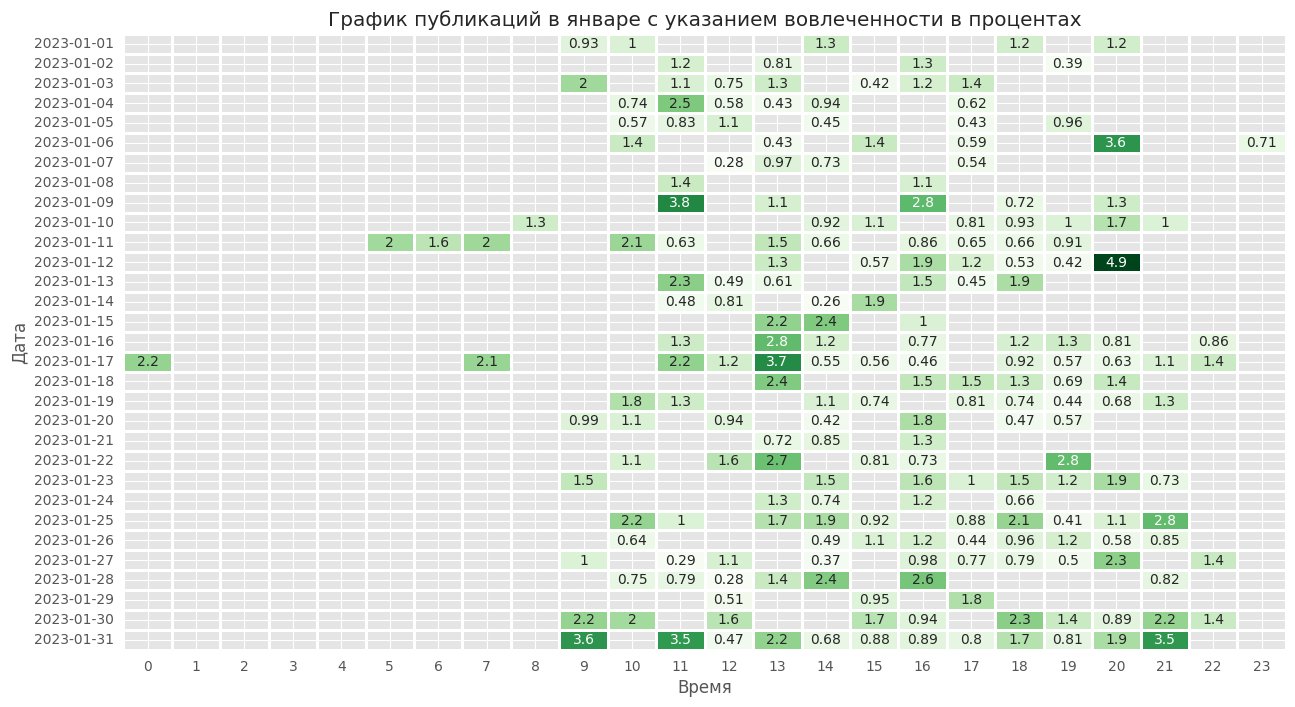

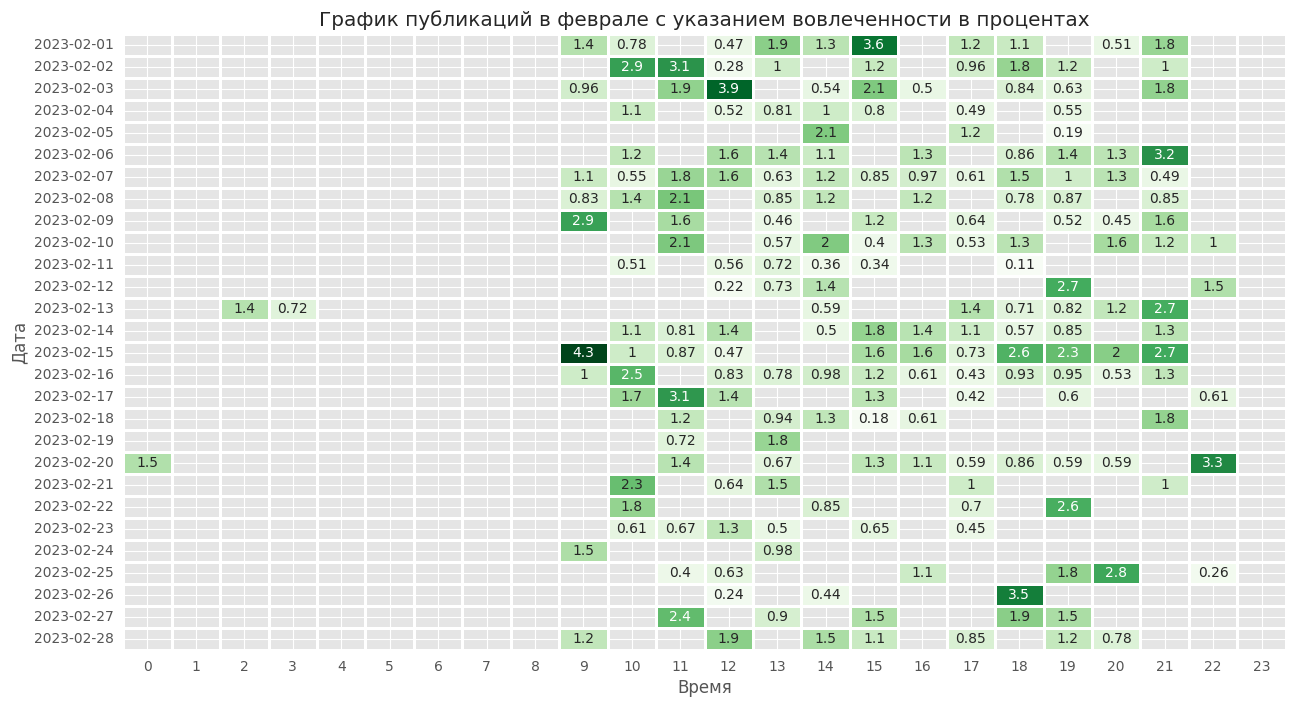

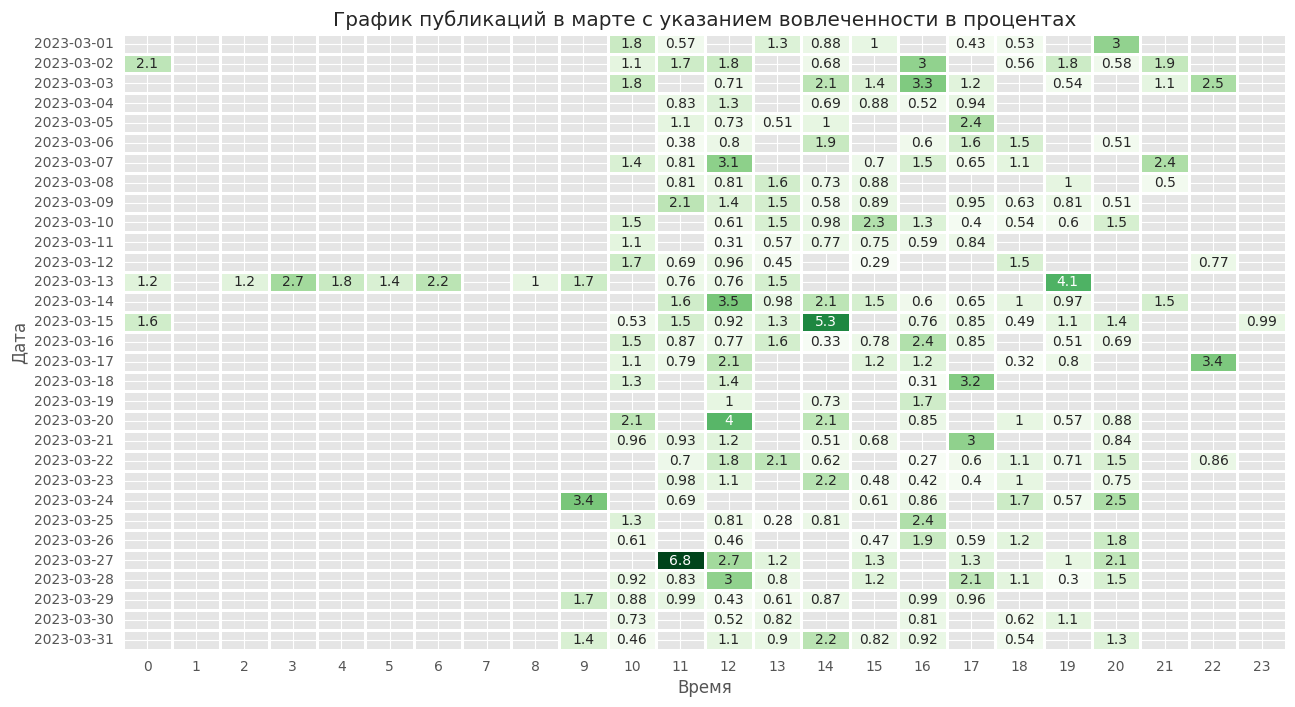

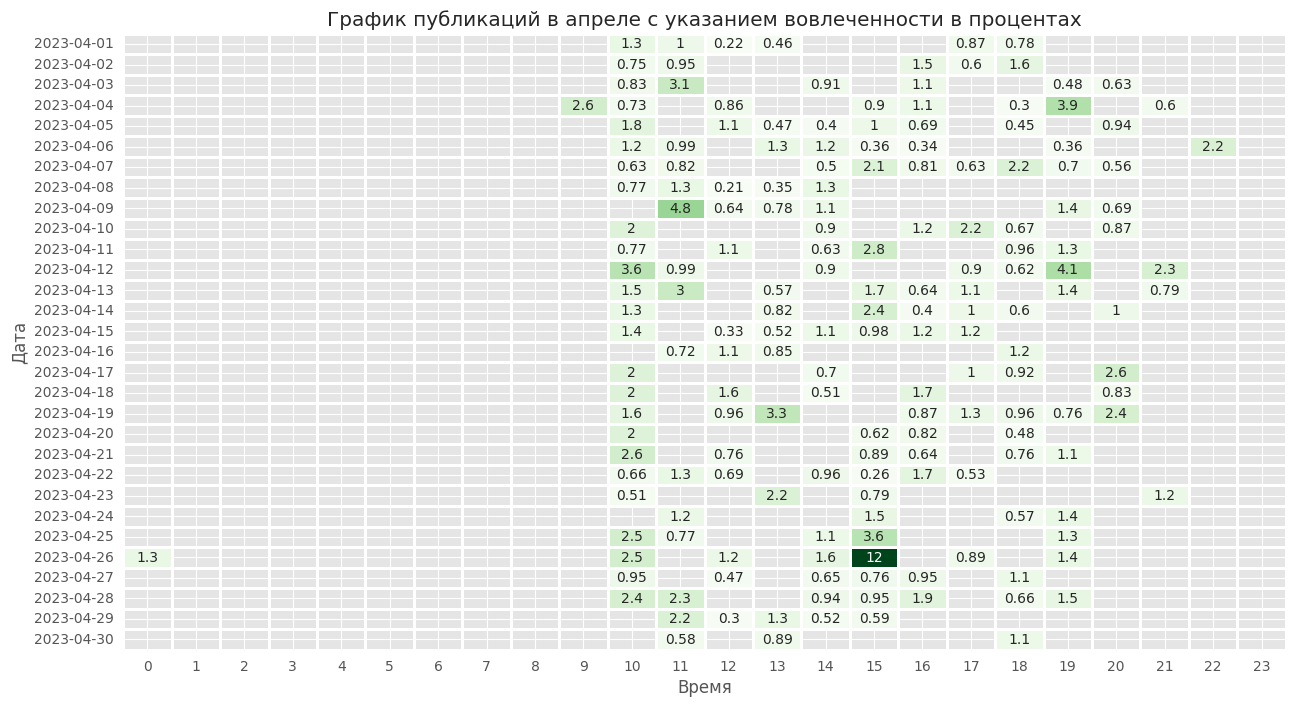

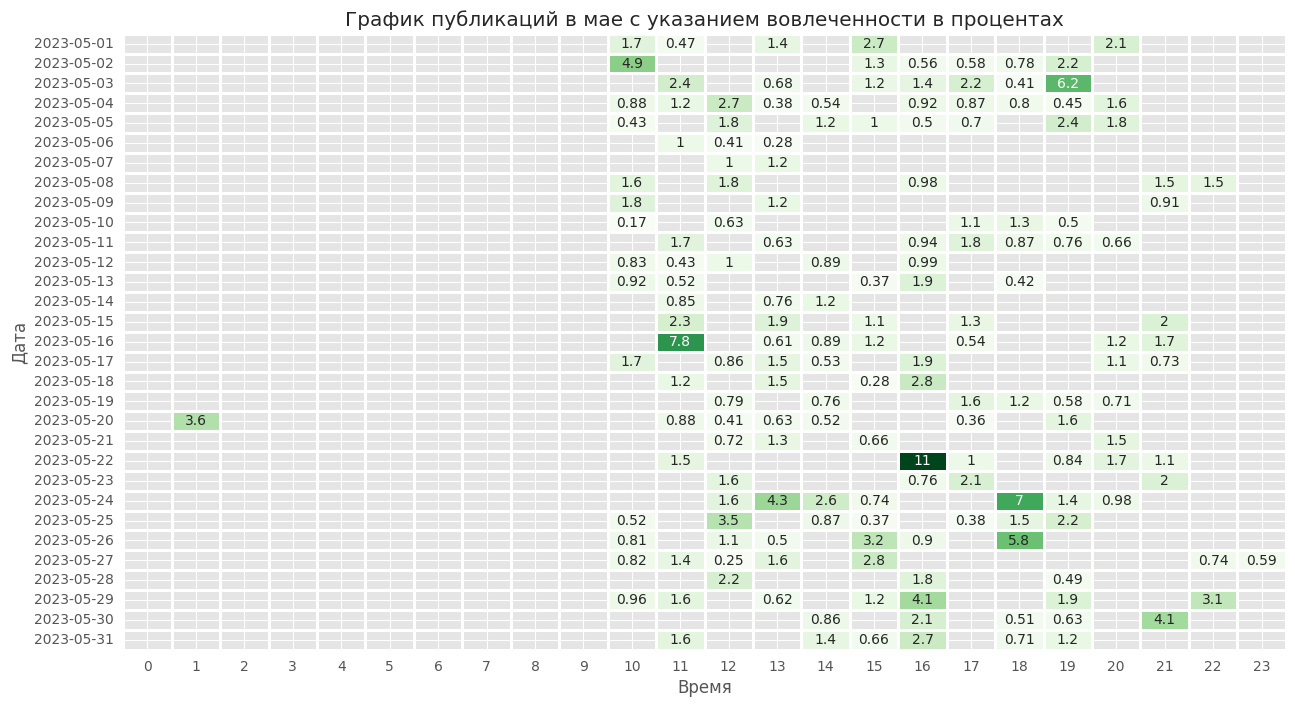

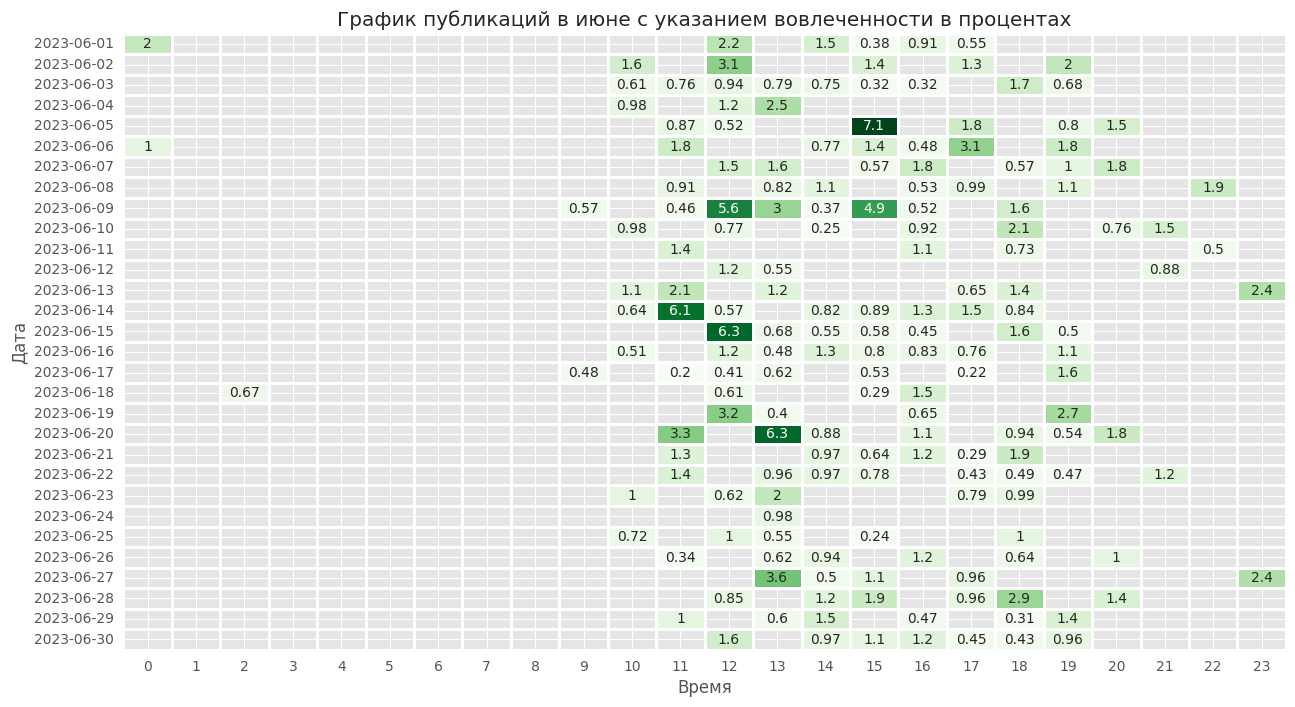

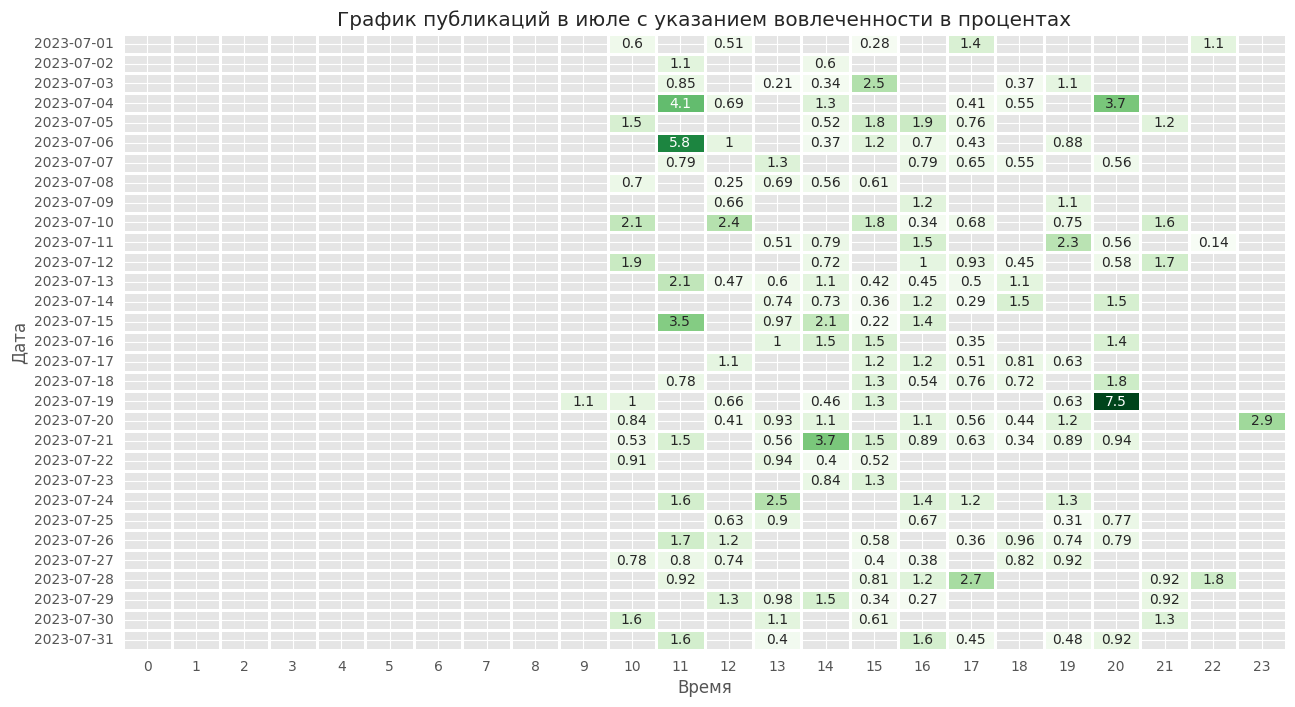

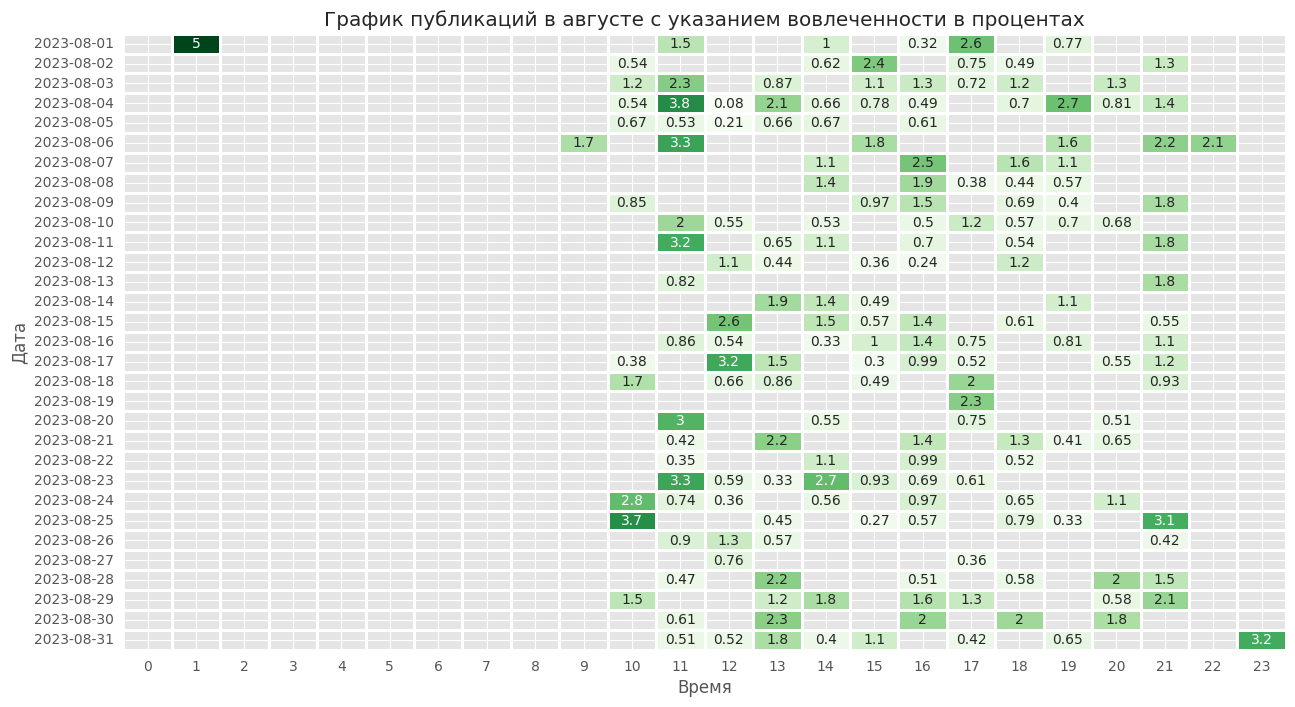

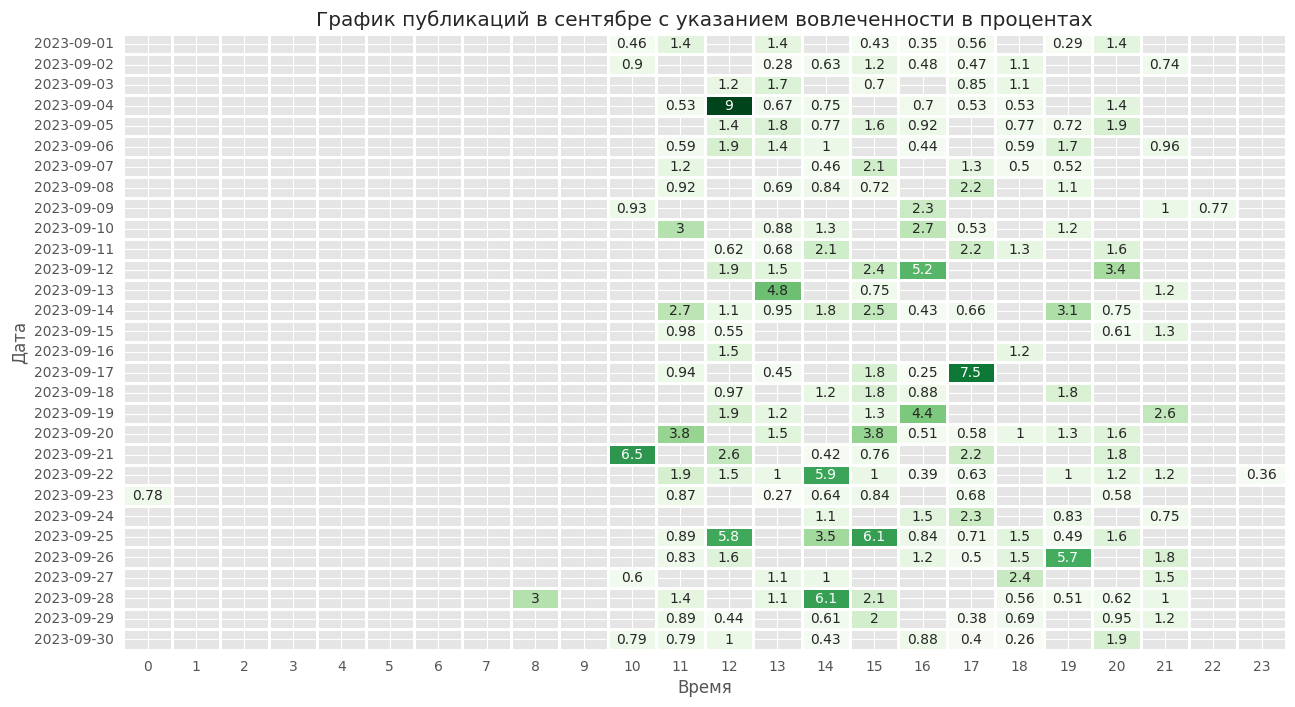

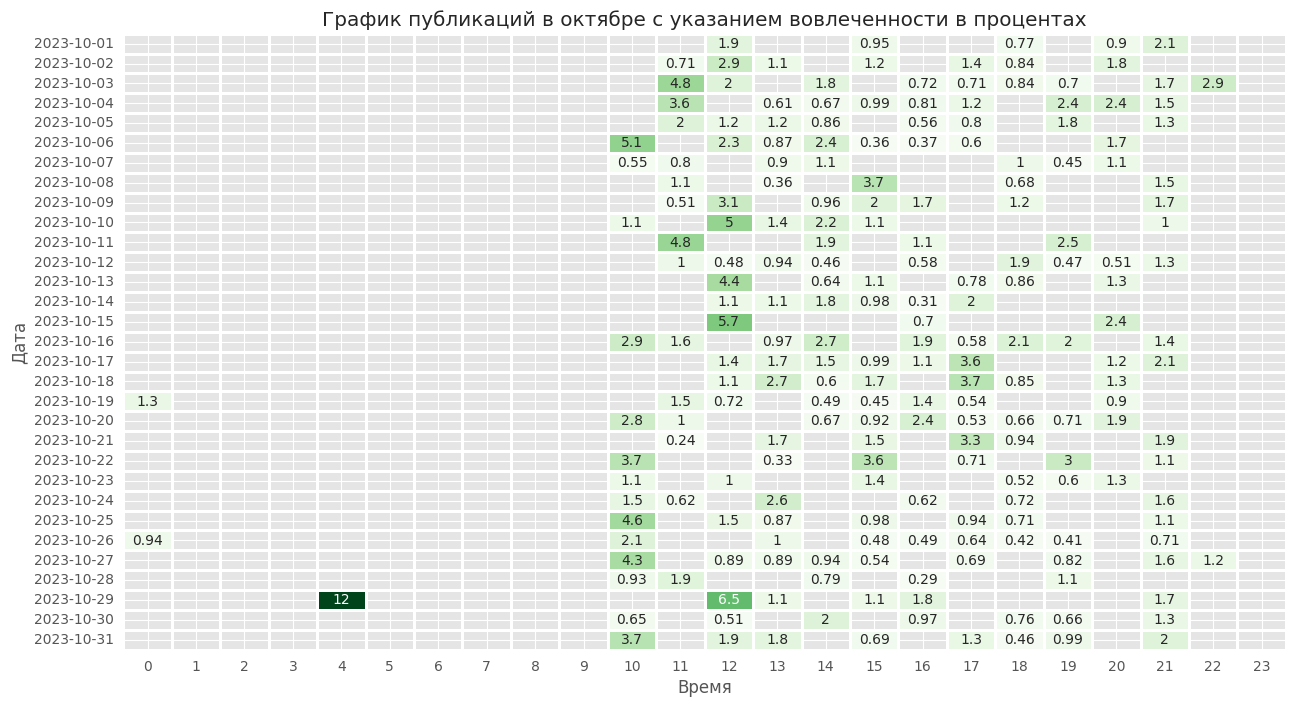

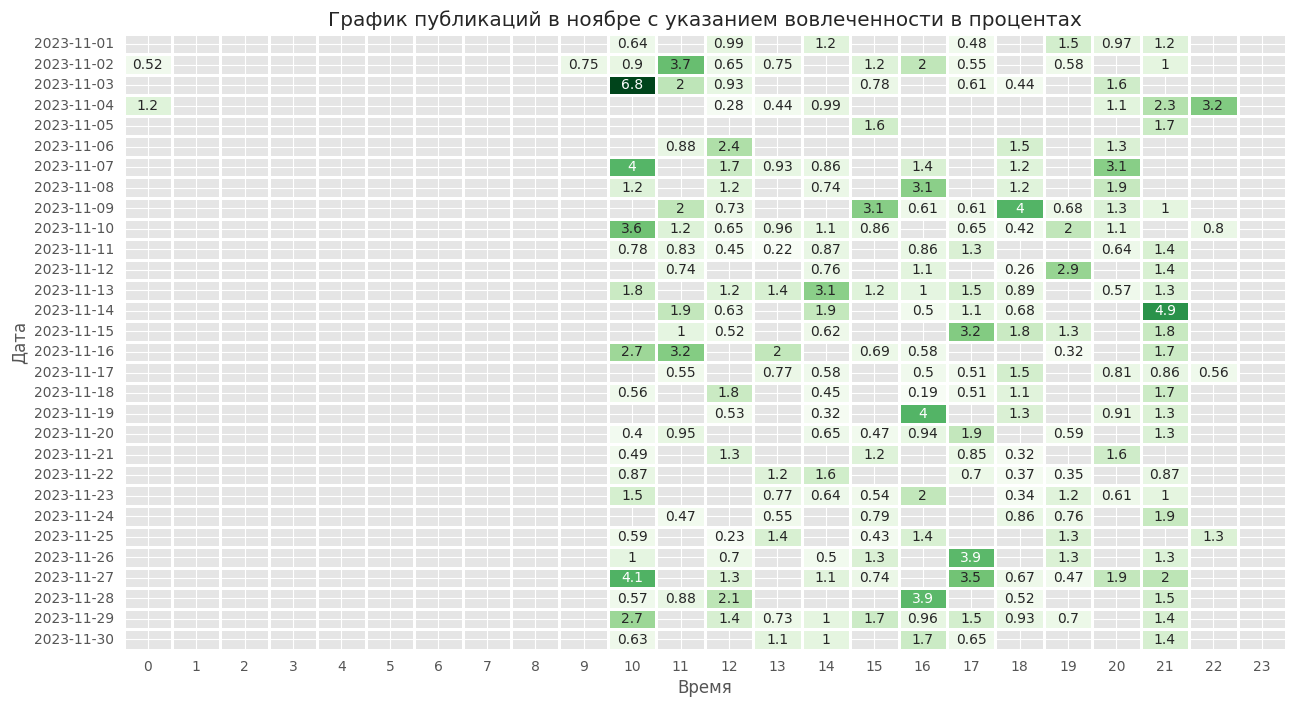

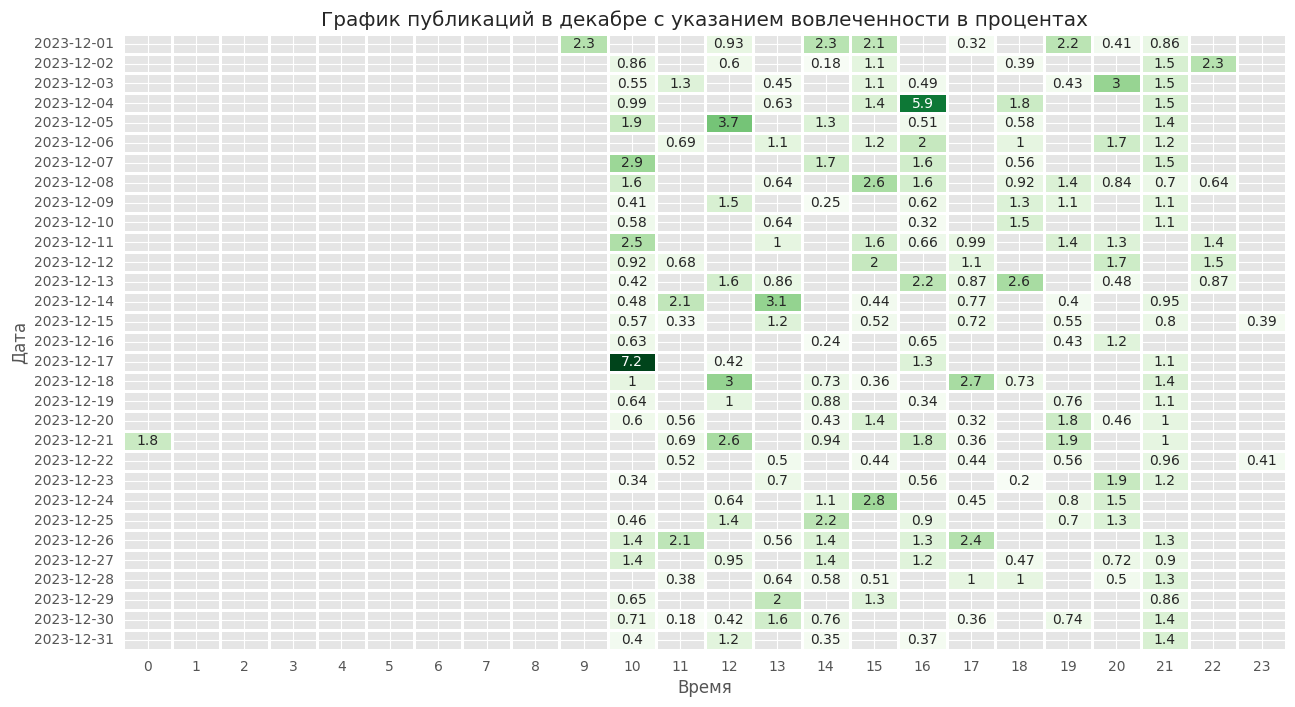

In [ ]:
chart(chart_publish)

Основная масса постов публикуется с 9 до 20 часов. Ночью посты - редкость.

#### Тематики топовых по вовлеченности постов

In [ ]:
posts_categorize['er'].sort_values(ascending=False).head(15)

551     11.858148
1735    11.748566
1593    10.901048
942      8.983707
1630     7.821263
1236     7.493226
854      7.475382
182      7.156925
1507     7.061436
1578     6.988479
511      6.782541
1946     6.778973
550      6.533450
834      6.456033
1415     6.301016
Name: er, dtype: float64

In [ ]:
# изучим топовые по вовлеченности посты
# сделаем срез
top_er_posts = posts_categorize[posts_categorize['er'] > 6.98]

In [ ]:
# посмотрим полные тексты лучших постов
for full_text in top_er_posts['text']:
    print(full_text)

Гэри Олдман благодарит судьбу за «Гарри Поттера» и «Темного рыцаря». Актер [признался,](https://www.indiewire.com/news/general-news/gary-oldman-harry-potter-and-batman-movies-saved-me-1234936398/) что блокбастеры спасли его и позволили проводить время с детьми после развода с женой. 

«В 42 года я проснулся разведенным и получил опеку над сыновьями, — рассказал Олдман. — Это было сложно, потому что в индустрии произошел сдвиг, и многие съемки велись в Венгрии, Будапеште, Праге, Австралии… Мне пришлось отказаться от многих ролей».

По словам актера, играя Сириуса Блэка и комиссара Гордона, он мог выполнять меньший объем работы за большее количество денег, а потом быть дома с детьми. 

__Какая из этих ролей Олдмана — ваша любимая?__
❤️— Сириус Блэк, конечно!
👍— Комиссар Гордон
🔥— У него слишком много великих ролей, чтобы выбрать одну!

🔥 Подписывайтесь на [**«Кинопоиск»**](https://t.me/kinopoisk)
Умер звезда «Друзей» Мэттью Перри. Ему было 54 года.

Фото: Getty Images
Нолан — гений! Тепе

По текстам лучших по вовлеченности постов видно, что большинство из них (9/10) - посты тематики "призыв к действию". 1 пост является ностальгическим (смерть Мэттью Перри), которая поразила все кино-сообщество.

In [ ]:
# объединение всех токенов в один список
all_tokens = [token for sublist in top_er_posts['processed_text'] for token in sublist]

# рассчет частоты встречаемости слов
freq_dist = FreqDist(all_tokens)

# вывод топовых слов
print(freq_dist.most_common(10))

[('❤️', 5), ('это', 4), ('роль', 4), ('👎', 4), ('актёр', 3), ('год', 3), ('рассказать', 3), ('👍', 3), ('нолан', 3), ('гений', 3)]


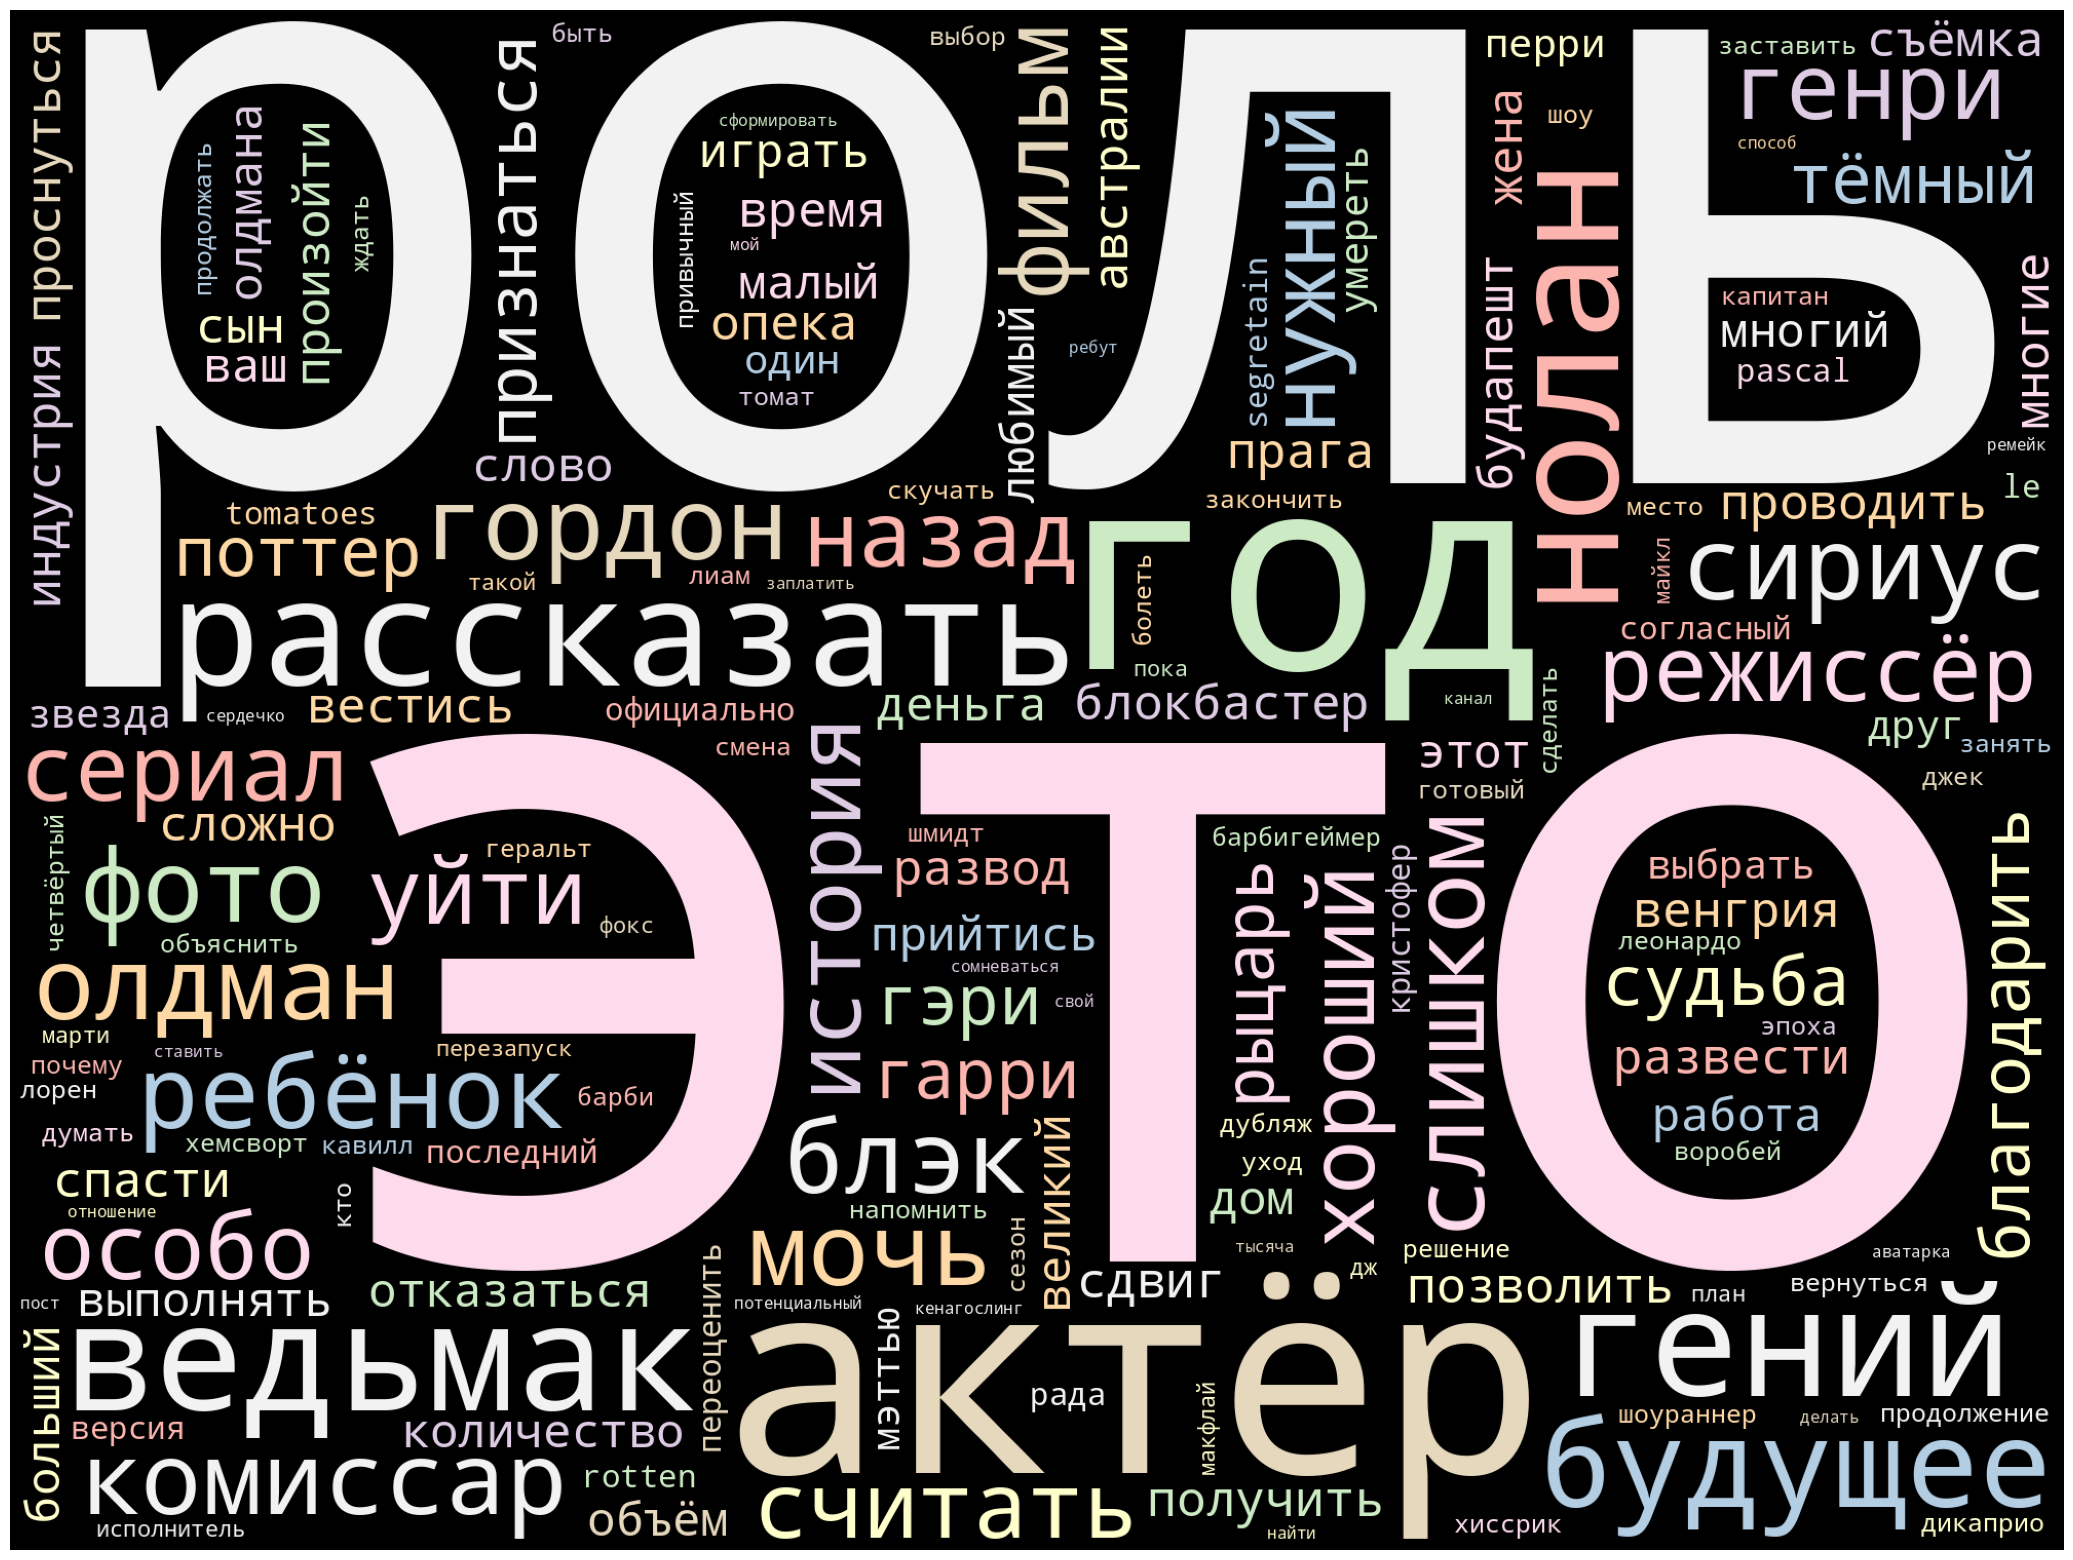

In [ ]:
# объединяем все тексты в одну строку
all_text = ' '.join([' '.join(tokens) for tokens in top_er_posts['processed_text']])

# генерируем облако слов
wordcloud = WordCloud(width=2000,
                      height=1500,
                      random_state=1,
                      background_color='black',
                      margin=20,
                      colormap='Pastel1',
                      collocations=False).generate(all_text)

# функция для визуализации облака слов
def plot_cloud(wordcloud):
    # устанавливаем размер картинки
    plt.figure(figsize=(30, 20))
    # показать изображение
    plt.imshow(wordcloud)
    # без подписей на осях
    plt.axis("off")
    # отображение облака слов
    plt.show()

# рисуем облако
plot_cloud(wordcloud)

В топовые тематики по вовлеченности входят посты об:
- актерах,
- фильмах,
- сериалах,
- ролях.

**Определим длину лучших постов**

In [ ]:
average_words_per_post = top_er_posts['processed_text'].apply(len).median()
print(f"Среднее количество слов в постах: {average_words_per_post}")

Среднее количество слов в постах: 10.0


In [ ]:
# генерация биграмм и триграмм
bi_grams = list(bigrams(all_tokens))
tri_grams = list(trigrams(all_tokens))

# рассчет частоты встречаемости биграмм и триграмм
bi_freq_dist = FreqDist(bi_grams)
tri_freq_dist = FreqDist(tri_grams)

# вывод биграмм
print("Топ 10 биграмм:")
for bigram, freq in bi_freq_dist.most_common(10):
    print(f"{bigram[0]} {bigram[1]}: {freq}")

# вывод триграмм
print("\nТоп 10 триграмм:")
for trigram, freq in tri_freq_dist.most_common(10):
    print(f"{trigram[0]} {trigram[1]} {trigram[2]}: {freq}")

Топ 10 биграмм:
❤️ 👎: 3
сириус блэк: 2
комиссар гордон: 2
нолан гений: 2
👎 особо: 2
👍🏻 👎🏻: 2
назад будущее: 2
считать нужный: 2
гэри олдман: 1
олдман благодарить: 1

Топ 10 триграмм:
❤️ 👎 особо: 2
гэри олдман благодарить: 1
олдман благодарить судьба: 1
благодарить судьба гарри: 1
судьба гарри поттер: 1
гарри поттер тёмный: 1
поттер тёмный рыцарь: 1
тёмный рыцарь актёр: 1
рыцарь актёр признаться: 1
актёр признаться блокбастер: 1


**Вывод по тематикам топовых постов**

Были выбраны 10 лучших постов по вовлеченности пользователей, ярко видно, что 9 из них относятся к тематике призыва к действию. По биграммам и триграммам также заметно, как выделяются посты, в которых, например, Кинопоиск просит высказать мнение и проголосовать в различных опросах.

#### Проверка гипотезы: вовлеченность подписчиков зависит от типа прикрепленного документа и типа поста

In [ ]:
# подготавливаю данные для анализа
for_corr_er = posts_categorize[['er', 'type_attachment']]
for_corr_er['cluster_label'] = posts['cluster_label']
for_corr_er = for_corr_er.dropna()

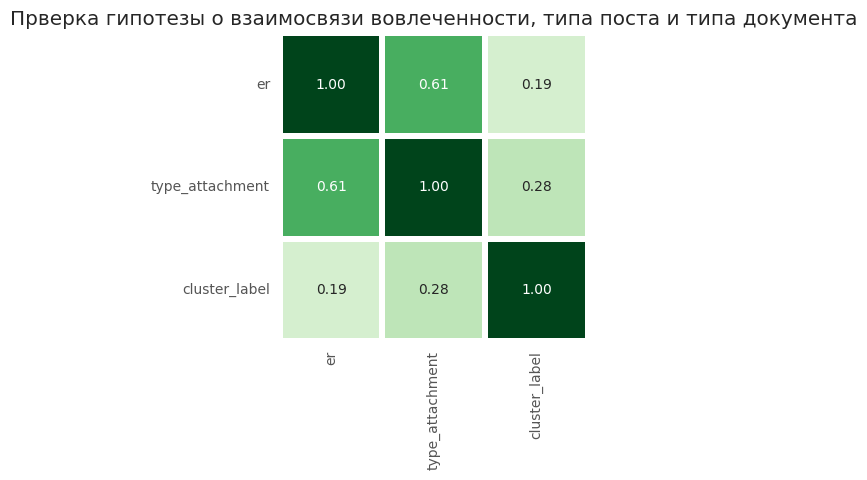

In [ ]:
plt.figure(figsize=(18, 4))

plt.title('Прверка гипотезы о взаимосвязи вовлеченности, типа поста и типа документа')
sns.heatmap(for_corr_er.phik_matrix(verbose=False),
            annot=True,
            cmap='Greens',
            cbar=False,
            center=.5,
            square=True,
            linewidth=3,
            fmt='.2f')
plt.show()

Наблюдается заметная взаимосвязь между типом приложенного документа и вовлеченностью подписчиков.

Есть слабая взаимосвязь между типом поста и вовлеченностью.

Посмотрим динамику вовлеченности подписчиков по типу приложенного документа.

In [ ]:
type_doc = posts_categorize.dropna().type_attachment.unique().tolist()
# группирую данные понедельно и по типам прикрепленного документа
posts_categorize_doc = posts_categorize.groupby([pd.Grouper(key='dat', freq='W'), 'type_attachment']).agg({'er': 'median', 'id': 'count'}).reset_index()


# графики динамики в разрезе типа прикрепленного документа
def er_doc(column, color, tit, ylb):
  plt.figure(figsize=(15, 7))
  for td, col in zip(type_doc, color):
      plt.plot(posts_categorize_doc.query("type_attachment == @td").dat.tolist(),
              [x for x in posts_categorize_doc.query("type_attachment == @td")[column].tolist()],
              linewidth=2, marker='s', color=col, label=td)


  plt.title('Понедельная динамика {} в разрезе типа приложенного документа'.format(tit))
  plt.xlabel('Неделя')
  plt.ylabel('{}'.format(ylb))
  plt.legend(fontsize=14)
  plt.xticks (ticks=posts_categorize_doc.dat, rotation=90)
  plt.show()

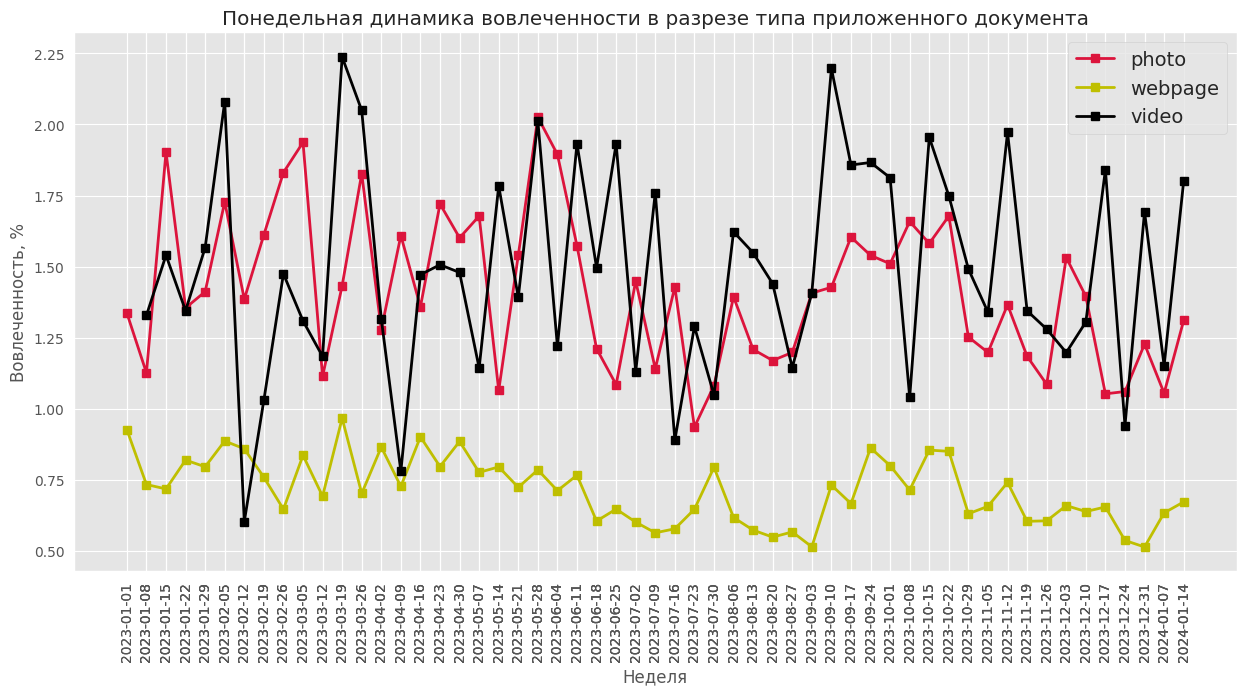

In [ ]:
er_doc('er', color, 'вовлеченности', 'Вовлеченность, %')

Наименьшая вовлеченность почти во все недели была у постов с ссылками. Фото и видео часто находятся в разбросе, однако наиболее интересно, что вовлеченность в видео-материалы очень сильно скачет, это обозначает, что к выбору контента нужно подходить аккуратно и опираться на интересы целевой аудитории и глобальные инфоповоды и тренды.


Посчитаем среднюю вовлеченность по типу прикрепленного документа.

In [ ]:
posts_categorize.groupby('type_attachment')['er'].median().sort_values(ascending=False)

type_attachment
video      1.421974
photo      1.384873
webpage    0.716670
Name: er, dtype: float64

Активнее всего пользователи реагируют на видео, а затем на фото. Ранее мы выяснили долю постов по типам прикрепленного документа. За весь наблюдаемый период доля видеопостов была наименьшей - 9,2 %. Возможно, что к концу рассматриваемого периода ситуация с количеством постов изменилась. Проверим это умозаключение с помощью графика динамики количества постов.

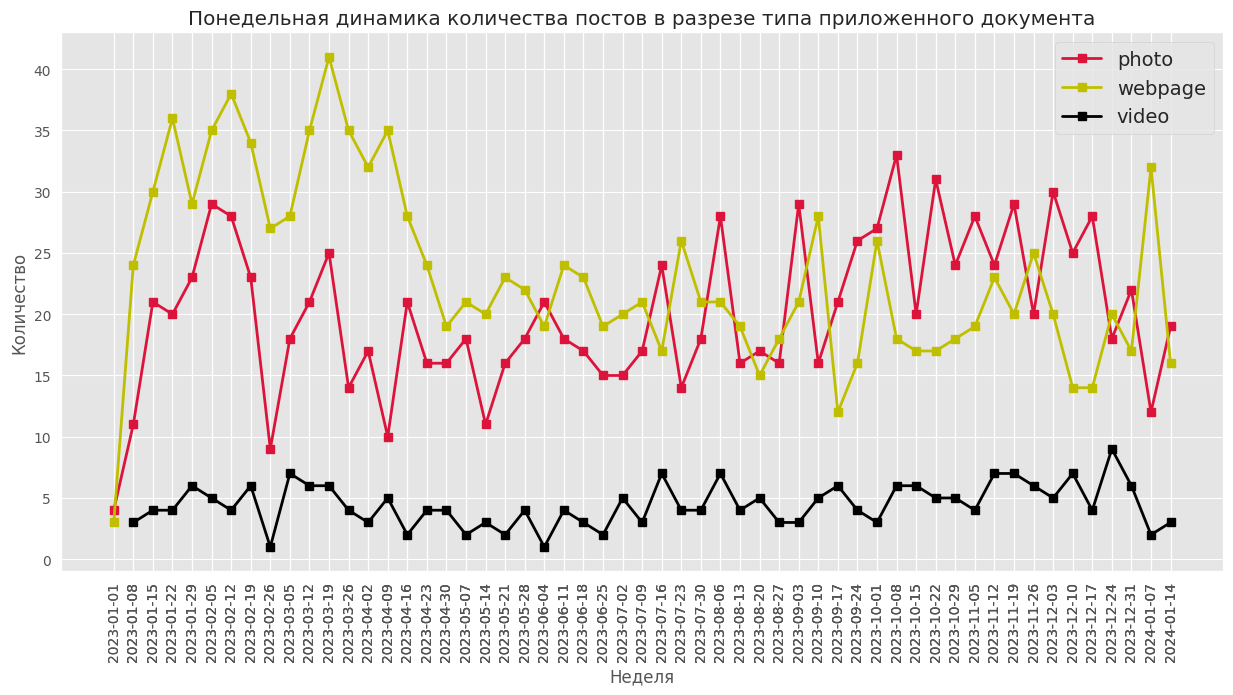

In [ ]:
# динамика в разрезе количества постов
er_doc('id', color, 'количества постов', 'Количество')

График показывает, что количество постов с видео самое низкое, хотя такие посты имеют наиболее высокие показатели вовлеченности.

## Вывод

Главная задача проекта, которая стояла перед командой: необходимо было продумать механику привлечения подписчиков в канал. Целью же аналитиков было выявление наиболее эффективных и точных метрик для еженедельного/ежемесячного анализа работы.

В наших данных есть информация о подписках и отписках (sub_det и sub_gen), о комментариях (comments), репостах (reposts и reposts_pars) и постах (posts). Все датасеты были приведены к одному периоду: 01.01.2023-14.01.2024.

Выводы по ходу работы:
1. На канале отмечается вариативный ежедневный приток новых подписчиков (0-180) и отток (0-170), среднедневные значения составляют до 75 и 70 соответственно. Наблюдается естественное распределение активности подписок и отписок в течение суток, с пиками вечером и ночью, а также интересным превышением отписок над подписками в 5-7 утра и в 14 часов.
2. Просмотры варьируются от 0 до 90k, с чаще всего встречающимися значениями в пределах 50k-65k. Дневные репосты, реакции и комментарии колеблются в пределах 0-450, 0-1000 и 0-85 соответственно, с чаще всего встречающимися значениями 80-220, 250-550 и 15-40.
3. Анализируя действия пользователей, учитывая выбросы, можно выделить нормальные аномалии в активности, связанные с контентом и глобальными событиями. Количество постов ежемесячно стабильно, с незначительным снижением летом.
4. Лидеры среди каналов по репостам - НаКал КаНал и другие каналы Кинопоиска, репостят преимущественно посты с фотографиями. Пользователи чаще комментируют в дневное время, с пиком между 18 и 19 часами, и менее активны в субботу.
5. Проведена кластеризация текстов постов, выделены три тематики: фильмы, сериалы и призыв к действию. Кинопоиск чаще публикует о фильмах, в меньшей степени о сериалах, а кластер "коммент" с призывами к действиям представлен небольшим числом, но наиболее ярко выделяется среди других кластеров.
6. Корреляция:
  - Сильная связь (0.9-1.0) между числом подписок и отписок, обусловленная увеличением аудитории.
  - Заметная связь (0.5-0.7) между просмотрами и подписками/отписками, репостами и реакциями, реакциями и комментариями, указывающая на влияние контента на привлечение и взаимодействие.
  - Умеренная корреляция (0.3-0.5) среди тематики и длины текста, длины текста и типа прикрепленного файла, реакций и типа прикрепленного файла, времени дня и отписок, репостов и просмотров, репостов и комментариев.
7. Динамика подписчиков: Резкий рост с внедрением бота (2023-11-06) и спад после (2023-11-27), возможно, из-за усталости от бота и нерелевантного контента. Виден всплеск в середине декабря, возможно, из-за предновогодних активностей.
8. По итогам проверки гипотезы наблюдается заметная взаимосвязь между типом приложенного документа и вовлеченностью подписчиков. Наибольший er у постов с видео.

**Метрики для анализа:**
- **Охват:** Май, сентябрь и октябрь имеют наименьшее число просмотров; рост с ноября, вероятно, связан с выпуском бота. Следует оперативно реагировать на снижение просмотров, используя график динамики среднего охвата по неделям в разрезе типов постов.
- **Вовлеченность:** Высокая вовлеченность в сентябре из-за выхода Барби и Опенгеймера; новогодние праздники привели к снижению. Посты с призывами к действиям имеют наивысшую вовлеченность. Тексты лучших постов подтверждают, что призыв к действию успешен. Выбраны 10 лучших постов по вовлеченности, подчеркивается значимость тематики "призыв к действию" (призыв пользователей делиться своим мнением в особенности) и взаимосвязь типа приложенного документа с вовлеченностью (у фото и видео вовлеченность выше, чем у постов с ссылками, у видео всех выше).

### Рекомендации для маркетинга и бизнеса:

1. **Оптимизация контента:**
   - **Вариативность контента:** С учетом вариативности активности подписок и отписок в течение суток, можно адаптировать расписание публикаций, экспериментировать со временем публикаций и отслеживать, когда ваши подписчики наиболее активны.
   - **Тематический фокус:** Необходимо уделить внимание тематике "призыв к действию", так как она показала высокую вовлеченность. Нужно развивать этот аспект контента и стимулировать подписчиков к активным действиям.

2. **Управление подписчиками:**
   - **Реакция на динамику подписчиков:** Нужно быть внимательными к динамике подписчиков. Можно использовать анализ резких изменений, таких как всплески и спады, для коррекции стратегии контента, рассмотреть внедрение новых стимулирующих элементов или механик активации подписчиков в периоды спада.

3. **Оценка эффективности контента:**
   - **Сегментация постов:** Необходимо сегментировать посты по типам (фото, видео, ссылки) и анализировать вовлеченность и просмотры. На момент анализа наибольшая вовлеченность у постов с видео, в то время как количество таких постов, наоборот, самое низкое. Стоит рассмотреть смену приоритетов в типах документов, которые прикрепляют к посту.

4. **Мониторинг и реагирование:**
   - **Оценка охвата:** Нужно поддерживать оперативный мониторинг охвата, особенно в периоды, когда просмотры снижаются. Анализировать посты, типы контента и временные интервалы, чтобы выявить и устранить причины снижения охвата.
   - **Анализ лучших постов:** Можно следить за лучшими постами по вовлеченности и использовать их как образец для создания контента, продолжать эксперименты с элементами, которые привлекают больше внимания.

5. **Аналитика и метрики:**
   - **Еженедельные/ежемесячные отчеты:** Рекомендуется составлять регулярные отчеты, выделяя ключевые метрики и сравнивать результаты с предыдущими периодами, выявлять тренды для дальнейших коррекций стратегии.

6. **Взаимодействие с лидерами каналов:**
   - **Партнерство с лидерами:** Можно углубить сотрудничество с каналами, которые лидируют по репостам (например, НаКал КаНал). Рассмотрите возможности для взаимных публикаций и совместных мероприятий.

С учетом данных и анализа, эти рекомендации могут помочь оптимизировать стратегии привлечения и удержания подписчиков, а также повысить общую эффективность канала.